# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


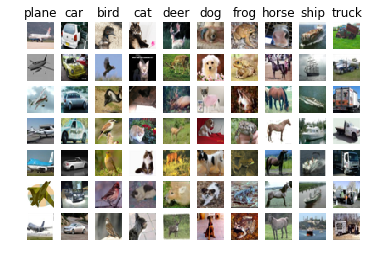

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [5]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


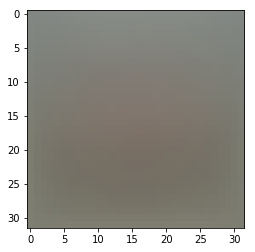

In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [7]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [8]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [9]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 9.465330


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [10]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 46.656616 analytic: 0.000000, relative error: 1.000000e+00
numerical: -7.303762 analytic: 0.000000, relative error: 1.000000e+00
numerical: 15.640594 analytic: 0.000000, relative error: 1.000000e+00
numerical: -2.925771 analytic: 0.000000, relative error: 1.000000e+00
numerical: 56.971617 analytic: 0.000000, relative error: 1.000000e+00
numerical: -13.911518 analytic: 0.000000, relative error: 1.000000e+00
numerical: 4.715868 analytic: 0.000000, relative error: 1.000000e+00
numerical: 16.884606 analytic: 0.000000, relative error: 1.000000e+00
numerical: 22.100915 analytic: 0.000000, relative error: 1.000000e+00
numerical: -2.520652 analytic: 0.000000, relative error: 1.000000e+00
numerical: -9.803013 analytic: 0.000000, relative error: 1.000000e+00
numerical: -5.801036 analytic: 0.000000, relative error: 1.000000e+00
numerical: -2.032621 analytic: 0.000000, relative error: 1.000000e+00
numerical: -18.330075 analytic: 0.000000, relative error: 1.000000e+00
numerical: -2.89322

### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** *fill this in.*

Answer: maybe locally minium could cause match bad in the way of gradient descent. Low learning rate will lead to hard to converge in the network,and it also easier to stop in local optimization. But high learning rate maybe cause skip the global Maxium. Simple example in one dimension is local optimization point. 

In [11]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 9.465330e+00 computed in 0.035979s
[[-41.64189796 -39.98173469 -78.47391837 ... -21.86195918 -56.39957143
    1.        ]
 [-36.64189796 -41.98173469 -38.47391837 ...  34.13804082  57.60042857
    1.        ]
 [ 63.35810204  77.01826531  38.52608163 ...  39.13804082 -37.39957143
    1.        ]
 ...
 [-61.64189796 -48.98173469 -60.47391837 ...  66.13804082  52.60042857
    1.        ]
 [-65.64189796 -54.98173469 -95.47391837 ... -43.86195918 -83.39957143
    1.        ]
 [-23.64189796 -12.98173469 -48.47391837 ...  28.13804082 -27.39957143
    1.        ]]
Vectorized loss: 9.465330e+00 computed in 0.014992s
difference: 0.000000


In [12]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.032980s
[[-41.64189796 -39.98173469 -78.47391837 ... -21.86195918 -56.39957143
    1.        ]
 [-36.64189796 -41.98173469 -38.47391837 ...  34.13804082  57.60042857
    1.        ]
 [ 63.35810204  77.01826531  38.52608163 ...  39.13804082 -37.39957143
    1.        ]
 ...
 [-61.64189796 -48.98173469 -60.47391837 ...  66.13804082  52.60042857
    1.        ]
 [-65.64189796 -54.98173469 -95.47391837 ... -43.86195918 -83.39957143
    1.        ]
 [-23.64189796 -12.98173469 -48.47391837 ...  28.13804082 -27.39957143
    1.        ]]
Vectorized loss and gradient: computed in 0.008994s
difference: 3271.574505


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [13]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
#print(y_train)
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

[[ -89.64189796  -68.98173469  -41.47391837 ...   39.13804082
   -14.39957143    1.        ]
 [ -70.64189796  -64.98173469 -119.47391837 ... -112.86195918
  -104.39957143    1.        ]
 [  83.35810204   84.01826531   86.52608163 ...  107.13804082
   107.60042857    1.        ]
 ...
 [  99.35810204  115.01826531  117.52608163 ...   -9.86195918
   -24.39957143    1.        ]
 [-117.64189796 -104.98173469 -105.47391837 ...  -20.86195918
   -28.39957143    1.        ]
 [  88.35810204   83.01826531   84.52608163 ...   89.13804082
    99.60042857    1.        ]]
iteration 0 / 1500: loss 416.006907
[[-109.64189796 -113.98173469  -86.47391837 ...   91.13804082
    71.60042857    1.        ]
 [-123.64189796  -83.98173469  -84.47391837 ...   29.13804082
    -2.39957143    1.        ]
 [ 120.35810204  112.01826531  122.52608163 ...  -23.86195918
    -9.39957143    1.        ]
 ...
 [ 101.35810204   91.01826531   91.52608163 ...   14.13804082
    32.60042857    1.        ]
 [  84.35810204   43.01

   -78.39957143    1.        ]]
[[  74.35810204   71.01826531   81.52608163 ...   39.13804082
    51.60042857    1.        ]
 [-116.64189796 -103.98173469  -85.47391837 ...   39.13804082
    51.60042857    1.        ]
 [  60.35810204   65.01826531   80.52608163 ...    0.13804082
    16.60042857    1.        ]
 ...
 [ -33.64189796  -28.98173469  -23.47391837 ...  -15.86195918
    -2.39957143    1.        ]
 [  70.35810204   74.01826531   82.52608163 ...   32.13804082
    36.60042857    1.        ]
 [ -58.64189796    3.01826531   67.52608163 ...   59.13804082
    66.60042857    1.        ]]
[[-122.64189796 -128.98173469 -128.47391837 ...   13.13804082
   -26.39957143    1.        ]
 [  93.35810204   87.01826531   86.52608163 ...   31.13804082
    48.60042857    1.        ]
 [ -81.64189796  -92.98173469  -99.47391837 ...  -59.86195918
   -49.39957143    1.        ]
 ...
 [-103.64189796  -93.98173469 -102.47391837 ...  -38.86195918
   -56.39957143    1.        ]
 [  47.35810204   39.018265

    85.60042857    1.        ]]
[[ -74.64189796  -68.98173469  -78.47391837 ...  -59.86195918
   -33.39957143    1.        ]
 [-114.64189796 -134.98173469 -129.47391837 ...   46.13804082
    30.60042857    1.        ]
 [ -44.64189796  -80.98173469  -88.47391837 ...   -9.86195918
    -5.39957143    1.        ]
 ...
 [  63.35810204   57.01826531   30.52608163 ...   47.13804082
    27.60042857    1.        ]
 [  19.35810204  -13.98173469  -71.47391837 ...  -49.86195918
   -56.39957143    1.        ]
 [  92.35810204   87.01826531   90.52608163 ...   69.13804082
    80.60042857    1.        ]]
[[123.35810204 119.01826531 120.52608163 ... -10.86195918   7.60042857
    1.        ]
 [ 98.35810204 112.01826531 121.52608163 ... 113.13804082 123.60042857
    1.        ]
 [ 32.35810204  46.01826531  45.52608163 ...  57.13804082  66.60042857
    1.        ]
 ...
 [-29.64189796   9.01826531  55.52608163 ...  29.13804082  28.60042857
    1.        ]
 [-71.64189796 -79.98173469 -69.47391837 ... -35.86

   -71.39957143    1.        ]]
[[  22.35810204   12.01826531  -54.47391837 ...  -17.86195918
   -47.39957143    1.        ]
 [ -81.64189796  -86.98173469  -85.47391837 ...  -79.86195918
   -66.39957143    1.        ]
 [   7.35810204   16.01826531   38.52608163 ...   -4.86195918
    17.60042857    1.        ]
 ...
 [  38.35810204   11.01826531   17.52608163 ...   36.13804082
    54.60042857    1.        ]
 [  17.35810204  -11.98173469  -37.47391837 ...   -2.86195918
   -22.39957143    1.        ]
 [ -96.64189796 -111.98173469 -104.47391837 ...  -81.86195918
   -70.39957143    1.        ]]
[[ -28.64189796   27.01826531   25.52608163 ...   -8.86195918
    -3.39957143    1.        ]
 [  76.35810204   69.01826531   77.52608163 ...  -77.86195918
   -66.39957143    1.        ]
 [  78.35810204   61.01826531   68.52608163 ...   10.13804082
   -11.39957143    1.        ]
 ...
 [-105.64189796 -111.98173469 -110.47391837 ...  -10.86195918
    -2.39957143    1.        ]
 [ -93.64189796 -103.981734

    1.        ]]
[[124.35810204 119.01826531 122.52608163 ... 129.13804082 140.60042857
    1.        ]
 [ 49.35810204  59.01826531  85.52608163 ... -12.86195918 -16.39957143
    1.        ]
 [ 13.35810204  32.01826531  36.52608163 ... -31.86195918 -21.39957143
    1.        ]
 ...
 [ 94.35810204  89.01826531 104.52608163 ...  99.13804082 122.60042857
    1.        ]
 [ 53.35810204  64.01826531  64.52608163 ... 126.13804082 136.60042857
    1.        ]
 [124.35810204 119.01826531 122.52608163 ... 129.13804082 140.60042857
    1.        ]]
[[ -91.64189796  -96.98173469  -93.47391837 ...  -56.86195918
   -51.39957143    1.        ]
 [ 103.35810204   99.01826531  107.52608163 ...  -25.86195918
   -33.39957143    1.        ]
 [-106.64189796 -109.98173469 -115.47391837 ... -114.86195918
  -100.39957143    1.        ]
 ...
 [  20.35810204   16.01826531   40.52608163 ...   -0.86195918
    27.60042857    1.        ]
 [  45.35810204   38.01826531   42.52608163 ...   33.13804082
    42.60042857 

   -10.39957143    1.        ]]
[[  91.35810204   86.01826531   89.52608163 ...    6.13804082
    11.60042857    1.        ]
 [  -8.64189796  -18.98173469  -21.47391837 ...  -87.86195918
   -80.39957143    1.        ]
 [ -15.64189796   -3.98173469  -21.47391837 ...    0.13804082
     1.60042857    1.        ]
 ...
 [-124.64189796 -133.98173469 -132.47391837 ...  -67.86195918
   -61.39957143    1.        ]
 [  58.35810204   46.01826531   41.52608163 ...   72.13804082
    76.60042857    1.        ]
 [  37.35810204   50.01826531   69.52608163 ...   -5.86195918
   -11.39957143    1.        ]]
[[ -49.64189796  -27.98173469  -77.47391837 ...  -55.86195918
   -46.39957143    1.        ]
 [ -10.64189796   26.01826531   66.52608163 ...  -53.86195918
   -54.39957143    1.        ]
 [ -43.64189796   -3.98173469   30.52608163 ...  116.13804082
   122.60042857    1.        ]
 ...
 [ 101.35810204   96.01826531   95.52608163 ...  -57.86195918
   -82.39957143    1.        ]
 [-125.64189796 -134.981734

   -57.39957143    1.        ]]
[[-2.36418980e+01 -1.39817347e+01  5.26081633e-01 ... -3.88619592e+01
  -5.63995714e+01  1.00000000e+00]
 [-2.46418980e+01 -2.09817347e+01 -7.94739184e+01 ... -1.18619592e+01
  -2.53995714e+01  1.00000000e+00]
 [-5.64189796e+00  3.00182653e+01 -4.24739184e+01 ... -2.86195918e+00
  -9.53995714e+01  1.00000000e+00]
 ...
 [ 4.35810204e+00 -1.98173469e+00 -2.47391837e+00 ... -9.08619592e+01
  -8.13995714e+01  1.00000000e+00]
 [-9.56418980e+01 -9.69817347e+01 -1.06473918e+02 ... -8.28619592e+01
  -9.83995714e+01  1.00000000e+00]
 [ 1.35810204e+00  1.82653061e-02 -5.84739184e+01 ...  1.51380408e+01
  -3.93995714e+01  1.00000000e+00]]
[[-25.64189796 -41.98173469 -22.47391837 ...  54.13804082  65.60042857
    1.        ]
 [ 78.35810204  40.01826531   8.52608163 ... -12.86195918 -28.39957143
    1.        ]
 [ 22.35810204  58.01826531  71.52608163 ... 109.13804082 119.60042857
    1.        ]
 ...
 [ -0.64189796 -28.98173469 -40.47391837 ... 120.13804082 126.6004

   116.60042857    1.        ]]
[[-26.64189796 -14.98173469  34.52608163 ...  31.13804082  66.60042857
    1.        ]
 [ 34.35810204  64.01826531 122.52608163 ...  46.13804082  89.60042857
    1.        ]
 [124.35810204 119.01826531 122.52608163 ... 129.13804082 140.60042857
    1.        ]
 ...
 [ 53.35810204  24.01826531   9.52608163 ...  -5.86195918 -20.39957143
    1.        ]
 [-30.64189796 -12.98173469   1.52608163 ...  43.13804082 -12.39957143
    1.        ]
 [-43.64189796   9.01826531  74.52608163 ... -58.86195918 -56.39957143
    1.        ]]
[[  10.35810204   -2.98173469  -20.47391837 ...  -96.86195918
  -107.39957143    1.        ]
 [   4.35810204   20.01826531  -53.47391837 ...   25.13804082
   -54.39957143    1.        ]
 [ -41.64189796  -37.98173469  -88.47391837 ...   20.13804082
   -34.39957143    1.        ]
 ...
 [ -45.64189796  -71.98173469  -86.47391837 ...  -87.86195918
   -81.39957143    1.        ]
 [ -91.64189796  -95.98173469  -97.47391837 ...   28.13804082
 

    -5.39957143    1.        ]]
[[ -61.64189796  -72.98173469  -76.47391837 ...  -22.86195918
   -46.39957143    1.        ]
 [ -24.64189796  -18.98173469   -9.47391837 ...   28.13804082
    67.60042857    1.        ]
 [  99.35810204   93.01826531  102.52608163 ...   -9.86195918
   -28.39957143    1.        ]
 ...
 [  12.35810204   76.01826531  121.52608163 ...   33.13804082
    -6.39957143    1.        ]
 [ -89.64189796  -93.98173469  -96.47391837 ...   34.13804082
     3.60042857    1.        ]
 [-112.64189796  -75.98173469 -111.47391837 ...  -40.86195918
   -90.39957143    1.        ]]
[[ 66.35810204  64.01826531  67.52608163 ... -32.86195918 -31.39957143
    1.        ]
 [-40.64189796 -35.98173469 -82.47391837 ... -55.86195918 -45.39957143
    1.        ]
 [ 57.35810204  90.01826531 101.52608163 ... -78.86195918 -56.39957143
    1.        ]
 ...
 [-38.64189796 -38.98173469 -13.47391837 ... -82.86195918 -66.39957143
    1.        ]
 [ 10.35810204 -33.98173469 -74.47391837 ...  34.13

  -4.13995714e+01  1.00000000e+00]]
[[ -84.64189796  -59.98173469  -54.47391837 ...   23.13804082
    11.60042857    1.        ]
 [-100.64189796  -98.98173469 -109.47391837 ...  -57.86195918
   -82.39957143    1.        ]
 [ -10.64189796  -23.98173469  -15.47391837 ...  -37.86195918
   -37.39957143    1.        ]
 ...
 [ -60.64189796  -70.98173469  -89.47391837 ...  -66.86195918
   -79.39957143    1.        ]
 [ 124.35810204  119.01826531  122.52608163 ... -120.86195918
  -104.39957143    1.        ]
 [  30.35810204   22.01826531   17.52608163 ...  -87.86195918
   -82.39957143    1.        ]]
[[  40.35810204   13.01826531 -104.47391837 ...  -18.86195918
   -22.39957143    1.        ]
 [-100.64189796  -93.98173469 -108.47391837 ...   11.13804082
    -6.39957143    1.        ]
 [ -66.64189796  -74.98173469  -97.47391837 ...  -68.86195918
   -75.39957143    1.        ]
 ...
 [  23.35810204   57.01826531   89.52608163 ...   12.13804082
    54.60042857    1.        ]
 [ 124.35810204  119.01

   -44.39957143    1.        ]]
[[-92.64189796 -84.98173469 -90.47391837 ... -34.86195918 -33.39957143
    1.        ]
 [ 27.35810204  21.01826531  30.52608163 ...  -0.86195918  19.60042857
    1.        ]
 [ 98.35810204  96.01826531 106.52608163 ... -47.86195918 -60.39957143
    1.        ]
 ...
 [123.35810204 118.01826531 121.52608163 ... -14.86195918 -52.39957143
    1.        ]
 [-50.64189796  14.01826531  29.52608163 ... -11.86195918   3.60042857
    1.        ]
 [  8.35810204 -14.98173469 -20.47391837 ... -12.86195918  -1.39957143
    1.        ]]
[[ -90.64189796 -102.98173469 -102.47391837 ...  -47.86195918
   -66.39957143    1.        ]
 [ -18.64189796  -60.98173469  -74.47391837 ... -102.86195918
   -91.39957143    1.        ]
 [  72.35810204   72.01826531   78.52608163 ...  -60.86195918
   -15.39957143    1.        ]
 ...
 [  32.35810204   46.01826531   65.52608163 ...  -18.86195918
   -57.39957143    1.        ]
 [ -55.64189796  -65.98173469  -69.47391837 ...  -11.86195918
 

    1.        ]]
[[ 124.35810204  119.01826531  122.52608163 ...  126.13804082
   137.60042857    1.        ]
 [ -55.64189796  -44.98173469  -75.47391837 ...  -68.86195918
   -86.39957143    1.        ]
 [-119.64189796 -123.98173469 -123.47391837 ...  -60.86195918
   -46.39957143    1.        ]
 ...
 [ -66.64189796    2.01826531   16.52608163 ...  -58.86195918
   -75.39957143    1.        ]
 [-115.64189796 -114.98173469 -113.47391837 ...    8.13804082
     2.60042857    1.        ]
 [  64.35810204   55.01826531   46.52608163 ...  -31.86195918
   -10.39957143    1.        ]]
[[  33.35810204   44.01826531    1.52608163 ...  106.13804082
    31.60042857    1.        ]
 [  97.35810204   99.01826531  112.52608163 ...   36.13804082
    42.60042857    1.        ]
 [  86.35810204   81.01826531   88.52608163 ...   40.13804082
    26.60042857    1.        ]
 ...
 [-118.64189796 -116.98173469 -114.47391837 ...  -61.86195918
   -34.39957143    1.        ]
 [ 123.35810204  119.01826531  122.5260816

    73.60042857    1.        ]]
[[  83.35810204   81.01826531   79.52608163 ...  -47.86195918
   -57.39957143    1.        ]
 [-105.64189796  -86.98173469  -81.47391837 ...   37.13804082
    66.60042857    1.        ]
 [  24.35810204   23.01826531   63.52608163 ... -111.86195918
  -103.39957143    1.        ]
 ...
 [ 100.35810204  111.01826531  100.52608163 ...   27.13804082
   -23.39957143    1.        ]
 [  41.35810204   71.01826531   99.52608163 ...   42.13804082
     3.60042857    1.        ]
 [  11.35810204   40.01826531   68.52608163 ...  -23.86195918
    -4.39957143    1.        ]]
[[-128.64189796 -126.98173469 -116.47391837 ...  -64.86195918
   -48.39957143    1.        ]
 [ -76.64189796  -76.98173469  -67.47391837 ...   63.13804082
   -27.39957143    1.        ]
 [ -93.64189796  -93.98173469  -91.47391837 ...  -70.86195918
   -58.39957143    1.        ]
 ...
 [  -6.64189796   10.01826531   29.52608163 ...  -33.86195918
   -31.39957143    1.        ]
 [  53.35810204   59.018265

    1.        ]]
[[ -17.64189796  -15.98173469  -67.47391837 ...  -30.86195918
   -53.39957143    1.        ]
 [ -48.64189796  -49.98173469  -61.47391837 ...   88.13804082
    92.60042857    1.        ]
 [ -39.64189796  -80.98173469 -107.47391837 ...   61.13804082
    45.60042857    1.        ]
 ...
 [   2.35810204  -17.98173469  -30.47391837 ...   30.13804082
    31.60042857    1.        ]
 [  34.35810204   38.01826531   58.52608163 ...  -50.86195918
   -19.39957143    1.        ]
 [-116.64189796 -122.98173469 -121.47391837 ... -108.86195918
  -100.39957143    1.        ]]
[[  99.35810204   93.01826531   91.52608163 ...  -76.86195918
   -77.39957143    1.        ]
 [  81.35810204  110.01826531  118.52608163 ...   54.13804082
    86.60042857    1.        ]
 [ -23.64189796  -26.98173469  -33.47391837 ...  -48.86195918
   -60.39957143    1.        ]
 ...
 [   8.35810204   65.01826531  121.52608163 ...   91.13804082
    83.60042857    1.        ]
 [ 123.35810204  111.01826531  110.5260816

    1.        ]]
[[-58.64189796 -68.98173469 -95.47391837 ... -53.86195918 -74.39957143
    1.        ]
 [ 14.35810204   8.01826531 -23.47391837 ...  51.13804082  35.60042857
    1.        ]
 [ 11.35810204   3.01826531 -52.47391837 ... -26.86195918 -75.39957143
    1.        ]
 ...
 [ 23.35810204  25.01826531 -28.47391837 ... -59.86195918 -78.39957143
    1.        ]
 [ 23.35810204  -4.98173469 -32.47391837 ...   1.13804082  18.60042857
    1.        ]
 [117.35810204 112.01826531 115.52608163 ...  34.13804082  52.60042857
    1.        ]]
[[  9.35810204 -46.98173469 -84.47391837 ... 128.13804082 133.60042857
    1.        ]
 [-13.64189796  -4.98173469  12.52608163 ...  20.13804082  39.60042857
    1.        ]
 [-86.64189796 -60.98173469 -30.47391837 ... -77.86195918 -76.39957143
    1.        ]
 ...
 [-45.64189796  -6.98173469 -44.47391837 ...  -5.86195918 -56.39957143
    1.        ]
 [ 84.35810204  84.01826531  82.52608163 ...   4.13804082 -19.39957143
    1.        ]
 [  6.35810204 

[[-105.64189796 -129.98173469 -124.47391837 ...   75.13804082
    37.60042857    1.        ]
 [ -17.64189796   -9.98173469  -72.47391837 ...    6.13804082
   -47.39957143    1.        ]
 [ -10.64189796  -27.98173469  -44.47391837 ...  -60.86195918
   -63.39957143    1.        ]
 ...
 [  24.35810204   25.01826531   60.52608163 ...    7.13804082
    15.60042857    1.        ]
 [  -6.64189796  -59.98173469  -70.47391837 ...   63.13804082
    85.60042857    1.        ]
 [  -0.64189796   23.01826531  -87.47391837 ...  -24.86195918
   -76.39957143    1.        ]]
[[ -28.64189796  -62.98173469  -69.47391837 ...  129.13804082
   140.60042857    1.        ]
 [ -97.64189796  -93.98173469 -116.47391837 ...  -63.86195918
   -50.39957143    1.        ]
 [ 115.35810204  113.01826531  120.52608163 ... -106.86195918
  -106.39957143    1.        ]
 ...
 [ -99.64189796  -95.98173469  -81.47391837 ...  -96.86195918
   -78.39957143    1.        ]
 [ 124.35810204  119.01826531  122.52608163 ...  -98.861959

    22.60042857    1.        ]]
[[-7.06418980e+01 -6.99817347e+01 -1.19473918e+02 ...  1.38040816e-01
  -6.83995714e+01  1.00000000e+00]
 [ 6.23581020e+01  8.00182653e+01  9.45260816e+01 ...  1.29138041e+02
   1.40600429e+02  1.00000000e+00]
 [-1.36418980e+01 -1.89817347e+01 -1.84739184e+01 ... -7.68619592e+01
  -6.43995714e+01  1.00000000e+00]
 ...
 [ 1.21358102e+02  1.07018265e+02  1.13526082e+02 ...  7.21380408e+01
   2.36004286e+01  1.00000000e+00]
 [ 3.35810204e+00 -2.79817347e+01 -4.84739184e+01 ... -3.38619592e+01
  -3.93995714e+01  1.00000000e+00]
 [ 5.35810204e+00  5.01826531e+00 -3.44739184e+01 ... -4.86195918e+00
  -6.39957143e+00  1.00000000e+00]]
[[  49.35810204   38.01826531  -33.47391837 ...   11.13804082
   -35.39957143    1.        ]
 [ -41.64189796  -44.98173469   -6.47391837 ...  -21.86195918
   -23.39957143    1.        ]
 [ 107.35810204   80.01826531   65.52608163 ...   48.13804082
    23.60042857    1.        ]
 ...
 [-114.64189796 -112.98173469  -99.47391837 ... 

    1.        ]]
[[ -41.64189796  -72.98173469  -61.47391837 ...  -63.86195918
   -54.39957143    1.        ]
 [ 123.35810204  118.01826531  121.52608163 ...  124.13804082
   134.60042857    1.        ]
 [  30.35810204   62.01826531   87.52608163 ...  -50.86195918
   -63.39957143    1.        ]
 ...
 [-126.64189796  -76.98173469  -23.47391837 ...  -51.86195918
   -34.39957143    1.        ]
 [ 115.35810204  110.01826531  113.52608163 ...  -10.86195918
     0.60042857    1.        ]
 [ 124.35810204  119.01826531  122.52608163 ...  129.13804082
   140.60042857    1.        ]]
[[ -86.64189796 -107.98173469  -98.47391837 ...  -60.86195918
   -58.39957143    1.        ]
 [  -1.64189796    7.01826531   38.52608163 ...  -47.86195918
   -39.39957143    1.        ]
 [ -14.64189796   -6.98173469   23.52608163 ...  -15.86195918
   -11.39957143    1.        ]
 ...
 [ 108.35810204  103.01826531  106.52608163 ...    0.13804082
    20.60042857    1.        ]
 [  30.35810204    2.01826531  -39.4739183

     0.60042857    1.        ]]
[[ -87.64189796 -110.98173469 -121.47391837 ...   10.13804082
     7.60042857    1.        ]
 [-111.64189796 -116.98173469 -118.47391837 ...  -49.86195918
   -43.39957143    1.        ]
 [ -14.64189796  -11.98173469    5.52608163 ...   18.13804082
    28.60042857    1.        ]
 ...
 [ -75.64189796  -77.98173469  -83.47391837 ...   48.13804082
    55.60042857    1.        ]
 [ -55.64189796  -56.98173469  -73.47391837 ...   14.13804082
   -26.39957143    1.        ]
 [ -59.64189796  -45.98173469  -10.47391837 ...  -83.86195918
   -63.39957143    1.        ]]
[[ -59.64189796  -63.98173469  -76.47391837 ...   84.13804082
    88.60042857    1.        ]
 [  -1.64189796  -48.98173469  -92.47391837 ...  -65.86195918
  -107.39957143    1.        ]
 [ -29.64189796  -11.98173469   34.52608163 ...  -45.86195918
   -16.39957143    1.        ]
 ...
 [ -36.64189796  -55.98173469    6.52608163 ...  -11.86195918
    -4.39957143    1.        ]
 [   7.35810204   24.018265

    1.        ]]
[[  48.35810204   43.01826531   46.52608163 ...   34.13804082
    45.60042857    1.        ]
 [ 124.35810204  119.01826531   95.52608163 ...  109.13804082
    43.60042857    1.        ]
 [  92.35810204   90.01826531   95.52608163 ...  -10.86195918
     2.60042857    1.        ]
 ...
 [  13.35810204   12.01826531   16.52608163 ...  129.13804082
   140.60042857    1.        ]
 [ -80.64189796  -53.98173469   22.52608163 ... -103.86195918
   -87.39957143    1.        ]
 [ 101.35810204  101.01826531  110.52608163 ...  109.13804082
   120.60042857    1.        ]]
[[ -59.64189796  -68.98173469  -66.47391837 ...  -43.86195918
   -23.39957143    1.        ]
 [-101.64189796 -104.98173469  -99.47391837 ...  -82.86195918
   -62.39957143    1.        ]
 [  18.35810204  -15.98173469  -39.47391837 ...    2.13804082
   -12.39957143    1.        ]
 ...
 [  16.35810204   21.01826531  -55.47391837 ...   55.13804082
     2.60042857    1.        ]
 [ 113.35810204  112.01826531  120.5260816

    1.        ]]
[[ -90.64189796 -100.98173469 -101.47391837 ...  -53.86195918
   -50.39957143    1.        ]
 [ -33.64189796  -60.98173469  -86.47391837 ...  -46.86195918
   -58.39957143    1.        ]
 [ -79.64189796 -115.98173469 -124.47391837 ... -112.86195918
  -106.39957143    1.        ]
 ...
 [   7.35810204   14.01826531   16.52608163 ...  -34.86195918
   -16.39957143    1.        ]
 [-124.64189796 -129.98173469 -126.47391837 ...  -95.86195918
   -84.39957143    1.        ]
 [ -97.64189796 -105.98173469 -105.47391837 ... -103.86195918
   -92.39957143    1.        ]]
[[ 106.35810204  102.01826531   99.52608163 ...   13.13804082
   -32.39957143    1.        ]
 [  18.35810204   22.01826531   56.52608163 ...    6.13804082
    25.60042857    1.        ]
 [ -12.64189796  -65.98173469 -111.47391837 ...   36.13804082
    24.60042857    1.        ]
 ...
 [ -64.64189796  -67.98173469  -97.47391837 ...   68.13804082
    -5.39957143    1.        ]
 [ -54.64189796  -46.98173469  -78.4739183

   -81.39957143    1.        ]]
[[ 122.35810204  117.01826531  120.52608163 ...  124.13804082
    72.60042857    1.        ]
 [ -81.64189796  -62.98173469  -91.47391837 ...  -71.86195918
   -38.39957143    1.        ]
 [ -10.64189796   -2.98173469   19.52608163 ...  -38.86195918
    40.60042857    1.        ]
 ...
 [   3.35810204  -15.98173469  -38.47391837 ...   94.13804082
    32.60042857    1.        ]
 [ -53.64189796   12.01826531 -112.47391837 ...  -14.86195918
  -101.39957143    1.        ]
 [  32.35810204   36.01826531  -70.47391837 ...    7.13804082
   -50.39957143    1.        ]]
[[ -63.64189796  -65.98173469  -72.47391837 ...   40.13804082
    41.60042857    1.        ]
 [  91.35810204   96.01826531  117.52608163 ... -106.86195918
  -103.39957143    1.        ]
 [-126.64189796 -131.98173469 -130.47391837 ... -104.86195918
  -100.39957143    1.        ]
 ...
 [ -52.64189796  -59.98173469  -60.47391837 ... -102.86195918
   -92.39957143    1.        ]
 [  19.35810204    6.018265

   -87.39957143    1.        ]]
[[  78.35810204   40.01826531  -25.47391837 ...   56.13804082
    49.60042857    1.        ]
 [   8.35810204    5.01826531   17.52608163 ...   37.13804082
    24.60042857    1.        ]
 [  -4.64189796    1.01826531   15.52608163 ...   26.13804082
    43.60042857    1.        ]
 ...
 [-109.64189796 -117.98173469 -125.47391837 ...  -54.86195918
   -75.39957143    1.        ]
 [   8.35810204   20.01826531   63.52608163 ...  -80.86195918
   -66.39957143    1.        ]
 [  39.35810204   34.01826531   36.52608163 ...   23.13804082
    44.60042857    1.        ]]
[[ -73.64189796  -77.98173469  -86.47391837 ...  -40.86195918
   -35.39957143    1.        ]
 [ -98.64189796  -51.98173469   30.52608163 ...  -69.86195918
   -76.39957143    1.        ]
 [-108.64189796 -110.98173469 -104.47391837 ...   53.13804082
    59.60042857    1.        ]
 ...
 [  18.35810204   29.01826531   12.52608163 ...  -22.86195918
   -67.39957143    1.        ]
 [   9.35810204   38.018265

    36.60042857    1.        ]]
[[ -92.64189796 -100.98173469  -86.47391837 ...  -46.86195918
   -28.39957143    1.        ]
 [ -30.64189796   18.01826531   48.52608163 ... -113.86195918
  -106.39957143    1.        ]
 [ -24.64189796  -37.98173469  -45.47391837 ...  -15.86195918
    -8.39957143    1.        ]
 ...
 [  17.35810204   46.01826531  -28.47391837 ...   25.13804082
   -60.39957143    1.        ]
 [  55.35810204   30.01826531  -14.47391837 ...   20.13804082
    19.60042857    1.        ]
 [-102.64189796 -116.98173469 -110.47391837 ...  -88.86195918
   -65.39957143    1.        ]]
[[  72.35810204   78.01826531  101.52608163 ...  -34.86195918
    11.60042857    1.        ]
 [  70.35810204   82.01826531   95.52608163 ...    1.13804082
   -10.39957143    1.        ]
 [ -24.64189796   -8.98173469  -82.47391837 ...  -60.86195918
   -60.39957143    1.        ]
 ...
 [  23.35810204   40.01826531   65.52608163 ...   -8.86195918
    -2.39957143    1.        ]
 [  34.35810204   43.018265

    39.60042857    1.        ]]
[[-69.64189796 -75.98173469 -82.47391837 ... -57.86195918 -89.39957143
    1.        ]
 [ -7.64189796 -17.98173469 -25.47391837 ... -28.86195918 -43.39957143
    1.        ]
 [  8.35810204 -22.98173469 -43.47391837 ...  10.13804082   5.60042857
    1.        ]
 ...
 [ 38.35810204  44.01826531  79.52608163 ...  40.13804082  82.60042857
    1.        ]
 [ 86.35810204  81.01826531  84.52608163 ...   1.13804082  12.60042857
    1.        ]
 [124.35810204 119.01826531 122.52608163 ... 129.13804082 140.60042857
    1.        ]]
[[ -55.64189796  -49.98173469  -57.47391837 ...  -64.86195918
   -58.39957143    1.        ]
 [-113.64189796 -108.98173469 -108.47391837 ...   25.13804082
   -65.39957143    1.        ]
 [ -66.64189796  -59.98173469  -71.47391837 ...   54.13804082
     7.60042857    1.        ]
 ...
 [ 116.35810204  106.01826531  111.52608163 ...  -35.86195918
   -18.39957143    1.        ]
 [ 120.35810204  105.01826531  115.52608163 ...   69.13804082
 

   -19.39957143    1.        ]]
[[-14.64189796 -45.98173469 -37.47391837 ... -98.86195918 -92.39957143
    1.        ]
 [-90.64189796 -94.98173469 -96.47391837 ... -46.86195918 -42.39957143
    1.        ]
 [-81.64189796 -12.98173469  33.52608163 ...  93.13804082 110.60042857
    1.        ]
 ...
 [-18.64189796 -28.98173469 -31.47391837 ...  56.13804082  71.60042857
    1.        ]
 [117.35810204 115.01826531 114.52608163 ... 125.13804082 136.60042857
    1.        ]
 [ -7.64189796 -40.98173469 -61.47391837 ...  -2.86195918 -37.39957143
    1.        ]]
[[ -18.64189796  -34.98173469  -48.47391837 ...    9.13804082
    -3.39957143    1.        ]
 [  55.35810204   38.01826531   20.52608163 ...   67.13804082
    64.60042857    1.        ]
 [  84.35810204   81.01826531   83.52608163 ...  -26.86195918
   -92.39957143    1.        ]
 ...
 [ -70.64189796  -34.98173469   35.52608163 ...    7.13804082
    -8.39957143    1.        ]
 [-126.64189796 -128.98173469 -126.47391837 ...  -21.86195918
 

   -58.39957143    1.        ]]
[[ -25.64189796   22.01826531   71.52608163 ...  -22.86195918
     3.60042857    1.        ]
 [ -18.64189796  -17.98173469  -43.47391837 ...   -4.86195918
   -20.39957143    1.        ]
 [-100.64189796 -102.98173469 -108.47391837 ...  -26.86195918
   -40.39957143    1.        ]
 ...
 [  75.35810204   83.01826531   94.52608163 ...  -24.86195918
   -35.39957143    1.        ]
 [  -8.64189796   14.01826531   17.52608163 ...  -48.86195918
   -45.39957143    1.        ]
 [ -65.64189796  -74.98173469  -83.47391837 ...  -48.86195918
   -70.39957143    1.        ]]
[[ -20.64189796   -3.98173469   -4.47391837 ...   81.13804082
    74.60042857    1.        ]
 [-113.64189796 -114.98173469 -112.47391837 ...   -0.86195918
     5.60042857    1.        ]
 [ -52.64189796  -24.98173469 -126.47391837 ...  -76.86195918
   -75.39957143    1.        ]
 ...
 [  44.35810204    6.01826531   -3.47391837 ...   54.13804082
    68.60042857    1.        ]
 [ -27.64189796  -17.981734

   -61.39957143    1.        ]]
[[  3.35810204  14.01826531  -1.47391837 ... -11.86195918  -8.39957143
    1.        ]
 [  6.35810204  47.01826531  77.52608163 ... -34.86195918  -2.39957143
    1.        ]
 [ 20.35810204 -20.98173469 -77.47391837 ... -15.86195918 -69.39957143
    1.        ]
 ...
 [-41.64189796 -44.98173469 -60.47391837 ... -10.86195918 -16.39957143
    1.        ]
 [ 44.35810204  52.01826531  65.52608163 ... -73.86195918 -53.39957143
    1.        ]
 [  5.35810204  31.01826531  62.52608163 ...  33.13804082  35.60042857
    1.        ]]
[[ 23.35810204  16.01826531  18.52608163 ...  -7.86195918  -1.39957143
    1.        ]
 [ 45.35810204  52.01826531  68.52608163 ... -52.86195918 -35.39957143
    1.        ]
 [-32.64189796 -43.98173469 -47.47391837 ... -75.86195918 -71.39957143
    1.        ]
 ...
 [ 19.35810204  12.01826531  18.52608163 ... -20.86195918  -9.39957143
    1.        ]
 [-94.64189796 -91.98173469 -51.47391837 ... -89.86195918 -43.39957143
    1.        ]


    -4.39957143    1.        ]]
[[-119.64189796 -117.98173469 -122.47391837 ...  -56.86195918
   -28.39957143    1.        ]
 [ -32.64189796  -94.98173469  -79.47391837 ...  -60.86195918
   -50.39957143    1.        ]
 [ -26.64189796  -33.98173469   -9.47391837 ...  -29.86195918
    59.60042857    1.        ]
 ...
 [ 112.35810204  107.01826531  110.52608163 ...   -2.86195918
    24.60042857    1.        ]
 [  16.35810204  -24.98173469  -60.47391837 ...   -8.86195918
    27.60042857    1.        ]
 [-108.64189796  -97.98173469 -103.47391837 ...  -12.86195918
    27.60042857    1.        ]]
[[ -55.64189796  -56.98173469  -73.47391837 ...   14.13804082
   -26.39957143    1.        ]
 [ -43.64189796  -24.98173469  -87.47391837 ...  122.13804082
   128.60042857    1.        ]
 [  29.35810204   29.01826531   38.52608163 ... -123.86195918
  -114.39957143    1.        ]
 ...
 [  -0.64189796  -28.98173469  -40.47391837 ...   27.13804082
     7.60042857    1.        ]
 [ 116.35810204   91.018265

    1.        ]]
[[  29.35810204   24.01826531   27.52608163 ...   44.13804082
    55.60042857    1.        ]
 [ -66.64189796  -63.98173469  -59.47391837 ...   70.13804082
    75.60042857    1.        ]
 [  53.35810204   43.01826531   44.52608163 ...   -2.86195918
    -6.39957143    1.        ]
 ...
 [ 124.35810204  119.01826531  122.52608163 ... -115.86195918
   -99.39957143    1.        ]
 [  68.35810204   80.01826531   99.52608163 ...   21.13804082
   -27.39957143    1.        ]
 [  63.35810204   57.01826531   23.52608163 ...   33.13804082
     9.60042857    1.        ]]
[[ 124.35810204  114.01826531  122.52608163 ...   95.13804082
   111.60042857    1.        ]
 [ -88.64189796  -93.98173469 -100.47391837 ...   -1.86195918
    23.60042857    1.        ]
 [ -88.64189796  -84.98173469  -93.47391837 ...  -27.86195918
   -83.39957143    1.        ]
 ...
 [  69.35810204   23.01826531  -15.47391837 ...  -16.86195918
   -29.39957143    1.        ]
 [  41.35810204   60.01826531   78.5260816

    14.60042857    1.        ]]
[[-41.64189796 -56.98173469 -27.47391837 ...  -8.86195918 -35.39957143
    1.        ]
 [-28.64189796 -16.98173469 -53.47391837 ...  34.13804082 -19.39957143
    1.        ]
 [-10.64189796   7.01826531  34.52608163 ...  12.13804082  40.60042857
    1.        ]
 ...
 [ 85.35810204  71.01826531  55.52608163 ...  33.13804082  20.60042857
    1.        ]
 [-88.64189796 -84.98173469 -96.47391837 ... -20.86195918 -16.39957143
    1.        ]
 [-61.64189796 -54.98173469 -41.47391837 ... -56.86195918 -60.39957143
    1.        ]]
[[-102.64189796 -111.98173469 -107.47391837 ...   70.13804082
    81.60042857    1.        ]
 [ 106.35810204  114.01826531  122.52608163 ...   25.13804082
   -19.39957143    1.        ]
 [ 110.35810204  106.01826531  102.52608163 ...  101.13804082
   128.60042857    1.        ]
 ...
 [  86.35810204   96.01826531  119.52608163 ...  -62.86195918
   -51.39957143    1.        ]
 [  14.35810204  -11.98173469  -25.47391837 ...   29.13804082
 

   -93.39957143    1.        ]]
[[  28.35810204   55.01826531   84.52608163 ...  -52.86195918
   -35.39957143    1.        ]
 [-122.64189796 -127.98173469 -124.47391837 ...  -83.86195918
   -72.39957143    1.        ]
 [-126.64189796 -125.98173469 -121.47391837 ...  -92.86195918
   -92.39957143    1.        ]
 ...
 [  25.35810204    2.01826531   -9.47391837 ...   20.13804082
    21.60042857    1.        ]
 [ -17.64189796  -21.98173469  -13.47391837 ...  -76.86195918
   -80.39957143    1.        ]
 [   8.35810204  -12.98173469  -15.47391837 ...   52.13804082
    56.60042857    1.        ]]
[[ 123.35810204  118.01826531  121.52608163 ...  125.13804082
   137.60042857    1.        ]
 [ -59.64189796  -64.98173469  -97.47391837 ...   54.13804082
    13.60042857    1.        ]
 [ 124.35810204  119.01826531  122.52608163 ...  124.13804082
   137.60042857    1.        ]
 ...
 [-128.64189796 -132.98173469 -132.47391837 ... -121.86195918
  -114.39957143    1.        ]
 [ -22.64189796  -26.981734

   -75.39957143    1.        ]]
[[  44.35810204   31.01826531   23.52608163 ...   30.13804082
    25.60042857    1.        ]
 [  99.35810204   95.01826531  103.52608163 ...   26.13804082
    36.60042857    1.        ]
 [  15.35810204   28.01826531   18.52608163 ...   25.13804082
    34.60042857    1.        ]
 ...
 [ -29.64189796    5.01826531   36.52608163 ...    9.13804082
    42.60042857    1.        ]
 [ -84.64189796 -107.98173469 -118.47391837 ...  -74.86195918
   -83.39957143    1.        ]
 [ 124.35810204  119.01826531  122.52608163 ...   27.13804082
    31.60042857    1.        ]]
[[ 123.35810204  118.01826531  121.52608163 ...   29.13804082
    43.60042857    1.        ]
 [  19.35810204    6.01826531    0.52608163 ...   44.13804082
    69.60042857    1.        ]
 [ -63.64189796  -34.98173469  -82.47391837 ...  -40.86195918
   -36.39957143    1.        ]
 ...
 [-108.64189796  -95.98173469 -117.47391837 ...  -87.86195918
  -100.39957143    1.        ]
 [ -87.64189796  -86.981734

    1.        ]]
[[  43.35810204   71.01826531   87.52608163 ...  -99.86195918
   -85.39957143    1.        ]
 [-106.64189796 -112.98173469 -104.47391837 ...  -83.86195918
   -59.39957143    1.        ]
 [-123.64189796 -128.98173469 -125.47391837 ...  -10.86195918
   -14.39957143    1.        ]
 ...
 [ 110.35810204   93.01826531   54.52608163 ...  -22.86195918
   -80.39957143    1.        ]
 [ -67.64189796  -79.98173469  -76.47391837 ...   16.13804082
    36.60042857    1.        ]
 [-126.64189796 -126.98173469 -129.47391837 ...  -20.86195918
   -17.39957143    1.        ]]
[[ 120.35810204  118.01826531  115.52608163 ...   59.13804082
    69.60042857    1.        ]
 [  95.35810204  110.01826531  122.52608163 ...  -12.86195918
   -57.39957143    1.        ]
 [  11.35810204   56.01826531  108.52608163 ...   49.13804082
    62.60042857    1.        ]
 ...
 [  37.35810204   69.01826531  109.52608163 ...    5.13804082
   -19.39957143    1.        ]
 [  30.35810204   15.01826531    9.5260816

    -7.39957143    1.        ]]
[[ -79.64189796  -57.98173469    0.52608163 ... -101.86195918
   -51.39957143    1.        ]
 [ -35.64189796  -49.98173469  -53.47391837 ...  -40.86195918
   -37.39957143    1.        ]
 [ -70.64189796  -71.98173469  -91.47391837 ...   11.13804082
    28.60042857    1.        ]
 ...
 [   9.35810204    4.01826531   17.52608163 ...  -29.86195918
   -18.39957143    1.        ]
 [ -29.64189796  -42.98173469 -130.47391837 ...  -16.86195918
  -114.39957143    1.        ]
 [  -3.64189796    1.01826531  -24.47391837 ...   16.13804082
    -2.39957143    1.        ]]
[[ -57.64189796 -133.98173469 -128.47391837 ...  -92.86195918
   -78.39957143    1.        ]
 [  -9.64189796  -27.98173469  -51.47391837 ...   77.13804082
    93.60042857    1.        ]
 [ -86.64189796 -103.98173469 -108.47391837 ...  -38.86195918
   -41.39957143    1.        ]
 ...
 [ 124.35810204  119.01826531  122.52608163 ...  129.13804082
   140.60042857    1.        ]
 [ -51.64189796  -71.981734

   -73.39957143    1.        ]]
[[ -90.64189796  -79.98173469  -86.47391837 ...   13.13804082
    23.60042857    1.        ]
 [ -26.64189796   -5.98173469   49.52608163 ...   29.13804082
    87.60042857    1.        ]
 [ 122.35810204  117.01826531  120.52608163 ...  127.13804082
   139.60042857    1.        ]
 ...
 [ 122.35810204  116.01826531  117.52608163 ...   -4.86195918
     3.60042857    1.        ]
 [  -3.64189796    9.01826531   25.52608163 ...   20.13804082
     4.60042857    1.        ]
 [  -1.64189796  -48.98173469  -92.47391837 ...  -65.86195918
  -107.39957143    1.        ]]
[[-85.64189796 -90.98173469 -89.47391837 ... -34.86195918 -21.39957143
    1.        ]
 [-79.64189796 -61.98173469 -72.47391837 ... -30.86195918 -16.39957143
    1.        ]
 [-58.64189796  38.01826531 112.52608163 ...  99.13804082 100.60042857
    1.        ]
 ...
 [-71.64189796 -84.98173469 -82.47391837 ... -33.86195918 -24.39957143
    1.        ]
 [-38.64189796 -51.98173469 -45.47391837 ...  24.13

   -85.39957143    1.        ]]
[[-39.64189796 -29.98173469 -16.47391837 ...  61.13804082  73.60042857
    1.        ]
 [-37.64189796 -53.98173469 -53.47391837 ... -39.86195918 -29.39957143
    1.        ]
 [-34.64189796 -40.98173469 -45.47391837 ...  10.13804082 -24.39957143
    1.        ]
 ...
 [-60.64189796 -62.98173469 -83.47391837 ...  10.13804082   3.60042857
    1.        ]
 [-30.64189796 -50.98173469 -70.47391837 ... -77.86195918 -85.39957143
    1.        ]
 [-57.64189796 -56.98173469 -63.47391837 ... -89.86195918 -82.39957143
    1.        ]]
[[-30.64189796 -51.98173469 -55.47391837 ...  31.13804082  25.60042857
    1.        ]
 [  6.35810204  -0.98173469  63.52608163 ...  -6.86195918 -35.39957143
    1.        ]
 [121.35810204 116.01826531 119.52608163 ... 118.13804082 135.60042857
    1.        ]
 ...
 [-91.64189796 -89.98173469 -71.47391837 ... -59.86195918 -80.39957143
    1.        ]
 [116.35810204 111.01826531  83.52608163 ... -60.86195918 -62.39957143
    1.        ]


    16.60042857    1.        ]]
[[  74.35810204   73.01826531   87.52608163 ...  -16.86195918
   -26.39957143    1.        ]
 [ -49.64189796  -63.98173469  -73.47391837 ...  -82.86195918
   -83.39957143    1.        ]
 [  -7.64189796   -1.98173469   -1.47391837 ...  -52.86195918
   -56.39957143    1.        ]
 ...
 [  44.35810204   11.01826531  -30.47391837 ...  -21.86195918
   -43.39957143    1.        ]
 [  15.35810204   -3.98173469  -17.47391837 ...  -83.86195918
   -65.39957143    1.        ]
 [-116.64189796 -121.98173469 -111.47391837 ...  -83.86195918
   -70.39957143    1.        ]]
[[ -91.64189796  -94.98173469  -90.47391837 ...  -18.86195918
   -47.39957143    1.        ]
 [   0.35810204  -27.98173469  -16.47391837 ...   40.13804082
    68.60042857    1.        ]
 [ 119.35810204  118.01826531  122.52608163 ...   42.13804082
    59.60042857    1.        ]
 ...
 [  98.35810204   97.01826531  109.52608163 ... -112.86195918
  -101.39957143    1.        ]
 [  45.35810204   29.018265

[[  47.35810204   67.01826531   92.52608163 ...   65.13804082
    99.60042857    1.        ]
 [ -76.64189796  -80.98173469  -85.47391837 ... -104.86195918
   -95.39957143    1.        ]
 [  63.35810204   58.01826531   59.52608163 ...  -53.86195918
   -48.39957143    1.        ]
 ...
 [-106.64189796 -110.98173469  -99.47391837 ...   39.13804082
    -9.39957143    1.        ]
 [  49.35810204   34.01826531   28.52608163 ...  -78.86195918
   -93.39957143    1.        ]
 [  20.35810204   15.01826531   -1.47391837 ...  -60.86195918
   -74.39957143    1.        ]]
[[  35.35810204   45.01826531   74.52608163 ...   26.13804082
    23.60042857    1.        ]
 [ -15.64189796  -30.98173469  -37.47391837 ... -120.86195918
  -106.39957143    1.        ]
 [  79.35810204   72.01826531   76.52608163 ...   81.13804082
    90.60042857    1.        ]
 ...
 [ -83.64189796  -78.98173469  -74.47391837 ...  -42.86195918
   -61.39957143    1.        ]
 [  29.35810204   32.01826531   33.52608163 ...   15.138040

   -59.39957143    1.        ]]
[[-130.64189796  -83.98173469  -31.47391837 ...  -75.86195918
   -15.39957143    1.        ]
 [  30.35810204   67.01826531  120.52608163 ...   36.13804082
    10.60042857    1.        ]
 [  44.35810204   53.01826531   43.52608163 ...   31.13804082
    31.60042857    1.        ]
 ...
 [  75.35810204   65.01826531   61.52608163 ...   21.13804082
    35.60042857    1.        ]
 [-112.64189796 -126.98173469 -126.47391837 ...  120.13804082
   107.60042857    1.        ]
 [ -79.64189796  -79.98173469  -77.47391837 ...   21.13804082
     5.60042857    1.        ]]
[[ -62.64189796  -59.98173469  -33.47391837 ...   78.13804082
    90.60042857    1.        ]
 [ -26.64189796  -26.98173469  -54.47391837 ...  103.13804082
    35.60042857    1.        ]
 [-105.64189796  -88.98173469  -58.47391837 ...  -87.86195918
   -46.39957143    1.        ]
 ...
 [-103.64189796 -114.98173469 -120.47391837 ... -120.86195918
  -106.39957143    1.        ]
 [ -61.64189796  -16.981734

   129.60042857    1.        ]]
[[ -98.64189796 -125.98173469 -115.47391837 ... -107.86195918
   -90.39957143    1.        ]
 [ -32.64189796  -27.98173469  -66.47391837 ...  -34.86195918
   -55.39957143    1.        ]
 [   0.35810204  -75.98173469 -110.47391837 ...  -48.86195918
   -34.39957143    1.        ]
 ...
 [-106.64189796 -112.98173469 -112.47391837 ...  -80.86195918
   -79.39957143    1.        ]
 [  34.35810204   39.01826531   70.52608163 ...  -67.86195918
   -52.39957143    1.        ]
 [  65.35810204   79.01826531  106.52608163 ...  -18.86195918
   -57.39957143    1.        ]]
[[ -36.64189796  -20.98173469  -29.47391837 ...   29.13804082
    -6.39957143    1.        ]
 [  44.35810204   41.01826531   29.52608163 ...   74.13804082
    60.60042857    1.        ]
 [-110.64189796 -126.98173469 -127.47391837 ...  -69.86195918
   -46.39957143    1.        ]
 ...
 [ -60.64189796  -67.98173469  -91.47391837 ...   34.13804082
    28.60042857    1.        ]
 [ 104.35810204   99.018265

[[-16.64189796 -15.98173469 -50.47391837 ...   4.13804082 -14.39957143
    1.        ]
 [-31.64189796 -19.98173469 -51.47391837 ...  71.13804082  42.60042857
    1.        ]
 [ 42.35810204  49.01826531  70.52608163 ...  11.13804082  14.60042857
    1.        ]
 ...
 [-26.64189796 -30.98173469 -29.47391837 ...  15.13804082   9.60042857
    1.        ]
 [109.35810204 104.01826531 102.52608163 ...  87.13804082  78.60042857
    1.        ]
 [ -3.64189796  -5.98173469 -28.47391837 ...  -9.86195918 -22.39957143
    1.        ]]
[[ 124.35810204  119.01826531  122.52608163 ...   61.13804082
    67.60042857    1.        ]
 [-124.64189796 -133.98173469 -129.47391837 ...  110.13804082
   126.60042857    1.        ]
 [ -38.64189796  -63.98173469  -75.47391837 ...  -36.86195918
   -39.39957143    1.        ]
 ...
 [  24.35810204   31.01826531   41.52608163 ...    3.13804082
     4.60042857    1.        ]
 [ 124.35810204  119.01826531  122.52608163 ...  129.13804082
   140.60042857    1.        ]
 [

   -65.39957143    1.        ]]
[[ -14.64189796   -8.98173469  -52.47391837 ...  -34.86195918
    -9.39957143    1.        ]
 [ -57.64189796 -133.98173469 -128.47391837 ...  -92.86195918
   -78.39957143    1.        ]
 [  46.35810204   54.01826531   74.52608163 ...  -21.86195918
     1.60042857    1.        ]
 ...
 [  46.35810204   31.01826531   25.52608163 ... -109.86195918
   -94.39957143    1.        ]
 [ -10.64189796   74.01826531  122.52608163 ...   84.13804082
   140.60042857    1.        ]
 [  57.35810204   47.01826531   80.52608163 ...  -12.86195918
     4.60042857    1.        ]]
[[  -5.64189796   11.01826531  -12.47391837 ...  119.13804082
   102.60042857    1.        ]
 [  97.35810204   46.01826531   26.52608163 ...  111.13804082
   121.60042857    1.        ]
 [ -84.64189796  -95.98173469  -88.47391837 ... -106.86195918
   -87.39957143    1.        ]
 ...
 [ -65.64189796  -46.98173469  -40.47391837 ... -102.86195918
   -96.39957143    1.        ]
 [ -96.64189796  -52.981734

   -72.39957143    1.        ]]
[[ -10.64189796  -24.98173469 -113.47391837 ...   16.13804082
   -83.39957143    1.        ]
 [  50.35810204   48.01826531   49.52608163 ...   99.13804082
   107.60042857    1.        ]
 [  35.35810204   52.01826531   57.52608163 ...   58.13804082
    35.60042857    1.        ]
 ...
 [-108.64189796 -103.98173469 -101.47391837 ...   34.13804082
   -21.39957143    1.        ]
 [ 121.35810204  116.01826531  119.52608163 ...  121.13804082
   132.60042857    1.        ]
 [-117.64189796 -122.98173469 -117.47391837 ... -113.86195918
  -102.39957143    1.        ]]
[[ -81.64189796  -91.98173469  -91.47391837 ...   58.13804082
    38.60042857    1.        ]
 [ -38.64189796    7.01826531   85.52608163 ...   55.13804082
    60.60042857    1.        ]
 [  25.35810204   -1.98173469  -20.47391837 ...   -8.86195918
   -21.39957143    1.        ]
 ...
 [   6.35810204   69.01826531  108.52608163 ...  -13.86195918
   -15.39957143    1.        ]
 [  -6.64189796   -8.981734

    37.60042857    1.        ]]
[[ -64.64189796  -86.98173469 -106.47391837 ...   -6.86195918
   -22.39957143    1.        ]
 [ -32.64189796   -2.98173469   30.52608163 ...  -23.86195918
     0.60042857    1.        ]
 [   6.35810204   -4.98173469  -13.47391837 ...   -8.86195918
     3.60042857    1.        ]
 ...
 [ 118.35810204  103.01826531  114.52608163 ...  -29.86195918
   -12.39957143    1.        ]
 [  88.35810204   76.01826531   72.52608163 ...   16.13804082
   -33.39957143    1.        ]
 [ -44.64189796  -50.98173469  -42.47391837 ...  -94.86195918
   -86.39957143    1.        ]]
[[116.35810204 111.01826531 110.52608163 ... 119.13804082 130.60042857
    1.        ]
 [-46.64189796 -53.98173469 -36.47391837 ... -83.86195918 -52.39957143
    1.        ]
 [ 89.35810204  75.01826531  64.52608163 ... 102.13804082  97.60042857
    1.        ]
 ...
 [124.35810204 118.01826531 122.52608163 ... 129.13804082 140.60042857
    1.        ]
 [ 85.35810204  74.01826531  41.52608163 ... -30.86

  -103.39957143    1.        ]]
[[-85.64189796 -90.98173469 -97.47391837 ...   6.13804082  -6.39957143
    1.        ]
 [  5.35810204   8.01826531  33.52608163 ...   8.13804082  38.60042857
    1.        ]
 [-25.64189796 -53.98173469 -93.47391837 ...   8.13804082 -29.39957143
    1.        ]
 ...
 [-62.64189796 -73.98173469 -74.47391837 ...  -9.86195918   1.60042857
    1.        ]
 [ 42.35810204  80.01826531 118.52608163 ... -58.86195918 -49.39957143
    1.        ]
 [-97.64189796 -97.98173469 -81.47391837 ... -23.86195918 -28.39957143
    1.        ]]
[[ 60.35810204  93.01826531  99.52608163 ...  88.13804082 114.60042857
    1.        ]
 [ 15.35810204  28.01826531  24.52608163 ...  35.13804082   1.60042857
    1.        ]
 [-47.64189796  -4.98173469  41.52608163 ... -49.86195918  -5.39957143
    1.        ]
 ...
 [ 32.35810204  51.01826531  78.52608163 ...  71.13804082 105.60042857
    1.        ]
 [-94.64189796 -99.98173469 -96.47391837 ... -77.86195918 -75.39957143
    1.        ]


    19.60042857    1.        ]]
[[  95.35810204   89.01826531   97.52608163 ...   -2.86195918
   -20.39957143    1.        ]
 [ 124.35810204  117.01826531  113.52608163 ...  129.13804082
   140.60042857    1.        ]
 [  21.35810204   27.01826531   50.52608163 ...   14.13804082
    48.60042857    1.        ]
 ...
 [ -33.64189796  -12.98173469  -20.47391837 ...   74.13804082
    93.60042857    1.        ]
 [-114.64189796 -114.98173469 -113.47391837 ...   22.13804082
   -54.39957143    1.        ]
 [-115.64189796 -109.98173469 -120.47391837 ... -117.86195918
  -107.39957143    1.        ]]
[[ -31.64189796  -29.98173469  -64.47391837 ...   11.13804082
    -1.39957143    1.        ]
 [-105.64189796  -64.98173469   20.52608163 ...   -5.86195918
    40.60042857    1.        ]
 [ -32.64189796  -42.98173469  -55.47391837 ...  -63.86195918
   -63.39957143    1.        ]
 ...
 [  20.35810204   46.01826531   65.52608163 ...  -20.86195918
   -16.39957143    1.        ]
 [ 109.35810204  113.018265

   -78.39957143    1.        ]]
[[ -57.64189796   17.01826531   85.52608163 ...  124.13804082
   135.60042857    1.        ]
 [ -47.64189796  -48.98173469  -68.47391837 ...  -57.86195918
   -57.39957143    1.        ]
 [ -56.64189796  -18.98173469   61.52608163 ...   21.13804082
    22.60042857    1.        ]
 ...
 [  69.35810204   71.01826531   74.52608163 ...  -43.86195918
   -40.39957143    1.        ]
 [ -35.64189796  -41.98173469  -43.47391837 ... -100.86195918
   -92.39957143    1.        ]
 [ -61.64189796  -85.98173469  -83.47391837 ...  -51.86195918
   -38.39957143    1.        ]]
[[  74.35810204   69.01826531   72.52608163 ...  -41.86195918
   -30.39957143    1.        ]
 [ -31.64189796   10.01826531  -25.47391837 ...    7.13804082
    18.60042857    1.        ]
 [  50.35810204   35.01826531   29.52608163 ...   42.13804082
    50.60042857    1.        ]
 ...
 [  17.35810204    7.01826531    5.52608163 ...   62.13804082
    82.60042857    1.        ]
 [-125.64189796 -130.981734

    1.        ]]
[[-32.64189796 -30.98173469 -74.47391837 ...   2.13804082 -23.39957143
    1.        ]
 [ 35.35810204  18.01826531  33.52608163 ...  38.13804082  66.60042857
    1.        ]
 [-72.64189796  23.01826531 -89.47391837 ...  23.13804082  45.60042857
    1.        ]
 ...
 [124.35810204 119.01826531 122.52608163 ... 129.13804082 140.60042857
    1.        ]
 [ 67.35810204  77.01826531  94.52608163 ... -15.86195918 -10.39957143
    1.        ]
 [-31.64189796 -20.98173469  -4.47391837 ...  -0.86195918 -17.39957143
    1.        ]]
[[102.35810204 107.01826531 115.52608163 ... -47.86195918 -27.39957143
    1.        ]
 [-76.64189796 -67.98173469 -92.47391837 ...  56.13804082  65.60042857
    1.        ]
 [-10.64189796 -15.98173469 -33.47391837 ...  29.13804082  64.60042857
    1.        ]
 ...
 [ -3.64189796 -11.98173469  -1.47391837 ... -31.86195918 -27.39957143
    1.        ]
 [ 47.35810204  46.01826531  58.52608163 ... -48.86195918 -29.39957143
    1.        ]
 [-56.64189796 

   -38.39957143    1.        ]]
[[ -97.64189796 -109.98173469 -112.47391837 ...  -35.86195918
   -30.39957143    1.        ]
 [ -18.64189796  -33.98173469  -22.47391837 ...  -87.86195918
   -59.39957143    1.        ]
 [  61.35810204   70.01826531  101.52608163 ...  -49.86195918
   -43.39957143    1.        ]
 ...
 [  62.35810204   53.01826531   68.52608163 ...  -30.86195918
   -23.39957143    1.        ]
 [  63.35810204   35.01826531   46.52608163 ...    6.13804082
    -2.39957143    1.        ]
 [-127.64189796 -134.98173469 -130.47391837 ... -120.86195918
  -108.39957143    1.        ]]
[[ 47.35810204  44.01826531  59.52608163 ... -18.86195918   0.60042857
    1.        ]
 [-89.64189796 -71.98173469 -61.47391837 ... -60.86195918 -69.39957143
    1.        ]
 [ 67.35810204  61.01826531  64.52608163 ...   7.13804082  23.60042857
    1.        ]
 ...
 [ 36.35810204  43.01826531  42.52608163 ...   4.13804082   9.60042857
    1.        ]
 [ 50.35810204   7.01826531 -69.47391837 ...  13.13

    95.60042857    1.        ]]
iteration 1000 / 1500: loss 7.265769
[[ -61.64189796  -43.98173469  -68.47391837 ...   87.13804082
    11.60042857    1.        ]
 [   5.35810204   10.01826531   36.52608163 ...    9.13804082
     2.60042857    1.        ]
 [ -27.64189796  -40.98173469  -40.47391837 ...   39.13804082
    30.60042857    1.        ]
 ...
 [-130.64189796 -135.98173469 -132.47391837 ... -125.86195918
  -114.39957143    1.        ]
 [-120.64189796 -133.98173469 -131.47391837 ... -121.86195918
  -114.39957143    1.        ]
 [  47.35810204   43.01826531   41.52608163 ...   62.13804082
    68.60042857    1.        ]]
[[ -67.64189796  -83.98173469  -60.47391837 ...   -2.86195918
    31.60042857    1.        ]
 [-128.64189796 -133.98173469 -131.47391837 ...  -88.86195918
   -90.39957143    1.        ]
 [ -26.64189796   12.01826531   -0.47391837 ...   47.13804082
    39.60042857    1.        ]
 ...
 [-124.64189796 -129.98173469 -129.47391837 ...  -86.86195918
   -60.39957143    1.

   -29.39957143    1.        ]]
[[ 88.35810204  34.01826531  -5.47391837 ...  -6.86195918 -11.39957143
    1.        ]
 [ 23.35810204  18.01826531  23.52608163 ...  54.13804082  77.60042857
    1.        ]
 [-65.64189796 -21.98173469 -78.47391837 ... -86.86195918 -93.39957143
    1.        ]
 ...
 [-13.64189796 -19.98173469 -46.47391837 ... -18.86195918 -40.39957143
    1.        ]
 [110.35810204 104.01826531 115.52608163 ...  89.13804082  97.60042857
    1.        ]
 [-25.64189796  19.01826531  44.52608163 ... -80.86195918 -61.39957143
    1.        ]]
[[-70.64189796 -67.98173469 -38.47391837 ... -19.86195918  -8.39957143
    1.        ]
 [-91.64189796 -40.98173469 -36.47391837 ...  -1.86195918 -22.39957143
    1.        ]
 [-36.64189796 -57.98173469 -52.47391837 ... -11.86195918 -19.39957143
    1.        ]
 ...
 [ 74.35810204  86.01826531 104.52608163 ... -25.86195918  34.60042857
    1.        ]
 [ 62.35810204  94.01826531  84.52608163 ...  25.13804082  27.60042857
    1.        ]


   -20.39957143    1.        ]]
[[ 77.35810204  75.01826531  91.52608163 ... -87.86195918 -98.39957143
    1.        ]
 [124.35810204 119.01826531 122.52608163 ... -62.86195918 -74.39957143
    1.        ]
 [120.35810204 112.01826531  78.52608163 ...  87.13804082  19.60042857
    1.        ]
 ...
 [-36.64189796 -50.98173469 -86.47391837 ...   3.13804082  -4.39957143
    1.        ]
 [ 25.35810204  -1.98173469 -23.47391837 ...  62.13804082  53.60042857
    1.        ]
 [ 39.35810204  61.01826531  88.52608163 ...  35.13804082  -5.39957143
    1.        ]]
[[ -17.64189796  -21.98173469  -24.47391837 ...   56.13804082
    51.60042857    1.        ]
 [  89.35810204   88.01826531  102.52608163 ...   39.13804082
    52.60042857    1.        ]
 [-126.64189796 -135.98173469 -129.47391837 ...  -33.86195918
    -6.39957143    1.        ]
 ...
 [ -11.64189796  -37.98173469  -58.47391837 ...   -5.86195918
    -4.39957143    1.        ]
 [  45.35810204   40.01826531   43.52608163 ...  -14.86195918
 

    1.        ]]
[[  27.35810204    1.01826531  -23.47391837 ...   -5.86195918
   -17.39957143    1.        ]
 [ 120.35810204  114.01826531  118.52608163 ...   -4.86195918
    13.60042857    1.        ]
 [  43.35810204   84.01826531  100.52608163 ...   -4.86195918
     8.60042857    1.        ]
 ...
 [-116.64189796 -121.98173469 -118.47391837 ...  -35.86195918
   -29.39957143    1.        ]
 [  55.35810204   31.01826531  -28.47391837 ...   -3.86195918
    10.60042857    1.        ]
 [ -44.64189796  -43.98173469  -63.47391837 ...  -86.86195918
   -81.39957143    1.        ]]
[[-114.64189796 -119.98173469 -116.47391837 ...   64.13804082
    -3.39957143    1.        ]
 [  15.35810204   25.01826531   53.52608163 ...   -9.86195918
    17.60042857    1.        ]
 [ -22.64189796  -11.98173469  -26.47391837 ...  -62.86195918
   -67.39957143    1.        ]
 ...
 [ -56.64189796  -61.98173469  -78.47391837 ...  -58.86195918
   -48.39957143    1.        ]
 [  13.35810204   88.01826531  106.5260816

[[  21.35810204    2.01826531  -27.47391837 ...  -26.86195918
   -39.39957143    1.        ]
 [ -11.64189796  -16.98173469  -13.47391837 ...   -1.86195918
   -49.39957143    1.        ]
 [-102.64189796 -102.98173469  -85.47391837 ...    2.13804082
   -19.39957143    1.        ]
 ...
 [ -66.64189796  -60.98173469  -67.47391837 ...  -42.86195918
   -29.39957143    1.        ]
 [  96.35810204   99.01826531  114.52608163 ...  129.13804082
   140.60042857    1.        ]
 [ 107.35810204  102.01826531  105.52608163 ...  129.13804082
   140.60042857    1.        ]]
[[  98.35810204  103.01826531  115.52608163 ...  128.13804082
   119.60042857    1.        ]
 [ -14.64189796  -47.98173469  -92.47391837 ...   64.13804082
    30.60042857    1.        ]
 [-129.64189796 -134.98173469 -131.47391837 ... -124.86195918
  -112.39957143    1.        ]
 ...
 [ -14.64189796  -27.98173469  -13.47391837 ...  -23.86195918
    -3.39957143    1.        ]
 [-122.64189796 -126.98173469 -125.47391837 ... -111.861959

   -61.39957143    1.        ]]
[[  33.35810204   26.01826531   75.52608163 ...   70.13804082
   110.60042857    1.        ]
 [-130.64189796 -135.98173469 -132.47391837 ...  -56.86195918
   -40.39957143    1.        ]
 [  16.35810204  102.01826531  120.52608163 ...   77.13804082
    61.60042857    1.        ]
 ...
 [ -53.64189796  -16.98173469  -45.47391837 ...   59.13804082
    50.60042857    1.        ]
 [ -25.64189796   -9.98173469   27.52608163 ...  -57.86195918
   -55.39957143    1.        ]
 [  -9.64189796  -27.98173469  -51.47391837 ...   77.13804082
    93.60042857    1.        ]]
[[-86.64189796 -69.98173469 -53.47391837 ...  70.13804082  72.60042857
    1.        ]
 [  8.35810204  12.01826531   1.52608163 ... -65.86195918 -56.39957143
    1.        ]
 [ 20.35810204   2.01826531   9.52608163 ...  53.13804082  67.60042857
    1.        ]
 ...
 [124.35810204  89.01826531  27.52608163 ... -32.86195918 -33.39957143
    1.        ]
 [ 29.35810204  36.01826531 -34.47391837 ... -34.86

[[-60.64189796  15.01826531  78.52608163 ... -10.86195918  45.60042857
    1.        ]
 [-57.64189796 -63.98173469 -70.47391837 ... -43.86195918 -63.39957143
    1.        ]
 [-89.64189796 -93.98173469 -86.47391837 ...  83.13804082 100.60042857
    1.        ]
 ...
 [-56.64189796 -61.98173469 -66.47391837 ...  40.13804082  57.60042857
    1.        ]
 [124.35810204 119.01826531 122.52608163 ... 127.13804082 138.60042857
    1.        ]
 [-58.64189796 -60.98173469 -56.47391837 ... -58.86195918 -98.39957143
    1.        ]]
[[  29.35810204   23.01826531   33.52608163 ...  -24.86195918
   -59.39957143    1.        ]
 [ 124.35810204  119.01826531  122.52608163 ...   72.13804082
   140.60042857    1.        ]
 [ -43.64189796    2.01826531  -35.47391837 ... -123.86195918
  -109.39957143    1.        ]
 ...
 [ -59.64189796   14.01826531   85.52608163 ...   17.13804082
    27.60042857    1.        ]
 [  51.35810204   41.01826531   33.52608163 ...   34.13804082
    38.60042857    1.        ]
 [

   -31.39957143    1.        ]]
[[  91.35810204   99.01826531  100.52608163 ...   16.13804082
    30.60042857    1.        ]
 [  16.35810204   57.01826531   86.52608163 ...  -67.86195918
   -56.39957143    1.        ]
 [ -44.64189796  -62.98173469  -39.47391837 ...  -65.86195918
   -50.39957143    1.        ]
 ...
 [  99.35810204   96.01826531  109.52608163 ... -110.86195918
   -99.39957143    1.        ]
 [  72.35810204   88.01826531  120.52608163 ...  -41.86195918
   -28.39957143    1.        ]
 [ -24.64189796  -43.98173469  -56.47391837 ...   93.13804082
    87.60042857    1.        ]]
[[ -94.64189796 -118.98173469 -124.47391837 ... -118.86195918
  -109.39957143    1.        ]
 [  90.35810204   85.01826531   98.52608163 ...   55.13804082
    79.60042857    1.        ]
 [  43.35810204   52.01826531   58.52608163 ...  -54.86195918
   -36.39957143    1.        ]
 ...
 [ -12.64189796  -29.98173469  -32.47391837 ...   38.13804082
    86.60042857    1.        ]
 [ -24.64189796  -44.981734

   -66.39957143    1.        ]]
[[102.35810204  96.01826531  94.52608163 ...  91.13804082 103.60042857
    1.        ]
 [ 99.35810204 100.01826531 104.52608163 ...  36.13804082  53.60042857
    1.        ]
 [105.35810204 107.01826531 104.52608163 ...  19.13804082 -25.39957143
    1.        ]
 ...
 [-68.64189796 -34.98173469 -17.47391837 ...  17.13804082  50.60042857
    1.        ]
 [ 55.35810204  53.01826531  63.52608163 ...  40.13804082  34.60042857
    1.        ]
 [ 58.35810204  59.01826531  53.52608163 ...  10.13804082   2.60042857
    1.        ]]
[[ 71.35810204  65.01826531  72.52608163 ...  51.13804082  58.60042857
    1.        ]
 [-40.64189796 -58.98173469 -73.47391837 ... -29.86195918 -34.39957143
    1.        ]
 [ 77.35810204  64.01826531  58.52608163 ...  36.13804082  11.60042857
    1.        ]
 ...
 [ 53.35810204  84.01826531 122.52608163 ... 100.13804082 130.60042857
    1.        ]
 [124.35810204 119.01826531 122.52608163 ... 129.13804082 140.60042857
    1.        ]


   -75.39957143    1.        ]]
[[ -72.64189796  -95.98173469 -104.47391837 ...   37.13804082
    29.60042857    1.        ]
 [ -21.64189796  -43.98173469  -69.47391837 ...  -95.86195918
   -88.39957143    1.        ]
 [  24.35810204   58.01826531   88.52608163 ...   15.13804082
    16.60042857    1.        ]
 ...
 [   1.35810204  -45.98173469  -98.47391837 ...   92.13804082
    64.60042857    1.        ]
 [   7.35810204   22.01826531   40.52608163 ...   20.13804082
    31.60042857    1.        ]
 [  21.35810204   19.01826531    9.52608163 ...    2.13804082
   -29.39957143    1.        ]]
[[  53.35810204   84.01826531  107.52608163 ...  -99.86195918
  -103.39957143    1.        ]
 [ -30.64189796  -35.98173469  -32.47391837 ...  -28.86195918
   -22.39957143    1.        ]
 [  -5.64189796   21.01826531   16.52608163 ...   57.13804082
    -2.39957143    1.        ]
 ...
 [ 124.35810204  119.01826531  122.52608163 ...  129.13804082
   140.60042857    1.        ]
 [  34.35810204   41.018265

    78.60042857    1.        ]]
[[  57.35810204   36.01826531   23.52608163 ...  -62.86195918
   -62.39957143    1.        ]
 [-106.64189796  -48.98173469  -63.47391837 ... -114.86195918
  -108.39957143    1.        ]
 [  -9.64189796    9.01826531  -42.47391837 ...   25.13804082
    -9.39957143    1.        ]
 ...
 [  23.35810204   21.01826531   35.52608163 ...  -87.86195918
   -69.39957143    1.        ]
 [ -80.64189796  -95.98173469  -91.47391837 ...   32.13804082
    23.60042857    1.        ]
 [ -94.64189796 -109.98173469 -108.47391837 ... -108.86195918
   -95.39957143    1.        ]]
[[-107.64189796 -103.98173469 -114.47391837 ... -108.86195918
  -100.39957143    1.        ]
 [  87.35810204   87.01826531   88.52608163 ...   25.13804082
    29.60042857    1.        ]
 [-108.64189796 -113.98173469 -110.47391837 ...  -27.86195918
   -16.39957143    1.        ]
 ...
 [ -79.64189796 -101.98173469 -103.47391837 ...  -60.86195918
   -57.39957143    1.        ]
 [   7.35810204   27.018265

    34.60042857    1.        ]]
[[  81.35810204   83.01826531   94.52608163 ...   87.13804082
    93.60042857    1.        ]
 [-116.64189796 -121.98173469 -125.47391837 ...   58.13804082
    29.60042857    1.        ]
 [ 111.35810204  109.01826531  117.52608163 ...   64.13804082
    16.60042857    1.        ]
 ...
 [-117.64189796   18.01826531   97.52608163 ...   66.13804082
  -109.39957143    1.        ]
 [-130.64189796 -135.98173469 -132.47391837 ...  -65.86195918
   -78.39957143    1.        ]
 [   6.35810204   21.01826531   45.52608163 ...  -13.86195918
    30.60042857    1.        ]]
[[124.35810204 119.01826531 122.52608163 ... 129.13804082 140.60042857
    1.        ]
 [-15.64189796  -2.98173469 -46.47391837 ... -28.86195918 -10.39957143
    1.        ]
 [-75.64189796 -62.98173469 -34.47391837 ... -57.86195918 -45.39957143
    1.        ]
 ...
 [-15.64189796 -38.98173469 -55.47391837 ... -68.86195918 -55.39957143
    1.        ]
 [ 60.35810204  55.01826531 110.52608163 ...  -2.86

    1.        ]]
[[ 94.35810204  95.01826531 102.52608163 ...  70.13804082  81.60042857
    1.        ]
 [122.35810204 117.01826531 120.52608163 ... -21.86195918  -5.39957143
    1.        ]
 [ 35.35810204  18.01826531 -26.47391837 ...  71.13804082  73.60042857
    1.        ]
 ...
 [-11.64189796  13.01826531  43.52608163 ... -56.86195918 -88.39957143
    1.        ]
 [-35.64189796 -28.98173469 -96.47391837 ... -78.86195918 -79.39957143
    1.        ]
 [ -6.64189796 -19.98173469  -8.47391837 ...  35.13804082  46.60042857
    1.        ]]
[[  38.35810204   34.01826531   31.52608163 ...   90.13804082
    92.60042857    1.        ]
 [ 121.35810204  105.01826531  101.52608163 ...   16.13804082
   -17.39957143    1.        ]
 [ -63.64189796  -62.98173469  -61.47391837 ...   21.13804082
    28.60042857    1.        ]
 ...
 [  90.35810204   59.01826531   33.52608163 ...   45.13804082
    15.60042857    1.        ]
 [  51.35810204  -17.98173469 -100.47391837 ...  -34.86195918
   -92.39957143 

    38.60042857    1.        ]]
[[ 114.35810204  109.01826531  110.52608163 ...  -34.86195918
   -18.39957143    1.        ]
 [  38.35810204   36.01826531   57.52608163 ...  -10.86195918
     2.60042857    1.        ]
 [  -3.64189796  -11.98173469  -28.47391837 ...  -97.86195918
   -82.39957143    1.        ]
 ...
 [  50.35810204   44.01826531   52.52608163 ... -120.86195918
  -109.39957143    1.        ]
 [ -97.64189796   32.01826531   28.52608163 ...   23.13804082
    32.60042857    1.        ]
 [  86.35810204   95.01826531   81.52608163 ...  -21.86195918
    -5.39957143    1.        ]]
[[ 81.35810204  80.01826531  96.52608163 ...  61.13804082 -18.39957143
    1.        ]
 [124.35810204 119.01826531 122.52608163 ... 129.13804082 140.60042857
    1.        ]
 [ 54.35810204  53.01826531  -9.47391837 ...  39.13804082 -53.39957143
    1.        ]
 ...
 [-47.64189796 -68.98173469 -92.47391837 ... -57.86195918 -38.39957143
    1.        ]
 [-40.64189796  -1.98173469 -78.47391837 ...  -5.86

   114.60042857    1.        ]]
[[106.35810204 114.01826531 122.52608163 ...  25.13804082 -19.39957143
    1.        ]
 [ 89.35810204  81.01826531  90.52608163 ...  35.13804082  47.60042857
    1.        ]
 [ -5.64189796  55.01826531  20.52608163 ... -73.86195918 -70.39957143
    1.        ]
 ...
 [123.35810204 116.01826531 122.52608163 ... 127.13804082 138.60042857
    1.        ]
 [ 95.35810204  98.01826531  77.52608163 ...  79.13804082  58.60042857
    1.        ]
 [ 84.35810204  45.01826531 -14.47391837 ...  45.13804082   7.60042857
    1.        ]]
[[-72.64189796 -50.98173469 -58.47391837 ... -23.86195918 -17.39957143
    1.        ]
 [ 85.35810204  88.01826531 114.52608163 ...  76.13804082 100.60042857
    1.        ]
 [-29.64189796  28.01826531  12.52608163 ...  24.13804082  18.60042857
    1.        ]
 ...
 [ 36.35810204  21.01826531 -11.47391837 ...   3.13804082 -53.39957143
    1.        ]
 [124.35810204 119.01826531 122.52608163 ... 128.13804082 139.60042857
    1.        ]


     6.60042857    1.        ]]
[[-50.64189796 -71.98173469 -83.47391837 ... -27.86195918 -26.39957143
    1.        ]
 [-11.64189796 -15.98173469   5.52608163 ... -21.86195918  47.60042857
    1.        ]
 [-23.64189796  -2.98173469 -77.47391837 ...   0.13804082 -70.39957143
    1.        ]
 ...
 [ 14.35810204   7.01826531  -7.47391837 ...  90.13804082 101.60042857
    1.        ]
 [-35.64189796 -75.98173469 -92.47391837 ...  -5.86195918  -9.39957143
    1.        ]
 [ 32.35810204   3.01826531 -47.47391837 ... -51.86195918 -72.39957143
    1.        ]]
[[ 50.35810204  30.01826531  30.52608163 ...  28.13804082  26.60042857
    1.        ]
 [ 39.35810204  62.01826531 105.52608163 ...  54.13804082  52.60042857
    1.        ]
 [-38.64189796 -40.98173469  -4.47391837 ...  29.13804082  37.60042857
    1.        ]
 ...
 [124.35810204 119.01826531 122.52608163 ...  83.13804082  94.60042857
    1.        ]
 [-12.64189796  24.01826531  49.52608163 ...   2.13804082  26.60042857
    1.        ]


    1.        ]]
[[-106.64189796  -97.98173469 -119.47391837 ...  -30.86195918
   -60.39957143    1.        ]
 [ -81.64189796  -72.98173469  -83.47391837 ...  -75.86195918
   -68.39957143    1.        ]
 [  57.35810204   56.01826531  -55.47391837 ...   45.13804082
   -46.39957143    1.        ]
 ...
 [  95.35810204   90.01826531   93.52608163 ...   96.13804082
   115.60042857    1.        ]
 [  44.35810204   58.01826531   74.52608163 ...  -91.86195918
   -72.39957143    1.        ]
 [ -76.64189796  -85.98173469  -88.47391837 ...  -41.86195918
   -37.39957143    1.        ]]
[[ -98.64189796  -97.98173469 -113.47391837 ...  -15.86195918
     2.60042857    1.        ]
 [ -94.64189796 -114.98173469  -92.47391837 ...    6.13804082
    -4.39957143    1.        ]
 [ -28.64189796  -25.98173469  -69.47391837 ...   89.13804082
    93.60042857    1.        ]
 ...
 [ -81.64189796  -86.98173469  -85.47391837 ...  -79.86195918
   -66.39957143    1.        ]
 [ -88.64189796  -72.98173469  -55.4739183

  -9.83995714e+01  1.00000000e+00]]
[[ -96.64189796  -87.98173469  -82.47391837 ...   82.13804082
    89.60042857    1.        ]
 [  12.35810204    8.01826531   -6.47391837 ...   69.13804082
    69.60042857    1.        ]
 [ -28.64189796  -30.98173469    3.52608163 ...  -66.86195918
   -33.39957143    1.        ]
 ...
 [ -16.64189796   -1.98173469  -19.47391837 ...   -3.86195918
   -59.39957143    1.        ]
 [ 124.35810204  119.01826531  122.52608163 ... -125.86195918
  -114.39957143    1.        ]
 [  -7.64189796  -13.98173469  -50.47391837 ...  -15.86195918
    -4.39957143    1.        ]]
[[  20.35810204   34.01826531   35.52608163 ...  -39.86195918
   -44.39957143    1.        ]
 [  85.35810204   80.01826531   83.52608163 ...   48.13804082
    64.60042857    1.        ]
 [ -23.64189796  -34.98173469  -37.47391837 ...  -15.86195918
     4.60042857    1.        ]
 ...
 [-129.64189796 -134.98173469 -131.47391837 ...   19.13804082
    15.60042857    1.        ]
 [ -70.64189796  -68.98

   -61.39957143    1.        ]]
[[-15.64189796   4.01826531  49.52608163 ... -20.86195918 -25.39957143
    1.        ]
 [ 50.35810204  33.01826531  44.52608163 ...  74.13804082  92.60042857
    1.        ]
 [ 20.35810204  46.01826531  95.52608163 ...  55.13804082  95.60042857
    1.        ]
 ...
 [-21.64189796 -53.98173469 -77.47391837 ...  94.13804082  66.60042857
    1.        ]
 [113.35810204 110.01826531 112.52608163 ...  20.13804082  13.60042857
    1.        ]
 [ 82.35810204  43.01826531  -0.47391837 ...   5.13804082 -20.39957143
    1.        ]]
[[ -21.64189796  -31.98173469  -24.47391837 ...   33.13804082
    49.60042857    1.        ]
 [  81.35810204   93.01826531  113.52608163 ...   68.13804082
    78.60042857    1.        ]
 [ -27.64189796    4.01826531   46.52608163 ...  -31.86195918
   -75.39957143    1.        ]
 ...
 [ 108.35810204  117.01826531  121.52608163 ...   24.13804082
    12.60042857    1.        ]
 [ -16.64189796  -21.98173469  -18.47391837 ... -122.86195918
 

    77.60042857    1.        ]]
[[ -41.64189796  -68.98173469  -78.47391837 ...   88.13804082
    95.60042857    1.        ]
 [  37.35810204   66.01826531  -78.47391837 ...   77.13804082
   -53.39957143    1.        ]
 [  -4.64189796   -2.98173469   16.52608163 ...  -22.86195918
   -32.39957143    1.        ]
 ...
 [-118.64189796 -127.98173469 -119.47391837 ... -111.86195918
  -100.39957143    1.        ]
 [ -73.64189796  -11.98173469   44.52608163 ...  103.13804082
   111.60042857    1.        ]
 [  -4.64189796  -22.98173469  -32.47391837 ...  -46.86195918
   -65.39957143    1.        ]]
[[  14.35810204  -67.98173469 -113.47391837 ...   60.13804082
    -6.39957143    1.        ]
 [ -69.64189796  -42.98173469 -108.47391837 ...   42.13804082
   -90.39957143    1.        ]
 [ -51.64189796  -53.98173469  -92.47391837 ...  -94.86195918
   -86.39957143    1.        ]
 ...
 [ -56.64189796  -25.98173469  -94.47391837 ...   72.13804082
     5.60042857    1.        ]
 [  -8.64189796  -21.981734

    66.60042857    1.        ]]
[[ -35.64189796  -40.98173469  -29.47391837 ...   17.13804082
     4.60042857    1.        ]
 [ -85.64189796  -87.98173469  -93.47391837 ...  -66.86195918
   -79.39957143    1.        ]
 [ -83.64189796  -79.98173469 -102.47391837 ...  -78.86195918
   -83.39957143    1.        ]
 ...
 [ -49.64189796  -38.98173469  -98.47391837 ...  -14.86195918
   -44.39957143    1.        ]
 [  63.35810204   32.01826531   14.52608163 ...  -42.86195918
   -61.39957143    1.        ]
 [ -28.64189796  -31.98173469   -9.47391837 ...  -14.86195918
    -1.39957143    1.        ]]
[[  19.35810204  -10.98173469  -29.47391837 ...   20.13804082
     0.60042857    1.        ]
 [ -23.64189796   -0.98173469   23.52608163 ...   24.13804082
    26.60042857    1.        ]
 [-130.64189796 -135.98173469 -132.47391837 ... -120.86195918
  -111.39957143    1.        ]
 ...
 [ -76.64189796  -45.98173469    2.52608163 ...  -84.86195918
   -74.39957143    1.        ]
 [-110.64189796  -40.981734

  -108.39957143    1.        ]]
[[  64.35810204   96.01826531  122.52608163 ...    8.13804082
    -7.39957143    1.        ]
 [-106.64189796 -114.98173469 -117.47391837 ...  -21.86195918
    -7.39957143    1.        ]
 [   8.35810204    7.01826531   22.52608163 ...  -26.86195918
   -50.39957143    1.        ]
 ...
 [ -25.64189796    5.01826531   74.52608163 ...  -96.86195918
   -93.39957143    1.        ]
 [  56.35810204   72.01826531   93.52608163 ...   -0.86195918
    61.60042857    1.        ]
 [ -10.64189796   59.01826531  -74.47391837 ...    2.13804082
   -78.39957143    1.        ]]
[[  41.35810204  -68.98173469 -115.47391837 ...  -87.86195918
   -91.39957143    1.        ]
 [ -49.64189796  -52.98173469  -65.47391837 ...  100.13804082
    48.60042857    1.        ]
 [  82.35810204   71.01826531   84.52608163 ...  -33.86195918
   -47.39957143    1.        ]
 ...
 [  47.35810204   26.01826531   19.52608163 ...  -87.86195918
   -98.39957143    1.        ]
 [  26.35810204   47.018265

   -12.39957143    1.        ]]
[[ 124.35810204  119.01826531  122.52608163 ...  129.13804082
   140.60042857    1.        ]
 [  66.35810204   59.01826531   62.52608163 ...  -71.86195918
   -54.39957143    1.        ]
 [ 124.35810204  119.01826531  122.52608163 ...    3.13804082
   -33.39957143    1.        ]
 ...
 [ -90.64189796  -83.98173469 -107.47391837 ...   24.13804082
     6.60042857    1.        ]
 [  89.35810204  106.01826531  119.52608163 ...   11.13804082
   -36.39957143    1.        ]
 [  16.35810204   36.01826531   87.52608163 ...   84.13804082
    86.60042857    1.        ]]
[[ -37.64189796  -37.98173469  -31.47391837 ...   43.13804082
    60.60042857    1.        ]
 [ -12.64189796   24.01826531   49.52608163 ...    2.13804082
    26.60042857    1.        ]
 [ -46.64189796  -50.98173469  -51.47391837 ...  -19.86195918
   -50.39957143    1.        ]
 ...
 [-108.64189796 -113.98173469 -110.47391837 ...    9.13804082
    16.60042857    1.        ]
 [   7.35810204   26.018265

   -42.39957143    1.        ]]
[[ -53.64189796   12.01826531  103.52608163 ... -101.86195918
   -91.39957143    1.        ]
 [  -2.64189796   -6.98173469  -11.47391837 ...  -51.86195918
   -53.39957143    1.        ]
 [ -22.64189796  -45.98173469  -55.47391837 ...  -57.86195918
   -47.39957143    1.        ]
 ...
 [  29.35810204   -1.98173469  -24.47391837 ...  -27.86195918
   -27.39957143    1.        ]
 [  23.35810204   28.01826531    5.52608163 ...   56.13804082
    14.60042857    1.        ]
 [ -38.64189796  -52.98173469  -51.47391837 ... -121.86195918
  -110.39957143    1.        ]]
[[ -0.64189796  12.01826531  30.52608163 ...  25.13804082  30.60042857
    1.        ]
 [ 72.35810204  80.01826531  80.52608163 ...  20.13804082  29.60042857
    1.        ]
 [-41.64189796 -15.98173469 -69.47391837 ... -38.86195918 -61.39957143
    1.        ]
 ...
 [-58.64189796 -70.98173469 -76.47391837 ...  28.13804082 -11.39957143
    1.        ]
 [124.35810204 119.01826531 122.52608163 ... 129.13

    43.60042857    1.        ]]
[[ 17.35810204  13.01826531   9.52608163 ...  -3.86195918 -18.39957143
    1.        ]
 [122.35810204 118.01826531 116.52608163 ...  61.13804082  36.60042857
    1.        ]
 [-77.64189796 -83.98173469 -90.47391837 ... -63.86195918 -45.39957143
    1.        ]
 ...
 [ 63.35810204  62.01826531  64.52608163 ...  37.13804082  47.60042857
    1.        ]
 [-21.64189796  -8.98173469 -27.47391837 ...  -2.86195918   3.60042857
    1.        ]
 [-86.64189796 -78.98173469 -98.47391837 ... -41.86195918 -38.39957143
    1.        ]]
[[ 21.35810204  41.01826531  78.52608163 ...  15.13804082  26.60042857
    1.        ]
 [ 21.35810204  16.01826531  19.52608163 ...   9.13804082  20.60042857
    1.        ]
 [ -3.64189796 -66.98173469 -82.47391837 ...   5.13804082 -48.39957143
    1.        ]
 ...
 [-52.64189796 -62.98173469 -65.47391837 ...  56.13804082  59.60042857
    1.        ]
 [ -1.64189796  25.01826531  56.52608163 ...   2.13804082  -8.39957143
    1.        ]


    1.        ]]
[[  60.35810204   58.01826531   56.52608163 ...   67.13804082
    74.60042857    1.        ]
 [-101.64189796  -94.98173469  -71.47391837 ...  -66.86195918
   -13.39957143    1.        ]
 [ 124.35810204  119.01826531  122.52608163 ...   86.13804082
    83.60042857    1.        ]
 ...
 [ 100.35810204   96.01826531   93.52608163 ...  -42.86195918
   -30.39957143    1.        ]
 [ -44.64189796  -41.98173469   79.52608163 ...  -26.86195918
    87.60042857    1.        ]
 [ -52.64189796  -83.98173469  -92.47391837 ...  -82.86195918
   -78.39957143    1.        ]]
[[-104.64189796  -94.98173469 -104.47391837 ...  -29.86195918
   -24.39957143    1.        ]
 [  46.35810204   13.01826531  -22.47391837 ... -125.86195918
  -114.39957143    1.        ]
 [ -92.64189796 -108.98173469 -109.47391837 ...  -45.86195918
   -58.39957143    1.        ]
 ...
 [  38.35810204   74.01826531  108.52608163 ...  -87.86195918
   -72.39957143    1.        ]
 [  63.35810204   74.01826531  116.5260816

    1.        ]]
[[-84.64189796 -90.98173469 -82.47391837 ... -43.86195918 -40.39957143
    1.        ]
 [ 46.35810204  33.01826531 -18.47391837 ...   5.13804082 -49.39957143
    1.        ]
 [-24.64189796   1.01826531 -44.47391837 ...  40.13804082   6.60042857
    1.        ]
 ...
 [ 62.35810204  59.01826531  74.52608163 ... -47.86195918 -66.39957143
    1.        ]
 [ 57.35810204  59.01826531  54.52608163 ...  49.13804082  22.60042857
    1.        ]
 [ 88.35810204  79.01826531  85.52608163 ...  52.13804082  49.60042857
    1.        ]]
[[  -5.64189796   55.01826531   20.52608163 ...  -73.86195918
   -70.39957143    1.        ]
 [ -66.64189796  -83.98173469 -102.47391837 ... -116.86195918
  -105.39957143    1.        ]
 [ -47.64189796  -46.98173469   57.52608163 ...  -97.86195918
   -78.39957143    1.        ]
 ...
 [  97.35810204  106.01826531  119.52608163 ...  101.13804082
   126.60042857    1.        ]
 [ -46.64189796  -59.98173469  -59.47391837 ...  -91.86195918
   -82.39957143 

    24.60042857    1.        ]]
[[ -3.64189796 -11.98173469   8.52608163 ...  56.13804082  80.60042857
    1.        ]
 [ 68.35810204  76.01826531  81.52608163 ...  28.13804082  73.60042857
    1.        ]
 [-44.64189796   5.01826531 -72.47391837 ... -25.86195918 -25.39957143
    1.        ]
 ...
 [115.35810204 110.01826531 113.52608163 ...  -8.86195918   9.60042857
    1.        ]
 [ 20.35810204  37.01826531  51.52608163 ... -58.86195918 -35.39957143
    1.        ]
 [ 21.35810204  19.01826531   9.52608163 ...   2.13804082 -29.39957143
    1.        ]]
[[ -90.64189796  -95.98173469 -123.47391837 ...  -66.86195918
   -85.39957143    1.        ]
 [ -66.64189796  -51.98173469  -56.47391837 ...   42.13804082
    48.60042857    1.        ]
 [ -75.64189796  -91.98173469  -97.47391837 ...  -25.86195918
   -18.39957143    1.        ]
 ...
 [ -54.64189796  -13.98173469   40.52608163 ...   -4.86195918
    56.60042857    1.        ]
 [ -40.64189796   43.01826531  119.52608163 ...   79.13804082
 

   140.60042857    1.        ]]
[[124.35810204 119.01826531 122.52608163 ... -61.86195918 -48.39957143
    1.        ]
 [120.35810204 113.01826531  93.52608163 ...  11.13804082  20.60042857
    1.        ]
 [ 88.35810204  86.01826531 106.52608163 ... -18.86195918 -10.39957143
    1.        ]
 ...
 [ 30.35810204  52.01826531 -17.47391837 ...  20.13804082 -37.39957143
    1.        ]
 [-52.64189796 -54.98173469 -65.47391837 ... -21.86195918 -22.39957143
    1.        ]
 [124.35810204 119.01826531 122.52608163 ... 126.13804082 137.60042857
    1.        ]]
[[  54.35810204   64.01826531  -17.47391837 ...   70.13804082
     3.60042857    1.        ]
 [  95.35810204  100.01826531  108.52608163 ...  129.13804082
   140.60042857    1.        ]
 [   0.35810204   24.01826531   85.52608163 ...    7.13804082
   -21.39957143    1.        ]
 ...
 [ -16.64189796  -29.98173469  -12.47391837 ...    6.13804082
    25.60042857    1.        ]
 [  -1.64189796   33.01826531   86.52608163 ...  -46.86195918
 

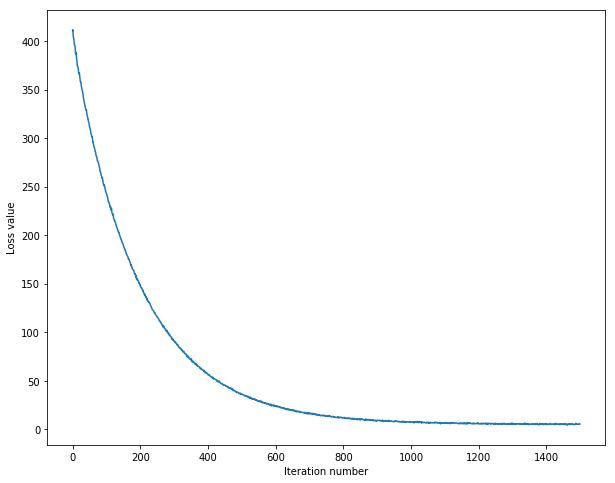

In [31]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [32]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.381939
validation accuracy: 0.381000


In [37]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
params = [(x,y) for x in learning_rates for y in regularization_strengths]
for lrate, regular in params:
    svm = LinearSVM()
    loss_hist = svm.train(X_train, y_train, learning_rate=lrate, reg=regular,
                      num_iters=700, verbose=False)
    y_train_pred = svm.predict(X_train)
    accuracy_train = np.mean(y_train == y_train_pred)
    y_val_pred = svm.predict(X_val)
    accuracy_val = np.mean(y_val == y_val_pred)
    results[(lrate, regular)]=(accuracy_train, accuracy_val)
    if (best_val < accuracy_val):
        best_val = accuracy_val
        best_svm = svm
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

[[-129.64189796 -134.98173469 -131.47391837 ... -124.86195918
  -113.39957143    1.        ]
 [ -49.64189796  -92.98173469 -108.47391837 ...  -95.86195918
   -81.39957143    1.        ]
 [  31.35810204   60.01826531   33.52608163 ...   83.13804082
    80.60042857    1.        ]
 ...
 [ -59.64189796  -79.98173469  -72.47391837 ...   51.13804082
    67.60042857    1.        ]
 [ 105.35810204  104.01826531   65.52608163 ...   90.13804082
    58.60042857    1.        ]
 [ -95.64189796 -110.98173469 -106.47391837 ...   40.13804082
    53.60042857    1.        ]]
[[  40.35810204   38.01826531    1.52608163 ...   38.13804082
    35.60042857    1.        ]
 [   6.35810204   21.01826531   57.52608163 ...  -24.86195918
    18.60042857    1.        ]
 [ -15.64189796  -20.98173469  -18.47391837 ...  -40.86195918
   -24.39957143    1.        ]
 ...
 [ -86.64189796  -73.98173469 -117.47391837 ...  -55.86195918
   -94.39957143    1.        ]
 [  60.35810204   39.01826531    3.52608163 ...  126.138040

    16.60042857    1.        ]]
[[-8.64189796e+00  1.82653061e-02 -6.47391837e+00 ... -9.88619592e+01
  -8.63995714e+01  1.00000000e+00]
 [-1.76418980e+01  2.80182653e+01  6.45260816e+01 ...  1.51380408e+01
   3.26004286e+01  1.00000000e+00]
 [-1.96418980e+01 -1.09817347e+01 -1.94739184e+01 ...  4.81380408e+01
   5.46004286e+01  1.00000000e+00]
 ...
 [ 7.83581020e+01  6.40182653e+01  2.55260816e+01 ...  1.14138041e+02
   1.19600429e+02  1.00000000e+00]
 [ 1.63581020e+01 -2.39817347e+01 -4.34739184e+01 ... -7.08619592e+01
   1.36004286e+01  1.00000000e+00]
 [ 1.24358102e+02  1.19018265e+02  1.22526082e+02 ...  1.29138041e+02
   1.40600429e+02  1.00000000e+00]]
[[ 26.35810204  18.01826531 -19.47391837 ...  18.13804082  -9.39957143
    1.        ]
 [116.35810204 112.01826531 111.52608163 ... 128.13804082 139.60042857
    1.        ]
 [  0.35810204 -27.98173469 -55.47391837 ...  34.13804082  62.60042857
    1.        ]
 ...
 [-14.64189796 -21.98173469 -20.47391837 ... -51.86195918 -15.3995

    1.        ]]
[[124.35810204 119.01826531 118.52608163 ...  11.13804082 -16.39957143
    1.        ]
 [ 27.35810204  19.01826531   6.52608163 ... -12.86195918 -17.39957143
    1.        ]
 [  3.35810204  46.01826531  79.52608163 ...  29.13804082  41.60042857
    1.        ]
 ...
 [ 22.35810204  11.01826531  16.52608163 ... -18.86195918 -31.39957143
    1.        ]
 [ -6.64189796 -86.98173469 -97.47391837 ... -89.86195918 -78.39957143
    1.        ]
 [-11.64189796  -5.98173469 -12.47391837 ...  17.13804082  15.60042857
    1.        ]]
[[ 86.35810204  91.01826531 103.52608163 ...   2.13804082   8.60042857
    1.        ]
 [ 27.35810204 -24.98173469 -64.47391837 ...  11.13804082 -19.39957143
    1.        ]
 [ 47.35810204  65.01826531  79.52608163 ...  89.13804082  66.60042857
    1.        ]
 ...
 [-44.64189796 -40.98173469 -88.47391837 ... -13.86195918 -22.39957143
    1.        ]
 [-11.64189796  -7.98173469  25.52608163 ... -78.86195918 -67.39957143
    1.        ]
 [-71.64189796 

   -10.39957143    1.        ]]
[[ -77.64189796    1.01826531   66.52608163 ...  -28.86195918
   -11.39957143    1.        ]
 [  30.35810204   56.01826531   92.52608163 ...   -9.86195918
    -7.39957143    1.        ]
 [  -7.64189796   -2.98173469   -2.47391837 ...  -73.86195918
   -74.39957143    1.        ]
 ...
 [   6.35810204   57.01826531   63.52608163 ...   18.13804082
     3.60042857    1.        ]
 [ -85.64189796  -43.98173469  -83.47391837 ...  -39.86195918
   -64.39957143    1.        ]
 [-130.64189796 -135.98173469 -132.47391837 ...  -84.86195918
   -88.39957143    1.        ]]
[[  49.35810204   91.01826531  105.52608163 ...   65.13804082
    82.60042857    1.        ]
 [ -59.64189796  -58.98173469 -112.47391837 ...  -33.86195918
   -54.39957143    1.        ]
 [ -79.64189796  -89.98173469  -78.47391837 ... -109.86195918
   -94.39957143    1.        ]
 ...
 [ -93.64189796  -56.98173469   20.52608163 ...  -57.86195918
    42.60042857    1.        ]
 [ -11.64189796  -12.981734

[[  -5.64189796  -23.98173469  -65.47391837 ...   -0.86195918
   -32.39957143    1.        ]
 [ -32.64189796  -32.98173469  -40.47391837 ...   -8.86195918
     7.60042857    1.        ]
 [  26.35810204   70.01826531  115.52608163 ...   20.13804082
    -8.39957143    1.        ]
 ...
 [  17.35810204   35.01826531   49.52608163 ...  -47.86195918
   -43.39957143    1.        ]
 [ -97.64189796 -115.98173469 -118.47391837 ...  -71.86195918
  -104.39957143    1.        ]
 [ -79.64189796  -77.98173469  -82.47391837 ...   80.13804082
   -21.39957143    1.        ]]
[[  23.35810204  -87.98173469 -124.47391837 ...  -52.86195918
   -61.39957143    1.        ]
 [ -47.64189796  -28.98173469  -31.47391837 ...   61.13804082
    33.60042857    1.        ]
 [ -99.64189796  -56.98173469   11.52608163 ...  -89.86195918
   -24.39957143    1.        ]
 ...
 [ -46.64189796  -19.98173469   48.52608163 ...   32.13804082
    42.60042857    1.        ]
 [  40.35810204   29.01826531    7.52608163 ...    0.138040

    -6.39957143    1.        ]]
[[ -46.64189796  -39.98173469  -56.47391837 ...   32.13804082
    37.60042857    1.        ]
 [-117.64189796 -101.98173469 -115.47391837 ...  -38.86195918
   -64.39957143    1.        ]
 [ -37.64189796  -58.98173469  -71.47391837 ...   19.13804082
    10.60042857    1.        ]
 ...
 [ -90.64189796 -104.98173469 -108.47391837 ...  -29.86195918
   -25.39957143    1.        ]
 [ -25.64189796  -26.98173469  -22.47391837 ...  -76.86195918
   -70.39957143    1.        ]
 [  -0.64189796  -58.98173469  -92.47391837 ...   -0.86195918
   -36.39957143    1.        ]]
[[  9.35810204  51.01826531 109.52608163 ...  27.13804082  24.60042857
    1.        ]
 [  2.35810204  32.01826531  45.52608163 ...  11.13804082  11.60042857
    1.        ]
 [ -8.64189796  18.01826531  23.52608163 ... -21.86195918 -10.39957143
    1.        ]
 ...
 [ 68.35810204  39.01826531  -0.47391837 ...  63.13804082  34.60042857
    1.        ]
 [124.35810204 119.01826531 122.52608163 ... -46.86

    32.60042857    1.        ]]
[[ 25.35810204   4.01826531 -20.47391837 ...   6.13804082 -13.39957143
    1.        ]
 [ 39.35810204  18.01826531 -35.47391837 ... -12.86195918 -66.39957143
    1.        ]
 [ 50.35810204  47.01826531  26.52608163 ...  32.13804082  24.60042857
    1.        ]
 ...
 [-17.64189796  -9.98173469 -72.47391837 ...   6.13804082 -47.39957143
    1.        ]
 [ 18.35810204  -7.98173469 -52.47391837 ...  83.13804082  71.60042857
    1.        ]
 [ 10.35810204  -0.98173469 -15.47391837 ...  74.13804082 115.60042857
    1.        ]]
[[ 13.35810204  -9.98173469 -23.47391837 ...  -3.86195918  45.60042857
    1.        ]
 [ 73.35810204  66.01826531  76.52608163 ... -47.86195918 -37.39957143
    1.        ]
 [  9.35810204  20.01826531  72.52608163 ...  44.13804082  90.60042857
    1.        ]
 ...
 [ 34.35810204  27.01826531  17.52608163 ...   8.13804082  22.60042857
    1.        ]
 [124.35810204 119.01826531 122.52608163 ... 129.13804082 140.60042857
    1.        ]


[[ -73.64189796  -89.98173469  -89.47391837 ...  100.13804082
   118.60042857    1.        ]
 [ -48.64189796  -60.98173469  -80.47391837 ...  -77.86195918
   -71.39957143    1.        ]
 [ -39.64189796 -125.98173469 -121.47391837 ...  -39.86195918
   -21.39957143    1.        ]
 ...
 [ -88.64189796  -93.98173469 -131.47391837 ...  -47.86195918
   -83.39957143    1.        ]
 [ -26.64189796  -44.98173469  -39.47391837 ...   37.13804082
    26.60042857    1.        ]
 [-121.64189796  -75.98173469    7.52608163 ...  -28.86195918
   -17.39957143    1.        ]]
[[ 15.35810204 -57.98173469 -66.47391837 ... -29.86195918 -41.39957143
    1.        ]
 [  1.35810204  22.01826531  42.52608163 ... -44.86195918  -6.39957143
    1.        ]
 [ 14.35810204  11.01826531  18.52608163 ... -56.86195918 -57.39957143
    1.        ]
 ...
 [110.35810204 106.01826531 106.52608163 ...  55.13804082  50.60042857
    1.        ]
 [124.35810204 119.01826531 122.52608163 ... 129.13804082 140.60042857
    1.      

   3.60042857e+00  1.00000000e+00]]
[[-128.64189796  -85.98173469   35.52608163 ...   52.13804082
   136.60042857    1.        ]
 [ -52.64189796  -29.98173469  -41.47391837 ...  129.13804082
   126.60042857    1.        ]
 [ -28.64189796  -17.98173469  -28.47391837 ...  126.13804082
   136.60042857    1.        ]
 ...
 [ -69.64189796   -4.98173469   53.52608163 ...  -65.86195918
   -40.39957143    1.        ]
 [ -15.64189796  -10.98173469  -61.47391837 ...    2.13804082
   -24.39957143    1.        ]
 [   2.35810204    7.01826531   30.52608163 ...   23.13804082
    46.60042857    1.        ]]
[[ 97.35810204  93.01826531 117.52608163 ...   6.13804082  53.60042857
    1.        ]
 [  0.35810204  56.01826531 113.52608163 ...  11.13804082  31.60042857
    1.        ]
 [-54.64189796 -66.98173469 -71.47391837 ... -36.86195918 -29.39957143
    1.        ]
 ...
 [ 32.35810204  33.01826531  20.52608163 ...  65.13804082  60.60042857
    1.        ]
 [-36.64189796   7.01826531 107.52608163 ... -6

    21.60042857    1.        ]]
[[-75.64189796 -80.98173469 -79.47391837 ...  63.13804082  57.60042857
    1.        ]
 [ 48.35810204  43.01826531  55.52608163 ... -29.86195918 -39.39957143
    1.        ]
 [ 21.35810204  16.01826531  19.52608163 ...  26.13804082  37.60042857
    1.        ]
 ...
 [ 44.35810204  46.01826531   9.52608163 ...   7.13804082 -20.39957143
    1.        ]
 [ 53.35810204  48.01826531  51.52608163 ...  50.13804082  61.60042857
    1.        ]
 [-24.64189796  -7.98173469  34.52608163 ...   0.13804082  42.60042857
    1.        ]]
[[ -66.64189796  -44.98173469  -76.47391837 ...    6.13804082
    33.60042857    1.        ]
 [-101.64189796 -115.98173469 -119.47391837 ...  -12.86195918
   -57.39957143    1.        ]
 [-127.64189796 -133.98173469 -129.47391837 ...  -99.86195918
  -105.39957143    1.        ]
 ...
 [  32.35810204   31.01826531   37.52608163 ...  -35.86195918
   -59.39957143    1.        ]
 [ -24.64189796  -34.98173469  -51.47391837 ...  -66.86195918
 

  -103.39957143    1.        ]]
[[-1.28641898e+02 -1.33981735e+02 -1.30473918e+02 ...  1.38040816e-01
   2.66004286e+01  1.00000000e+00]
 [ 5.93581020e+01  5.40182653e+01  5.75260816e+01 ...  1.27138041e+02
   1.38600429e+02  1.00000000e+00]
 [-1.46418980e+01  4.50182653e+01  1.02526082e+02 ...  5.61380408e+01
   1.24600429e+02  1.00000000e+00]
 ...
 [ 1.53581020e+01 -1.89817347e+01 -5.14739184e+01 ...  8.91380408e+01
   9.66004286e+01  1.00000000e+00]
 [ 9.53581020e+01  9.50182653e+01  9.65260816e+01 ...  4.71380408e+01
   7.06004286e+01  1.00000000e+00]
 [-1.14641898e+02 -9.69817347e+01 -5.84739184e+01 ...  3.01380408e+01
   1.56004286e+01  1.00000000e+00]]
[[-6.26418980e+01  3.01826531e+00  3.35260816e+01 ... -1.23861959e+02
  -1.14399571e+02  1.00000000e+00]
 [ 4.35810204e+00  1.82653061e-02 -2.94739184e+01 ...  5.13804082e+00
  -2.63995714e+01  1.00000000e+00]
 [ 1.83581020e+01  2.00182653e+01 -3.24739184e+01 ...  4.91380408e+01
   6.60042857e+00  1.00000000e+00]
 ...
 [ 5.0358102

   -41.39957143    1.        ]]
[[-100.64189796 -111.98173469 -119.47391837 ...  -68.86195918
   -94.39957143    1.        ]
 [ -59.64189796  -59.98173469  -51.47391837 ...  -19.86195918
   -13.39957143    1.        ]
 [  12.35810204  -12.98173469  -25.47391837 ...   10.13804082
    45.60042857    1.        ]
 ...
 [-101.64189796 -106.98173469 -103.47391837 ...  -85.86195918
   -74.39957143    1.        ]
 [ -62.64189796  -26.98173469   28.52608163 ...  -92.86195918
   -67.39957143    1.        ]
 [ -47.64189796    1.01826531   67.52608163 ...    8.13804082
    80.60042857    1.        ]]
[[  88.35810204   85.01826531   90.52608163 ...  -76.86195918
   -35.39957143    1.        ]
 [ -94.64189796 -111.98173469 -101.47391837 ...  -81.86195918
   -78.39957143    1.        ]
 [  15.35810204   16.01826531   18.52608163 ...  -19.86195918
   -30.39957143    1.        ]
 ...
 [  47.35810204   41.01826531   42.52608163 ...  -18.86195918
    -3.39957143    1.        ]
 [ -21.64189796  -27.981734

[[ -37.64189796  -30.98173469  -48.47391837 ...   57.13804082
    60.60042857    1.        ]
 [  -0.64189796  -61.98173469  -72.47391837 ...   73.13804082
   -20.39957143    1.        ]
 [  48.35810204   44.01826531   36.52608163 ...   66.13804082
   102.60042857    1.        ]
 ...
 [   8.35810204    4.01826531   13.52608163 ...    6.13804082
    19.60042857    1.        ]
 [ -60.64189796  -61.98173469  -68.47391837 ...   52.13804082
    64.60042857    1.        ]
 [-117.64189796   15.01826531   10.52608163 ...   51.13804082
    54.60042857    1.        ]]
[[100.35810204  70.01826531  68.52608163 ... 128.13804082 139.60042857
    1.        ]
 [ 97.35810204 101.01826531 117.52608163 ...  88.13804082 121.60042857
    1.        ]
 [ 97.35810204  93.01826531  98.52608163 ...  12.13804082  22.60042857
    1.        ]
 ...
 [-32.64189796 -39.98173469 -41.47391837 ...  34.13804082  41.60042857
    1.        ]
 [121.35810204 115.01826531 113.52608163 ... 123.13804082 137.60042857
    1.      

   -94.39957143    1.        ]]
[[ 14.35810204  50.01826531  94.52608163 ... -64.86195918 -59.39957143
    1.        ]
 [-42.64189796 -45.98173469 -43.47391837 ...  61.13804082  67.60042857
    1.        ]
 [ 25.35810204  25.01826531  33.52608163 ... -14.86195918 -17.39957143
    1.        ]
 ...
 [102.35810204  96.01826531 104.52608163 ... -68.86195918 -53.39957143
    1.        ]
 [ 39.35810204  49.01826531  62.52608163 ...  13.13804082  51.60042857
    1.        ]
 [ 97.35810204  84.01826531  79.52608163 ... 120.13804082 127.60042857
    1.        ]]
[[ 88.35810204  79.01826531  85.52608163 ...  52.13804082  49.60042857
    1.        ]
 [124.35810204 119.01826531 122.52608163 ... 129.13804082 140.60042857
    1.        ]
 [-13.64189796 -15.98173469 -60.47391837 ... -72.86195918 -87.39957143
    1.        ]
 ...
 [-20.64189796  -5.98173469 -48.47391837 ...  41.13804082 -47.39957143
    1.        ]
 [122.35810204 117.01826531 120.52608163 ... -41.86195918 -31.39957143
    1.        ]


[[-8.26418980e+01 -8.99817347e+01 -8.04739184e+01 ...  2.21380408e+01
   2.66004286e+01  1.00000000e+00]
 [ 9.73581020e+01  9.60182653e+01  9.55260816e+01 ...  8.31380408e+01
   1.03600429e+02  1.00000000e+00]
 [ 1.24358102e+02  1.19018265e+02  1.22526082e+02 ...  1.29138041e+02
   1.40600429e+02  1.00000000e+00]
 ...
 [ 1.63581020e+01  1.40182653e+01 -4.73918367e-01 ...  1.38040816e-01
   2.60042857e+00  1.00000000e+00]
 [ 4.93581020e+01  1.90182653e+01  2.15260816e+01 ...  5.71380408e+01
   7.36004286e+01  1.00000000e+00]
 [-5.76418980e+01 -2.79817347e+01 -6.64739184e+01 ... -1.78619592e+01
  -4.83995714e+01  1.00000000e+00]]
[[  36.35810204   19.01826531    8.52608163 ...   47.13804082
    52.60042857    1.        ]
 [ -26.64189796  -18.98173469    0.52608163 ...  -47.86195918
   -32.39957143    1.        ]
 [  22.35810204   17.01826531   26.52608163 ...  -25.86195918
    -4.39957143    1.        ]
 ...
 [-112.64189796 -118.98173469 -102.47391837 ...  -52.86195918
   -25.39957143   

   3.06004286e+01  1.00000000e+00]]
[[  57.35810204   43.01826531   73.52608163 ...  -70.86195918
   -36.39957143    1.        ]
 [  37.35810204   60.01826531   92.52608163 ...  -28.86195918
   -63.39957143    1.        ]
 [ -42.64189796  -94.98173469 -118.47391837 ...  -42.86195918
   -87.39957143    1.        ]
 ...
 [ -47.64189796  -48.98173469  -57.47391837 ...   34.13804082
    -7.39957143    1.        ]
 [  25.35810204   46.01826531   28.52608163 ...  -52.86195918
   -53.39957143    1.        ]
 [ -80.64189796  -78.98173469  -69.47391837 ...  -61.86195918
   -58.39957143    1.        ]]
[[ 116.35810204  111.01826531  114.52608163 ...   40.13804082
    30.60042857    1.        ]
 [ -31.64189796    5.01826531   41.52608163 ...   47.13804082
    55.60042857    1.        ]
 [  -0.64189796  -37.98173469  -42.47391837 ...  104.13804082
    93.60042857    1.        ]
 ...
 [  82.35810204   98.01826531  122.52608163 ...   99.13804082
   139.60042857    1.        ]
 [-101.64189796 -101.98

   -41.39957143    1.        ]]
[[124.35810204 119.01826531 122.52608163 ...  27.13804082  28.60042857
    1.        ]
 [ 75.35810204  46.01826531  71.52608163 ...  -4.86195918  17.60042857
    1.        ]
 [-47.64189796  -6.98173469  54.52608163 ... -56.86195918  16.60042857
    1.        ]
 ...
 [  7.35810204 -17.98173469 -16.47391837 ...  65.13804082  46.60042857
    1.        ]
 [ 49.35810204  86.01826531  97.52608163 ...  64.13804082  47.60042857
    1.        ]
 [124.35810204 119.01826531 122.52608163 ... -97.86195918 -97.39957143
    1.        ]]
[[ 124.35810204  119.01826531  122.52608163 ...  129.13804082
   140.60042857    1.        ]
 [  68.35810204   39.01826531   -0.47391837 ...   63.13804082
    34.60042857    1.        ]
 [ -88.64189796 -105.98173469  -78.47391837 ...  -89.86195918
   -49.39957143    1.        ]
 ...
 [ 109.35810204   79.01826531   39.52608163 ...  -11.86195918
   -56.39957143    1.        ]
 [ 114.35810204  108.01826531   91.52608163 ...   55.13804082
 

    1.        ]]
[[-120.64189796 -106.98173469  -99.47391837 ... -105.86195918
   -88.39957143    1.        ]
 [ -78.64189796  -79.98173469  -73.47391837 ...   67.13804082
    85.60042857    1.        ]
 [  20.35810204   19.01826531   -2.47391837 ...   -8.86195918
   -27.39957143    1.        ]
 ...
 [  58.35810204   38.01826531   21.52608163 ...    7.13804082
   -10.39957143    1.        ]
 [  93.35810204   79.01826531   83.52608163 ...   25.13804082
    47.60042857    1.        ]
 [  45.35810204   45.01826531   66.52608163 ...   28.13804082
    65.60042857    1.        ]]
[[ -64.64189796  -59.98173469  -99.47391837 ...  -47.86195918
   -44.39957143    1.        ]
 [ -29.64189796  -38.98173469  -32.47391837 ...   15.13804082
    25.60042857    1.        ]
 [-126.64189796 -125.98173469 -108.47391837 ... -113.86195918
  -101.39957143    1.        ]
 ...
 [  59.35810204   58.01826531   71.52608163 ...  -61.86195918
   -53.39957143    1.        ]
 [ -85.64189796  -88.98173469  -86.4739183

    -1.39957143    1.        ]]
[[  70.35810204   80.01826531  107.52608163 ...   37.13804082
    51.60042857    1.        ]
 [  56.35810204   33.01826531    7.52608163 ...  -44.86195918
   -54.39957143    1.        ]
 [ -35.64189796  -37.98173469  -59.47391837 ...  -55.86195918
   -67.39957143    1.        ]
 ...
 [ 124.35810204  119.01826531  122.52608163 ...   -7.86195918
     1.60042857    1.        ]
 [ -59.64189796  -58.98173469 -112.47391837 ...  -33.86195918
   -54.39957143    1.        ]
 [ -29.64189796  -16.98173469    0.52608163 ...  -77.86195918
   -75.39957143    1.        ]]
[[ -67.64189796  -82.98173469  -88.47391837 ...   -0.86195918
    -6.39957143    1.        ]
 [  34.35810204   39.01826531   70.52608163 ...  -67.86195918
   -52.39957143    1.        ]
 [ -99.64189796 -104.98173469 -129.47391837 ...  -98.86195918
  -113.39957143    1.        ]
 ...
 [  58.35810204   41.01826531    0.52608163 ...  -65.86195918
   -77.39957143    1.        ]
 [ -23.64189796   -2.981734

    1.        ]]
[[ -44.64189796  -33.98173469  -38.47391837 ...   82.13804082
    95.60042857    1.        ]
 [ -56.64189796   17.01826531   73.52608163 ...    8.13804082
    66.60042857    1.        ]
 [ 123.35810204  118.01826531  121.52608163 ...  128.13804082
   139.60042857    1.        ]
 ...
 [ -15.64189796  -44.98173469  -52.47391837 ...   42.13804082
     7.60042857    1.        ]
 [ -59.64189796  -64.98173469  -64.47391837 ...   23.13804082
    28.60042857    1.        ]
 [ -19.64189796  -47.98173469 -101.47391837 ...   32.13804082
    -7.39957143    1.        ]]
[[ -69.64189796  -94.98173469 -122.47391837 ...   57.13804082
    68.60042857    1.        ]
 [ -26.64189796  -36.98173469  -53.47391837 ...  112.13804082
   126.60042857    1.        ]
 [  24.35810204    9.01826531  -62.47391837 ...   -2.86195918
   -55.39957143    1.        ]
 ...
 [  -9.64189796   18.01826531  -26.47391837 ...   -5.86195918
   -35.39957143    1.        ]
 [  16.35810204   36.01826531   65.5260816

   -40.39957143    1.        ]]
[[-122.64189796 -127.98173469 -123.47391837 ...  121.13804082
   133.60042857    1.        ]
 [  48.35810204   43.01826531   46.52608163 ...  -95.86195918
   -84.39957143    1.        ]
 [  -5.64189796   41.01826531  -86.47391837 ...  -80.86195918
  -110.39957143    1.        ]
 ...
 [ -74.64189796  -16.98173469   57.52608163 ...   75.13804082
    75.60042857    1.        ]
 [-105.64189796 -109.98173469 -107.47391837 ...   36.13804082
    50.60042857    1.        ]
 [ -37.64189796  -30.98173469  -47.47391837 ...  -24.86195918
   -18.39957143    1.        ]]
[[-107.64189796 -126.98173469 -124.47391837 ...  -49.86195918
   -55.39957143    1.        ]
 [  38.35810204   42.01826531   45.52608163 ...   23.13804082
    27.60042857    1.        ]
 [  76.35810204   74.01826531   84.52608163 ...   28.13804082
    39.60042857    1.        ]
 ...
 [ -55.64189796 -112.98173469  -83.47391837 ...    9.13804082
    12.60042857    1.        ]
 [ -37.64189796  -39.981734

    1.        ]]
[[ 4.53581020e+01  7.90182653e+01  1.13526082e+02 ...  9.51380408e+01
   1.40600429e+02  1.00000000e+00]
 [-9.26418980e+01 -7.29817347e+01 -9.14739184e+01 ...  4.21380408e+01
  -1.53995714e+01  1.00000000e+00]
 [-4.64189796e+00 -6.99817347e+01 -6.54739184e+01 ... -4.68619592e+01
  -3.53995714e+01  1.00000000e+00]
 ...
 [ 7.83581020e+01  3.00182653e+01 -6.47391837e+00 ...  1.81380408e+01
  -1.83995714e+01  1.00000000e+00]
 [-6.56418980e+01 -9.09817347e+01 -5.54739184e+01 ...  1.38040816e-01
   1.16004286e+01  1.00000000e+00]
 [-6.76418980e+01 -4.29817347e+01 -1.04739184e+01 ... -6.38619592e+01
  -5.23995714e+01  1.00000000e+00]]
[[-67.64189796 -82.98173469 -81.47391837 ...  50.13804082  52.60042857
    1.        ]
 [114.35810204 107.01826531 121.52608163 ...  -8.86195918 -22.39957143
    1.        ]
 [-44.64189796 -85.98173469 -91.47391837 ... -43.86195918 -50.39957143
    1.        ]
 ...
 [-30.64189796  -9.98173469 -28.47391837 ...  41.13804082 -19.39957143
    1.    

    90.60042857    1.        ]]
[[-16.64189796 -11.98173469 -36.47391837 ...  48.13804082  24.60042857
    1.        ]
 [ 19.35810204   6.01826531  19.52608163 ... -22.86195918  -4.39957143
    1.        ]
 [ -7.64189796  -0.98173469  43.52608163 ... -16.86195918   5.60042857
    1.        ]
 ...
 [124.35810204 119.01826531 120.52608163 ... 129.13804082 140.60042857
    1.        ]
 [ 25.35810204  20.01826531 -24.47391837 ... -78.86195918 -78.39957143
    1.        ]
 [ 82.35810204  35.01826531  -6.47391837 ... -72.86195918 -73.39957143
    1.        ]]
[[ -90.64189796  -81.98173469 -120.47391837 ...  -79.86195918
   -85.39957143    1.        ]
 [  26.35810204   52.01826531   89.52608163 ...  -62.86195918
   -70.39957143    1.        ]
 [  -4.64189796   -6.98173469   16.52608163 ...   40.13804082
    69.60042857    1.        ]
 ...
 [  34.35810204   50.01826531    9.52608163 ...  -13.86195918
   -34.39957143    1.        ]
 [ -47.64189796  -43.98173469  -39.47391837 ...  -23.86195918
 

   -82.39957143    1.        ]]
[[124.35810204 119.01826531 122.52608163 ... -83.86195918 -99.39957143
    1.        ]
 [-25.64189796  -0.98173469 -86.47391837 ...  74.13804082  23.60042857
    1.        ]
 [-74.64189796 -64.98173469 -87.47391837 ... -93.86195918 -94.39957143
    1.        ]
 ...
 [-30.64189796 -25.98173469 -58.47391837 ...   1.13804082 -30.39957143
    1.        ]
 [106.35810204 104.01826531 113.52608163 ...  45.13804082 134.60042857
    1.        ]
 [  9.35810204  26.01826531  55.52608163 ... -36.86195918   1.60042857
    1.        ]]
[[-130.64189796 -135.98173469 -132.47391837 ...  -29.86195918
    -1.39957143    1.        ]
 [ 124.35810204  119.01826531  122.52608163 ...   13.13804082
    29.60042857    1.        ]
 [  87.35810204   98.01826531   63.52608163 ...   33.13804082
    10.60042857    1.        ]
 ...
 [  56.35810204   74.01826531   93.52608163 ...  127.13804082
   137.60042857    1.        ]
 [ -29.64189796  -50.98173469  -65.47391837 ...    8.13804082
 

    34.60042857    1.        ]]
[[124.35810204  67.01826531  34.52608163 ...  53.13804082  28.60042857
    1.        ]
 [-70.64189796 -45.98173469   1.52608163 ... -77.86195918 -19.39957143
    1.        ]
 [ 13.35810204   8.01826531 -35.47391837 ... -50.86195918 -55.39957143
    1.        ]
 ...
 [ 85.35810204  72.01826531  46.52608163 ...  35.13804082 -14.39957143
    1.        ]
 [ 52.35810204  61.01826531  73.52608163 ...  43.13804082  63.60042857
    1.        ]
 [-26.64189796 -52.98173469 -82.47391837 ... -30.86195918 -45.39957143
    1.        ]]
[[ -29.64189796  -65.98173469 -107.47391837 ...  -38.86195918
   -50.39957143    1.        ]
 [ 124.35810204  119.01826531  122.52608163 ...   63.13804082
    66.60042857    1.        ]
 [ 124.35810204  119.01826531  122.52608163 ...   70.13804082
    81.60042857    1.        ]
 ...
 [  21.35810204   20.01826531  -15.47391837 ...  109.13804082
    98.60042857    1.        ]
 [ 104.35810204  106.01826531  115.52608163 ...   71.13804082
 

   107.60042857    1.        ]]
[[   5.35810204 -100.98173469 -127.47391837 ...  -80.86195918
   -74.39957143    1.        ]
 [ -29.64189796  -29.98173469  -25.47391837 ...  -10.86195918
    11.60042857    1.        ]
 [   4.35810204  -26.98173469  -26.47391837 ...  -71.86195918
   -57.39957143    1.        ]
 ...
 [ 122.35810204  119.01826531  122.52608163 ...  -11.86195918
     0.60042857    1.        ]
 [  56.35810204  104.01826531  120.52608163 ...  -54.86195918
   -42.39957143    1.        ]
 [  -4.64189796    3.01826531  -54.47391837 ...   53.13804082
    30.60042857    1.        ]]
[[ 124.35810204  119.01826531   99.52608163 ...  -37.86195918
   -59.39957143    1.        ]
 [ 113.35810204  109.01826531  109.52608163 ...  126.13804082
   138.60042857    1.        ]
 [  87.35810204   89.01826531   95.52608163 ...  129.13804082
   140.60042857    1.        ]
 ...
 [-128.64189796 -133.98173469 -130.47391837 ...   -0.86195918
    -7.39957143    1.        ]
 [ 124.35810204  119.018265

   -41.39957143    1.        ]]
[[ -26.64189796   -6.98173469  -60.47391837 ...  -19.86195918
   -79.39957143    1.        ]
 [ 118.35810204  113.01826531   52.52608163 ...   46.13804082
    48.60042857    1.        ]
 [ 106.35810204  109.01826531  121.52608163 ...  117.13804082
   125.60042857    1.        ]
 ...
 [  41.35810204   71.01826531   98.52608163 ...  -59.86195918
   -55.39957143    1.        ]
 [-105.64189796 -105.98173469 -117.47391837 ...   69.13804082
     1.60042857    1.        ]
 [ -56.64189796  -58.98173469  -87.47391837 ...    1.13804082
   -12.39957143    1.        ]]
[[ 113.35810204  103.01826531  113.52608163 ...  -50.86195918
   -42.39957143    1.        ]
 [ 124.35810204  119.01826531  122.52608163 ...  128.13804082
   138.60042857    1.        ]
 [ -78.64189796  -70.98173469  -82.47391837 ...  -73.86195918
   -71.39957143    1.        ]
 ...
 [ -93.64189796 -108.98173469 -113.47391837 ...  -66.86195918
   -68.39957143    1.        ]
 [  48.35810204   67.018265

   -80.39957143    1.        ]]
[[-31.64189796  10.01826531 -57.47391837 ... -56.86195918 -66.39957143
    1.        ]
 [ -7.64189796  -4.98173469  -8.47391837 ... -58.86195918 -36.39957143
    1.        ]
 [ 15.35810204 -34.98173469 -60.47391837 ... -73.86195918 -54.39957143
    1.        ]
 ...
 [ -7.64189796 -23.98173469 -24.47391837 ...  -8.86195918   2.60042857
    1.        ]
 [117.35810204 117.01826531 110.52608163 ... 127.13804082 136.60042857
    1.        ]
 [116.35810204 110.01826531 119.52608163 ...   8.13804082  19.60042857
    1.        ]]
[[   9.35810204  -11.98173469  -35.47391837 ...  -31.86195918
   -33.39957143    1.        ]
 [ -99.64189796 -123.98173469 -120.47391837 ...  -13.86195918
   -28.39957143    1.        ]
 [ -97.64189796 -121.98173469 -119.47391837 ...  -60.86195918
   -58.39957143    1.        ]
 ...
 [-119.64189796  -85.98173469  -89.47391837 ...   41.13804082
    -3.39957143    1.        ]
 [ -23.64189796  -27.98173469 -113.47391837 ...   38.13804082
 

   138.60042857    1.        ]]
[[   7.35810204   -5.98173469    9.52608163 ...   34.13804082
    45.60042857    1.        ]
 [-122.64189796 -116.98173469 -120.47391837 ...  108.13804082
   119.60042857    1.        ]
 [ 124.35810204  119.01826531  122.52608163 ...   17.13804082
    25.60042857    1.        ]
 ...
 [  48.35810204   17.01826531   -2.47391837 ...   22.13804082
    -0.39957143    1.        ]
 [-118.64189796 -123.98173469 -118.47391837 ...   66.13804082
    26.60042857    1.        ]
 [  39.35810204   28.01826531  -17.47391837 ...   42.13804082
    11.60042857    1.        ]]
[[-79.64189796 -50.98173469  17.52608163 ...  -0.86195918  68.60042857
    1.        ]
 [ 93.35810204  91.01826531  95.52608163 ...  95.13804082  94.60042857
    1.        ]
 [100.35810204  97.01826531  98.52608163 ...  96.13804082 106.60042857
    1.        ]
 ...
 [  7.35810204  -8.98173469  -9.47391837 ... -73.86195918 -67.39957143
    1.        ]
 [ 69.35810204  68.01826531  60.52608163 ...  67.13

    1.        ]]
[[ -37.64189796  -29.98173469  -21.47391837 ...  -88.86195918
   -59.39957143    1.        ]
 [  88.35810204   83.01826531   86.52608163 ...   76.13804082
    87.60042857    1.        ]
 [  23.35810204    5.01826531   37.52608163 ...  -39.86195918
   -28.39957143    1.        ]
 ...
 [  38.35810204   61.01826531   84.52608163 ...   63.13804082
    63.60042857    1.        ]
 [  46.35810204    2.01826531   -1.47391837 ...  -19.86195918
   -10.39957143    1.        ]
 [-129.64189796  -34.98173469   18.52608163 ... -125.86195918
  -114.39957143    1.        ]]
[[ -84.64189796  -89.98173469  -87.47391837 ...  -75.86195918
   -71.39957143    1.        ]
 [  86.35810204   81.01826531  105.52608163 ...   91.13804082
    97.60042857    1.        ]
 [ -85.64189796 -109.98173469  -84.47391837 ...  -26.86195918
    -5.39957143    1.        ]
 ...
 [ -37.64189796   13.01826531  -64.47391837 ...   54.13804082
   -11.39957143    1.        ]
 [ 124.35810204  119.01826531  122.5260816

   140.60042857    1.        ]]
[[ -3.64189796  10.01826531 -11.47391837 ...  13.13804082  34.60042857
    1.        ]
 [-83.64189796 -77.98173469 -94.47391837 ...   5.13804082  -2.39957143
    1.        ]
 [  0.35810204 -11.98173469 -55.47391837 ...  64.13804082  26.60042857
    1.        ]
 ...
 [-20.64189796 -22.98173469 -33.47391837 ... -12.86195918 -71.39957143
    1.        ]
 [-69.64189796 -65.98173469 -87.47391837 ... -31.86195918 -38.39957143
    1.        ]
 [ 51.35810204  57.01826531  62.52608163 ... -98.86195918 -91.39957143
    1.        ]]
[[ -41.64189796 -102.98173469 -130.47391837 ...  -81.86195918
   -75.39957143    1.        ]
 [  69.35810204   90.01826531  115.52608163 ...    4.13804082
   -12.39957143    1.        ]
 [  37.35810204   23.01826531   -5.47391837 ...  -41.86195918
   -68.39957143    1.        ]
 ...
 [ 102.35810204  101.01826531  103.52608163 ...  -97.86195918
   -86.39957143    1.        ]
 [  27.35810204   17.01826531   50.52608163 ...  -75.86195918
 

     7.60042857    1.        ]]
[[  71.35810204   67.01826531   75.52608163 ...  -33.86195918
   -30.39957143    1.        ]
 [  48.35810204   60.01826531   84.52608163 ...  -13.86195918
     2.60042857    1.        ]
 [ 101.35810204   97.01826531  105.52608163 ...   63.13804082
    85.60042857    1.        ]
 ...
 [ -27.64189796  -48.98173469  -57.47391837 ...   87.13804082
    85.60042857    1.        ]
 [-121.64189796 -119.98173469 -124.47391837 ...  -52.86195918
   -47.39957143    1.        ]
 [-105.64189796 -110.98173469 -107.47391837 ...    3.13804082
   -39.39957143    1.        ]]
[[   4.35810204   -2.98173469   -2.47391837 ...   99.13804082
   111.60042857    1.        ]
 [   6.35810204   -4.98173469  -17.47391837 ...   24.13804082
    18.60042857    1.        ]
 [  80.35810204   45.01826531   49.52608163 ...   80.13804082
   101.60042857    1.        ]
 ...
 [-127.64189796 -121.98173469 -116.47391837 ...  -71.86195918
   -63.39957143    1.        ]
 [ 122.35810204  117.018265

   -13.39957143    1.        ]]
[[ -86.64189796 -127.98173469 -129.47391837 ... -112.86195918
  -108.39957143    1.        ]
 [ -13.64189796   34.01826531  -38.47391837 ...   30.13804082
   -26.39957143    1.        ]
 [-105.64189796 -111.98173469 -110.47391837 ...  -67.86195918
   -58.39957143    1.        ]
 ...
 [ -83.64189796  -90.98173469 -109.47391837 ...  -17.86195918
   -45.39957143    1.        ]
 [ 118.35810204  111.01826531  122.52608163 ...  -33.86195918
   -53.39957143    1.        ]
 [ -66.64189796  -83.98173469 -102.47391837 ... -116.86195918
  -105.39957143    1.        ]]
[[-104.64189796 -101.98173469 -130.47391837 ...   65.13804082
    48.60042857    1.        ]
 [ -68.64189796  -72.98173469  -64.47391837 ...   81.13804082
    69.60042857    1.        ]
 [-130.64189796 -135.98173469 -132.47391837 ...   67.13804082
    77.60042857    1.        ]
 ...
 [  17.35810204   29.01826531   40.52608163 ...   57.13804082
    70.60042857    1.        ]
 [ -26.64189796  -50.981734

    1.        ]]
[[  39.35810204 -116.98173469 -106.47391837 ...  -82.86195918
   -33.39957143    1.        ]
 [  18.35810204   39.01826531  101.52608163 ...   35.13804082
    39.60042857    1.        ]
 [  72.35810204   51.01826531   20.52608163 ...    5.13804082
   -36.39957143    1.        ]
 ...
 [ -29.64189796    8.01826531  -65.47391837 ... -124.86195918
  -112.39957143    1.        ]
 [  19.35810204    5.01826531    3.52608163 ...  -35.86195918
   -30.39957143    1.        ]
 [ -26.64189796   -7.98173469   50.52608163 ...  -61.86195918
   -27.39957143    1.        ]]
[[ -89.64189796  -85.98173469 -122.47391837 ...  -69.86195918
   -38.39957143    1.        ]
 [ -40.64189796   -1.98173469  -78.47391837 ...   -5.86195918
   -69.39957143    1.        ]
 [ -37.64189796  -81.98173469 -106.47391837 ...   28.13804082
   -21.39957143    1.        ]
 ...
 [-119.64189796 -128.98173469 -124.47391837 ... -123.86195918
  -111.39957143    1.        ]
 [ -53.64189796  -49.98173469  -74.4739183

    1.        ]]
[[  79.35810204   74.01826531   87.52608163 ...   80.13804082
   103.60042857    1.        ]
 [ -73.64189796  -40.98173469  -12.47391837 ...   -4.86195918
    12.60042857    1.        ]
 [-129.64189796 -134.98173469 -131.47391837 ... -107.86195918
  -103.39957143    1.        ]
 ...
 [  72.35810204   80.01826531   86.52608163 ...   75.13804082
    59.60042857    1.        ]
 [ -90.64189796  -28.98173469    1.52608163 ... -121.86195918
  -100.39957143    1.        ]
 [   5.35810204    2.01826531  -11.47391837 ...   29.13804082
   -63.39957143    1.        ]]
[[-31.64189796 -36.98173469 -33.47391837 ... -74.86195918 -88.39957143
    1.        ]
 [  1.35810204   2.01826531   2.52608163 ...  18.13804082  -6.39957143
    1.        ]
 [ 85.35810204   1.01826531 -78.47391837 ...  -7.86195918  -2.39957143
    1.        ]
 ...
 [ 94.35810204  83.01826531  84.52608163 ...  93.13804082  95.60042857
    1.        ]
 [  8.35810204 -14.98173469 -34.47391837 ... -39.86195918 -48.3995

   -72.39957143    1.        ]]
[[ 16.35810204  12.01826531  24.52608163 ... -65.86195918 -77.39957143
    1.        ]
 [-60.64189796 -60.98173469 -49.47391837 ...  54.13804082  60.60042857
    1.        ]
 [122.35810204 116.01826531 115.52608163 ... -70.86195918 -26.39957143
    1.        ]
 ...
 [124.35810204 119.01826531 122.52608163 ... 129.13804082 140.60042857
    1.        ]
 [ 91.35810204  93.01826531  62.52608163 ... -46.86195918 -39.39957143
    1.        ]
 [-62.64189796 -73.98173469 -74.47391837 ...  76.13804082  84.60042857
    1.        ]]
[[118.35810204 116.01826531 117.52608163 ... 120.13804082 131.60042857
    1.        ]
 [ 67.35810204  36.01826531  17.52608163 ... -25.86195918 -31.39957143
    1.        ]
 [ 75.35810204  70.01826531  23.52608163 ...  77.13804082  39.60042857
    1.        ]
 ...
 [-93.64189796 -96.98173469 -90.47391837 ... -59.86195918 -13.39957143
    1.        ]
 [ 38.35810204  63.01826531 120.52608163 ... -36.86195918 -14.39957143
    1.        ]


   -90.39957143    1.        ]]
[[-3.36418980e+01  1.82653061e-02  3.15260816e+01 ... -2.58619592e+01
  -1.93995714e+01  1.00000000e+00]
 [-3.06418980e+01 -1.59817347e+01  1.35260816e+01 ...  6.21380408e+01
   6.86004286e+01  1.00000000e+00]
 [-2.46418980e+01  2.10182653e+01 -4.47391837e+00 ...  2.31380408e+01
   4.96004286e+01  1.00000000e+00]
 ...
 [ 2.33581020e+01  3.90182653e+01  5.55260816e+01 ... -7.18619592e+01
  -5.93995714e+01  1.00000000e+00]
 [-5.76418980e+01 -6.09817347e+01 -8.34739184e+01 ...  1.38040816e-01
  -1.23995714e+01  1.00000000e+00]
 [ 1.03358102e+02  3.90182653e+01 -2.64739184e+01 ... -3.58619592e+01
  -5.63995714e+01  1.00000000e+00]]
[[-21.64189796 -18.98173469 -24.47391837 ...  26.13804082  29.60042857
    1.        ]
 [ -6.64189796  43.01826531  91.52608163 ... -19.86195918 -22.39957143
    1.        ]
 [-31.64189796 -55.98173469 -59.47391837 ... -51.86195918 -38.39957143
    1.        ]
 ...
 [ 95.35810204  91.01826531  97.52608163 ... 105.13804082 119.6004

   -55.39957143    1.        ]]
[[105.35810204  98.01826531 109.52608163 ...  -7.86195918 -26.39957143
    1.        ]
 [ 40.35810204  64.01826531  65.52608163 ... -22.86195918 -60.39957143
    1.        ]
 [ 42.35810204  42.01826531  -7.47391837 ...  56.13804082   6.60042857
    1.        ]
 ...
 [  3.35810204  -5.98173469 -36.47391837 ...   0.13804082 -16.39957143
    1.        ]
 [ 49.35810204  50.01826531 -34.47391837 ...  42.13804082 -45.39957143
    1.        ]
 [ 53.35810204  38.01826531  62.52608163 ...  20.13804082  44.60042857
    1.        ]]
[[ -19.64189796  -30.98173469  -54.47391837 ...  -28.86195918
   -55.39957143    1.        ]
 [-117.64189796 -120.98173469 -113.47391837 ...  -76.86195918
   -50.39957143    1.        ]
 [-114.64189796   -5.98173469   44.52608163 ...  -82.86195918
   -65.39957143    1.        ]
 ...
 [  -1.64189796   21.01826531   35.52608163 ...  -24.86195918
   -17.39957143    1.        ]
 [ -49.64189796  -33.98173469  -11.47391837 ...  -54.86195918
 

    1.        ]]
[[-71.64189796 -40.98173469 -15.47391837 ... -49.86195918 -65.39957143
    1.        ]
 [ 11.35810204  18.01826531 -43.47391837 ...  34.13804082  18.60042857
    1.        ]
 [ 12.35810204  42.01826531  85.52608163 ...  71.13804082 103.60042857
    1.        ]
 ...
 [-98.64189796 -87.98173469 -36.47391837 ... -83.86195918 -31.39957143
    1.        ]
 [ 71.35810204  70.01826531  85.52608163 ...  84.13804082 106.60042857
    1.        ]
 [-80.64189796 -86.98173469 -91.47391837 ...  28.13804082  34.60042857
    1.        ]]
[[-14.64189796   7.01826531 -75.47391837 ...  -4.86195918   2.60042857
    1.        ]
 [-11.64189796  -5.98173469 -71.47391837 ...  99.13804082  79.60042857
    1.        ]
 [124.35810204 119.01826531 122.52608163 ... 127.13804082 138.60042857
    1.        ]
 ...
 [ 93.35810204  88.01826531  91.52608163 ...  69.13804082  80.60042857
    1.        ]
 [-54.64189796 -75.98173469 -97.47391837 ...  96.13804082 104.60042857
    1.        ]
 [ 11.35810204 

   -47.39957143    1.        ]]
[[-92.64189796 -76.98173469 -92.47391837 ...  97.13804082  72.60042857
    1.        ]
 [-30.64189796 -21.98173469 -36.47391837 ...  -0.86195918 -14.39957143
    1.        ]
 [-61.64189796 -44.98173469 -23.47391837 ... -49.86195918 -27.39957143
    1.        ]
 ...
 [ 74.35810204  28.01826531  -0.47391837 ... -43.86195918 -72.39957143
    1.        ]
 [110.35810204 106.01826531 111.52608163 ... -44.86195918 -33.39957143
    1.        ]
 [  7.35810204 -23.98173469 -58.47391837 ... -20.86195918 -36.39957143
    1.        ]]
[[   7.35810204  -61.98173469 -131.47391837 ...  -10.86195918
   -88.39957143    1.        ]
 [ -43.64189796  -18.98173469   41.52608163 ...    1.13804082
    52.60042857    1.        ]
 [ -53.64189796  -41.98173469  -76.47391837 ...  -53.86195918
   -72.39957143    1.        ]
 ...
 [  27.35810204    7.01826531  -18.47391837 ...  -59.86195918
   -63.39957143    1.        ]
 [ 119.35810204  113.01826531  121.52608163 ...   63.13804082
 

   137.60042857    1.        ]]
[[-92.64189796 -78.98173469 -97.47391837 ...  26.13804082  27.60042857
    1.        ]
 [-46.64189796 -21.98173469  -3.47391837 ... -64.86195918 -56.39957143
    1.        ]
 [ 72.35810204  65.01826531  81.52608163 ...  66.13804082  81.60042857
    1.        ]
 ...
 [ 25.35810204  32.01826531  41.52608163 ... -75.86195918 -58.39957143
    1.        ]
 [ 93.35810204  81.01826531  66.52608163 ...  37.13804082  59.60042857
    1.        ]
 [ 16.35810204  26.01826531  50.52608163 ...   2.13804082  21.60042857
    1.        ]]
[[ -96.64189796  -84.98173469  -97.47391837 ...   49.13804082
     1.60042857    1.        ]
 [  74.35810204   64.01826531   79.52608163 ...  114.13804082
   138.60042857    1.        ]
 [  51.35810204   39.01826531   27.52608163 ...    2.13804082
    15.60042857    1.        ]
 ...
 [-120.64189796 -125.98173469 -122.47391837 ... -125.86195918
  -114.39957143    1.        ]
 [ -92.64189796  -74.98173469  -88.47391837 ...    6.13804082
 

    1.        ]]
[[-40.64189796 -50.98173469 -54.47391837 ...  54.13804082  51.60042857
    1.        ]
 [ 19.35810204  39.01826531  62.52608163 ... -28.86195918 -43.39957143
    1.        ]
 [ 91.35810204  89.01826531 102.52608163 ...  -8.86195918  -5.39957143
    1.        ]
 ...
 [  0.35810204  -4.98173469  -6.47391837 ...  16.13804082 -16.39957143
    1.        ]
 [ 49.35810204  21.01826531 -11.47391837 ...  19.13804082  -6.39957143
    1.        ]
 [-34.64189796 -11.98173469  22.52608163 ...  -5.86195918  40.60042857
    1.        ]]
[[ -70.64189796  -81.98173469 -115.47391837 ...  -52.86195918
   -73.39957143    1.        ]
 [ -72.64189796   16.01826531   66.52608163 ...  -64.86195918
   -38.39957143    1.        ]
 [ -78.64189796  -59.98173469  -57.47391837 ...  -13.86195918
    13.60042857    1.        ]
 ...
 [ 124.35810204  119.01826531  122.52608163 ...  126.13804082
   137.60042857    1.        ]
 [  17.35810204   44.01826531  -23.47391837 ...  129.13804082
   140.60042857 

   4.46004286e+01  1.00000000e+00]]
[[  56.35810204   50.01826531   48.52608163 ...  -57.86195918
   -52.39957143    1.        ]
 [  -6.64189796  -15.98173469  -24.47391837 ...   44.13804082
    84.60042857    1.        ]
 [ -22.64189796  -19.98173469  -15.47391837 ...  -57.86195918
   -47.39957143    1.        ]
 ...
 [  84.35810204   82.01826531   90.52608163 ... -102.86195918
   -88.39957143    1.        ]
 [-106.64189796  -97.98173469  -92.47391837 ...   59.13804082
    63.60042857    1.        ]
 [ -38.64189796  -71.98173469  -91.47391837 ...   49.13804082
    61.60042857    1.        ]]
[[ 124.35810204  117.01826531   59.52608163 ...  125.13804082
    32.60042857    1.        ]
 [ -35.64189796  -42.98173469  -93.47391837 ...  -80.86195918
   -88.39957143    1.        ]
 [-117.64189796  -93.98173469 -122.47391837 ...  -54.86195918
   -68.39957143    1.        ]
 ...
 [  37.35810204   70.01826531  122.52608163 ...   72.13804082
    83.60042857    1.        ]
 [  38.35810204   21.01

    66.60042857    1.        ]]
[[-115.64189796 -119.98173469 -114.47391837 ...    7.13804082
    11.60042857    1.        ]
 [ -97.64189796 -102.98173469  -97.47391837 ...   54.13804082
    26.60042857    1.        ]
 [ -16.64189796   -1.98173469  -19.47391837 ...   -3.86195918
   -59.39957143    1.        ]
 ...
 [ 105.35810204   92.01826531   93.52608163 ... -125.86195918
  -114.39957143    1.        ]
 [ -38.64189796  -40.98173469   -4.47391837 ...   29.13804082
    37.60042857    1.        ]
 [ -70.64189796  -61.98173469  -90.47391837 ...   57.13804082
    25.60042857    1.        ]]
[[ -60.64189796  -65.98173469  -46.47391837 ...  -59.86195918
   -84.39957143    1.        ]
 [ 124.35810204  119.01826531  122.52608163 ...  129.13804082
   140.60042857    1.        ]
 [-127.64189796 -132.98173469 -129.47391837 ... -124.86195918
  -113.39957143    1.        ]
 ...
 [  49.35810204   53.01826531   75.52608163 ...   81.13804082
    83.60042857    1.        ]
 [ -57.64189796 -112.981734

   -58.39957143    1.        ]]
[[ 2.53581020e+01  1.90182653e+01  2.05260816e+01 ... -4.98619592e+01
  -3.13995714e+01  1.00000000e+00]
 [-9.26418980e+01 -9.09817347e+01 -1.05473918e+02 ... -6.08619592e+01
  -6.23995714e+01  1.00000000e+00]
 [ 1.73581020e+01  1.82653061e-02 -9.47391837e+00 ...  1.13804082e+00
   3.60042857e+00  1.00000000e+00]
 ...
 [ 4.13581020e+01  1.03018265e+02  1.19526082e+02 ... -1.20861959e+02
  -1.11399571e+02  1.00000000e+00]
 [ 1.35810204e+00  8.01826531e+00  2.75260816e+01 ... -2.98619592e+01
  -2.13995714e+01  1.00000000e+00]
 [ 9.03581020e+01  1.18018265e+02  1.20526082e+02 ... -4.88619592e+01
  -2.03995714e+01  1.00000000e+00]]
[[ -76.64189796  -62.98173469  -63.47391837 ...   -1.86195918
   -26.39957143    1.        ]
 [ -78.64189796  -75.98173469  -68.47391837 ... -116.86195918
  -101.39957143    1.        ]
 [  70.35810204   67.01826531   70.52608163 ...  -66.86195918
   -28.39957143    1.        ]
 ...
 [  -3.64189796    1.01826531   -2.47391837 ... 

    59.60042857    1.        ]]
[[ 119.35810204  113.01826531  121.52608163 ...   36.13804082
    55.60042857    1.        ]
 [ -76.64189796  -73.98173469  -93.47391837 ...   76.13804082
    55.60042857    1.        ]
 [ -17.64189796   -4.98173469   29.52608163 ...  -11.86195918
    32.60042857    1.        ]
 ...
 [ -84.64189796  -41.98173469    8.52608163 ...   51.13804082
   100.60042857    1.        ]
 [ -67.64189796  -38.98173469  -73.47391837 ...  -56.86195918
   -67.39957143    1.        ]
 [ -44.64189796  -25.98173469 -104.47391837 ...   18.13804082
   -29.39957143    1.        ]]
[[-103.64189796 -114.98173469 -107.47391837 ...   19.13804082
    26.60042857    1.        ]
 [ -25.64189796  -36.98173469  -25.47391837 ...  -22.86195918
    -5.39957143    1.        ]
 [  -4.64189796   10.01826531  -50.47391837 ...  -22.86195918
    15.60042857    1.        ]
 ...
 [  13.35810204   17.01826531    9.52608163 ...   91.13804082
    43.60042857    1.        ]
 [  80.35810204   73.018265

    32.60042857    1.        ]]
[[ -99.64189796 -112.98173469 -125.47391837 ...  -65.86195918
  -108.39957143    1.        ]
 [  -1.64189796    7.01826531   25.52608163 ...  -27.86195918
   -41.39957143    1.        ]
 [  35.35810204   23.01826531   -4.47391837 ...  -62.86195918
   -74.39957143    1.        ]
 ...
 [ -32.64189796   -7.98173469  -54.47391837 ...   28.13804082
    -4.39957143    1.        ]
 [  94.35810204   91.01826531  104.52608163 ...   42.13804082
    48.60042857    1.        ]
 [-128.64189796 -133.98173469 -130.47391837 ...  -97.86195918
   -86.39957143    1.        ]]
[[ -79.64189796  -63.98173469  -11.47391837 ...  -57.86195918
   -55.39957143    1.        ]
 [ -93.64189796  -58.98173469   -3.47391837 ...  -42.86195918
    29.60042857    1.        ]
 [ -80.64189796  -50.98173469  -69.47391837 ...  -84.86195918
   -88.39957143    1.        ]
 ...
 [ -10.64189796  -43.98173469  -59.47391837 ...  -15.86195918
   -14.39957143    1.        ]
 [  54.35810204   19.018265

    34.60042857    1.        ]]
[[ 42.35810204  33.01826531  35.52608163 ...  49.13804082  60.60042857
    1.        ]
 [-97.64189796 -66.98173469  10.52608163 ... -82.86195918 -65.39957143
    1.        ]
 [-37.64189796 -43.98173469 -82.47391837 ... -56.86195918 -63.39957143
    1.        ]
 ...
 [-99.64189796 -99.98173469 -77.47391837 ... -26.86195918 -17.39957143
    1.        ]
 [-27.64189796 -27.98173469 -31.47391837 ... -36.86195918 -27.39957143
    1.        ]
 [ 51.35810204  19.01826531  -1.47391837 ... -14.86195918 -83.39957143
    1.        ]]
[[119.35810204 114.01826531 117.52608163 ... 124.13804082 135.60042857
    1.        ]
 [-12.64189796  19.01826531  69.52608163 ...  -3.86195918 -12.39957143
    1.        ]
 [-38.64189796 -24.98173469  -6.47391837 ... -54.86195918 -42.39957143
    1.        ]
 ...
 [ 25.35810204  25.01826531  50.52608163 ... -19.86195918   8.60042857
    1.        ]
 [ 41.35810204  52.01826531  79.52608163 ... -26.86195918 -13.39957143
    1.        ]


    1.        ]]
[[ -65.64189796  -94.98173469 -103.47391837 ...  -31.86195918
   -27.39957143    1.        ]
 [  48.35810204    4.01826531  -13.47391837 ...  -32.86195918
   -29.39957143    1.        ]
 [  79.35810204   74.01826531   74.52608163 ...   36.13804082
    58.60042857    1.        ]
 ...
 [   5.35810204   11.01826531   19.52608163 ... -112.86195918
  -107.39957143    1.        ]
 [  45.35810204   50.01826531   64.52608163 ...   20.13804082
    23.60042857    1.        ]
 [  40.35810204   61.01826531   46.52608163 ...   91.13804082
   131.60042857    1.        ]]
[[ -65.64189796  -27.98173469   31.52608163 ...  -64.86195918
   -52.39957143    1.        ]
 [ -90.64189796  -76.98173469  -95.47391837 ...  101.13804082
   115.60042857    1.        ]
 [-105.64189796  -83.98173469  -38.47391837 ...  -46.86195918
   -28.39957143    1.        ]
 ...
 [ 123.35810204  118.01826531  121.52608163 ...  129.13804082
   140.60042857    1.        ]
 [ -19.64189796  -20.98173469  -16.4739183

    24.60042857    1.        ]]
[[-109.64189796 -120.98173469 -117.47391837 ...  -27.86195918
    27.60042857    1.        ]
 [  -7.64189796   27.01826531   82.52608163 ...   69.13804082
   116.60042857    1.        ]
 [ -14.64189796  -45.98173469  -37.47391837 ...  -98.86195918
   -92.39957143    1.        ]
 ...
 [ -74.64189796  -34.98173469   23.52608163 ...  -57.86195918
   -44.39957143    1.        ]
 [ 119.35810204  114.01826531  117.52608163 ...  124.13804082
   135.60042857    1.        ]
 [ -35.64189796  -38.98173469  -57.47391837 ...   36.13804082
    16.60042857    1.        ]]
[[  -9.64189796  -22.98173469  -25.47391837 ...   35.13804082
    44.60042857    1.        ]
 [-128.64189796 -135.98173469 -132.47391837 ... -120.86195918
  -111.39957143    1.        ]
 [ -91.64189796  -82.98173469 -109.47391837 ...    2.13804082
     5.60042857    1.        ]
 ...
 [  95.35810204   95.01826531  102.52608163 ...   46.13804082
    23.60042857    1.        ]
 [  94.35810204   68.018265

   -44.39957143    1.        ]]
[[ -52.64189796  -29.98173469  -41.47391837 ...  129.13804082
   126.60042857    1.        ]
 [ -11.64189796  -19.98173469  -17.47391837 ...   28.13804082
     7.60042857    1.        ]
 [ -67.64189796  -42.98173469  -10.47391837 ...  -63.86195918
   -52.39957143    1.        ]
 ...
 [ -32.64189796    6.01826531  -33.47391837 ...  -36.86195918
   -57.39957143    1.        ]
 [ -92.64189796  -90.98173469 -108.47391837 ...  -51.86195918
   -77.39957143    1.        ]
 [  50.35810204   55.01826531   66.52608163 ...   42.13804082
    57.60042857    1.        ]]
[[ -24.64189796  -88.98173469 -115.47391837 ...  123.13804082
   125.60042857    1.        ]
 [  45.35810204   55.01826531   74.52608163 ... -115.86195918
  -104.39957143    1.        ]
 [  -6.64189796  -59.98173469  -92.47391837 ...  -45.86195918
   -52.39957143    1.        ]
 ...
 [ -50.64189796  -80.98173469 -100.47391837 ...  -49.86195918
   -55.39957143    1.        ]
 [  48.35810204   43.018265

    13.60042857    1.        ]]
[[-62.64189796  17.01826531  53.52608163 ...  20.13804082  27.60042857
    1.        ]
 [  7.35810204  20.01826531  49.52608163 ...   8.13804082  -5.39957143
    1.        ]
 [-19.64189796 -42.98173469 -77.47391837 ... -78.86195918 -79.39957143
    1.        ]
 ...
 [-17.64189796 -28.98173469 -44.47391837 ... -41.86195918 -35.39957143
    1.        ]
 [  2.35810204 -28.98173469 -51.47391837 ... -38.86195918 -65.39957143
    1.        ]
 [  7.35810204  28.01826531  58.52608163 ... -80.86195918 -62.39957143
    1.        ]]
[[  16.35810204   50.01826531  -13.47391837 ... -110.86195918
  -107.39957143    1.        ]
 [ -84.64189796  -53.98173469   -0.47391837 ...   65.13804082
   104.60042857    1.        ]
 [ -47.64189796  -49.98173469  -63.47391837 ...   -5.86195918
    11.60042857    1.        ]
 ...
 [  42.35810204   42.01826531   65.52608163 ...   14.13804082
   -26.39957143    1.        ]
 [  38.35810204   29.01826531   43.52608163 ...   45.13804082
 

    1.        ]]
[[  -7.64189796    2.01826531   51.52608163 ...   11.13804082
    24.60042857    1.        ]
 [ -49.64189796  -90.98173469 -111.47391837 ...  -85.86195918
   -96.39957143    1.        ]
 [   0.35810204   17.01826531    4.52608163 ...  117.13804082
   135.60042857    1.        ]
 ...
 [ -35.64189796    2.01826531  -34.47391837 ...   -8.86195918
   -49.39957143    1.        ]
 [ -76.64189796  -48.98173469   -6.47391837 ...  -97.86195918
   -82.39957143    1.        ]
 [  58.35810204   48.01826531   59.52608163 ...  -47.86195918
   -24.39957143    1.        ]]
[[-71.64189796 -70.98173469 -94.47391837 ... -16.86195918 -28.39957143
    1.        ]
 [ 31.35810204   1.01826531  -5.47391837 ... -23.86195918  -7.39957143
    1.        ]
 [  4.35810204 -26.98173469 -26.47391837 ... -71.86195918 -57.39957143
    1.        ]
 ...
 [-71.64189796 -91.98173469 -95.47391837 ...  49.13804082  43.60042857
    1.        ]
 [ 95.35810204  98.01826531 108.52608163 ...  46.13804082  24.6004

    33.60042857    1.        ]]
[[-1.86418980e+01  3.01826531e+00 -1.11473918e+02 ... -3.86195918e+00
  -8.83995714e+01  1.00000000e+00]
 [-7.06418980e+01 -7.59817347e+01 -8.44739184e+01 ... -5.08619592e+01
  -2.73995714e+01  1.00000000e+00]
 [-6.41897959e-01  1.82653061e-02 -1.47391837e+00 ... -3.08619592e+01
  -2.73995714e+01  1.00000000e+00]
 ...
 [ 7.13581020e+01  8.90182653e+01  9.65260816e+01 ...  4.91380408e+01
   5.86004286e+01  1.00000000e+00]
 [ 1.93581020e+01  4.00182653e+01  7.65260816e+01 ... -7.18619592e+01
  -6.63995714e+01  1.00000000e+00]
 [ 6.23581020e+01  3.40182653e+01  2.85260816e+01 ... -3.98619592e+01
  -2.43995714e+01  1.00000000e+00]]
[[  23.35810204   16.01826531   20.52608163 ...   25.13804082
    37.60042857    1.        ]
 [  61.35810204   51.01826531   48.52608163 ...    7.13804082
    14.60042857    1.        ]
 [ 123.35810204  113.01826531  114.52608163 ...   41.13804082
    56.60042857    1.        ]
 ...
 [ 107.35810204  113.01826531  118.52608163 ... 

    1.        ]]
[[124.35810204 119.01826531 122.52608163 ... 129.13804082 140.60042857
    1.        ]
 [ 91.35810204  63.01826531  76.52608163 ...  67.13804082  88.60042857
    1.        ]
 [  2.35810204  41.01826531  86.52608163 ... -61.86195918 -45.39957143
    1.        ]
 ...
 [-52.64189796   5.01826531  25.52608163 ...  -6.86195918  19.60042857
    1.        ]
 [ 49.35810204  40.01826531  24.52608163 ...   2.13804082  19.60042857
    1.        ]
 [-12.64189796  33.01826531  49.52608163 ...  23.13804082  28.60042857
    1.        ]]
[[ -2.64189796 -36.98173469 -67.47391837 ... -50.86195918 -58.39957143
    1.        ]
 [118.35810204 119.01826531 122.52608163 ... -22.86195918 -13.39957143
    1.        ]
 [-16.64189796 -12.98173469 -40.47391837 ... -11.86195918 -13.39957143
    1.        ]
 ...
 [ -9.64189796   1.01826531  29.52608163 ...  14.13804082  22.60042857
    1.        ]
 [ 30.35810204  14.01826531  -8.47391837 ...  26.13804082  22.60042857
    1.        ]
 [-90.64189796 

   -63.39957143    1.        ]]
[[ 56.35810204 -62.98173469 -61.47391837 ...  35.13804082  60.60042857
    1.        ]
 [-61.64189796 -60.98173469 -53.47391837 ...  -7.86195918  12.60042857
    1.        ]
 [ 13.35810204   7.01826531  11.52608163 ...   2.13804082 -39.39957143
    1.        ]
 ...
 [-17.64189796 -20.98173469   4.52608163 ...  21.13804082  -6.39957143
    1.        ]
 [-62.64189796 -49.98173469 -46.47391837 ...  25.13804082 -16.39957143
    1.        ]
 [ 57.35810204  60.01826531  60.52608163 ...  83.13804082  89.60042857
    1.        ]]
[[-20.64189796   7.01826531 -40.47391837 ... -61.86195918 -90.39957143
    1.        ]
 [-73.64189796 -73.98173469 -76.47391837 ...  40.13804082  35.60042857
    1.        ]
 [ 65.35810204  33.01826531  15.52608163 ... -34.86195918 -70.39957143
    1.        ]
 ...
 [-86.64189796 -72.98173469 -64.47391837 ...  -5.86195918  59.60042857
    1.        ]
 [124.35810204 119.01826531 122.52608163 ... 129.13804082 140.60042857
    1.        ]


   4.26004286e+01  1.00000000e+00]]
[[-11.64189796 -65.98173469 -54.47391837 ...  75.13804082  61.60042857
    1.        ]
 [-35.64189796   4.01826531  70.52608163 ...  16.13804082  91.60042857
    1.        ]
 [-36.64189796 -46.98173469 -50.47391837 ...  17.13804082  33.60042857
    1.        ]
 ...
 [ 32.35810204  28.01826531  -3.47391837 ...   7.13804082  23.60042857
    1.        ]
 [ 36.35810204  28.01826531 -28.47391837 ... -11.86195918 -35.39957143
    1.        ]
 [-41.64189796 -46.98173469 -40.47391837 ...  56.13804082  72.60042857
    1.        ]]
[[-107.64189796 -111.98173469 -113.47391837 ...  -68.86195918
   -68.39957143    1.        ]
 [  16.35810204   19.01826531   26.52608163 ...  -44.86195918
   -33.39957143    1.        ]
 [-130.64189796 -135.98173469 -132.47391837 ...   -0.86195918
   -66.39957143    1.        ]
 ...
 [  -6.64189796   -5.98173469   -4.47391837 ...    6.13804082
    22.60042857    1.        ]
 [  -1.64189796   48.01826531   81.52608163 ...  -73.861959

    1.        ]]
[[   6.35810204  -15.98173469  -40.47391837 ...   -9.86195918
   -13.39957143    1.        ]
 [ -21.64189796   16.01826531   40.52608163 ...   19.13804082
    -5.39957143    1.        ]
 [-123.64189796 -125.98173469 -119.47391837 ...  -38.86195918
   -38.39957143    1.        ]
 ...
 [-105.64189796 -117.98173469 -124.47391837 ...  -75.86195918
   -58.39957143    1.        ]
 [  45.35810204   44.01826531   46.52608163 ...   69.13804082
    73.60042857    1.        ]
 [ -20.64189796    5.01826531  -44.47391837 ...   47.13804082
    57.60042857    1.        ]]
[[ 2.13581020e+01  1.82653061e-02 -1.24739184e+01 ... -2.68619592e+01
  -1.10399571e+02  1.00000000e+00]
 [-7.16418980e+01 -4.98173469e+00  1.11526082e+02 ... -2.86195918e+00
  -3.63995714e+01  1.00000000e+00]
 [-8.86418980e+01 -8.49817347e+01 -9.64739184e+01 ... -2.08619592e+01
  -1.63995714e+01  1.00000000e+00]
 ...
 [ 6.83581020e+01  6.10182653e+01  1.55260816e+01 ...  6.31380408e+01
   2.76004286e+01  1.00000000

   -71.39957143    1.        ]]
[[  16.35810204  -14.98173469  -46.47391837 ...  -36.86195918
   -17.39957143    1.        ]
 [ -51.64189796  -62.98173469  -64.47391837 ...  -16.86195918
    -2.39957143    1.        ]
 [ -89.64189796  -92.98173469 -101.47391837 ...   31.13804082
    41.60042857    1.        ]
 ...
 [   9.35810204  -27.98173469  -64.47391837 ...  -71.86195918
   -86.39957143    1.        ]
 [  10.35810204   70.01826531  101.52608163 ...  105.13804082
   136.60042857    1.        ]
 [ -79.64189796  -85.98173469  -74.47391837 ...  -25.86195918
   -54.39957143    1.        ]]
[[-114.64189796 -109.98173469  -89.47391837 ...  -97.86195918
   -76.39957143    1.        ]
 [ -63.64189796  -84.98173469  -97.47391837 ...   -4.86195918
   -16.39957143    1.        ]
 [  53.35810204   85.01826531  114.52608163 ...   70.13804082
    51.60042857    1.        ]
 ...
 [  17.35810204   12.01826531   15.52608163 ...   63.13804082
    74.60042857    1.        ]
 [ -30.64189796  -33.981734

  -113.39957143    1.        ]]
[[ -37.64189796  -87.98173469 -107.47391837 ...  -56.86195918
   -54.39957143    1.        ]
 [ 124.35810204  119.01826531   99.52608163 ...  129.13804082
   117.60042857    1.        ]
 [  24.35810204   56.01826531   88.52608163 ...   50.13804082
    78.60042857    1.        ]
 ...
 [ -14.64189796  -53.98173469  -46.47391837 ...  -25.86195918
    -8.39957143    1.        ]
 [-101.64189796  -97.98173469 -104.47391837 ...   12.13804082
    20.60042857    1.        ]
 [  97.35810204   84.01826531   79.52608163 ...  120.13804082
   127.60042857    1.        ]]
[[ 76.35810204  84.01826531  38.52608163 ...   9.13804082  20.60042857
    1.        ]
 [ 36.35810204  32.01826531  38.52608163 ... -16.86195918  -6.39957143
    1.        ]
 [-85.64189796 -68.98173469 -13.47391837 ... -90.86195918 -72.39957143
    1.        ]
 ...
 [ 70.35810204  60.01826531  54.52608163 ... -73.86195918 -62.39957143
    1.        ]
 [ -4.64189796 -14.98173469 -37.47391837 ... -48.86

[[ 124.35810204  119.01826531  122.52608163 ...  129.13804082
   140.60042857    1.        ]
 [ -57.64189796  -63.98173469  -42.47391837 ... -113.86195918
  -103.39957143    1.        ]
 [ -26.64189796   -2.98173469   12.52608163 ...   51.13804082
    12.60042857    1.        ]
 ...
 [ -10.64189796  -21.98173469  -38.47391837 ...  -47.86195918
   -28.39957143    1.        ]
 [ -74.64189796  -50.98173469  -58.47391837 ...  109.13804082
    77.60042857    1.        ]
 [ -15.64189796    3.01826531  -41.47391837 ... -116.86195918
  -105.39957143    1.        ]]
[[-29.64189796  -0.98173469  55.52608163 ... -75.86195918 -35.39957143
    1.        ]
 [-59.64189796 -67.98173469 -78.47391837 ...   6.13804082 -17.39957143
    1.        ]
 [-54.64189796 -64.98173469 -48.47391837 ...  60.13804082  75.60042857
    1.        ]
 ...
 [124.35810204 119.01826531 122.52608163 ... 118.13804082 130.60042857
    1.        ]
 [-92.64189796 -63.98173469 -80.47391837 ...  83.13804082  41.60042857
    1.      

   -97.39957143    1.        ]]
[[  59.35810204   -8.98173469  -49.47391837 ...  -61.86195918
   -51.39957143    1.        ]
 [ -67.64189796 -101.98173469 -102.47391837 ...  -25.86195918
   -39.39957143    1.        ]
 [ 123.35810204  115.01826531  111.52608163 ...   37.13804082
    -2.39957143    1.        ]
 ...
 [-107.64189796  -79.98173469  -47.47391837 ... -121.86195918
  -111.39957143    1.        ]
 [ -71.64189796  -82.98173469  -91.47391837 ...  -47.86195918
   -52.39957143    1.        ]
 [  10.35810204    7.01826531  -10.47391837 ...   40.13804082
    30.60042857    1.        ]]
[[ 37.35810204 -34.98173469 -47.47391837 ... -25.86195918 -15.39957143
    1.        ]
 [ 46.35810204  57.01826531  88.52608163 ... 128.13804082 139.60042857
    1.        ]
 [ 49.35810204 -12.98173469 -64.47391837 ...  73.13804082  80.60042857
    1.        ]
 ...
 [ 31.35810204  28.01826531  -2.47391837 ...  72.13804082  68.60042857
    1.        ]
 [-24.64189796 -20.98173469 -13.47391837 ... -10.86

   -72.39957143    1.        ]]
[[ 1.19358102e+02  1.14018265e+02  1.17526082e+02 ...  4.41380408e+01
   5.56004286e+01  1.00000000e+00]
 [ 1.24358102e+02  1.16018265e+02  1.22526082e+02 ...  2.31380408e+01
   1.56004286e+01  1.00000000e+00]
 [-3.46418980e+01  1.82653061e-02  6.55260816e+01 ... -5.48619592e+01
  -6.83995714e+01  1.00000000e+00]
 ...
 [-3.56418980e+01 -3.99817347e+01 -3.74739184e+01 ...  1.51380408e+01
   3.56004286e+01  1.00000000e+00]
 [ 1.13581020e+01  2.10182653e+01  4.45260816e+01 ... -9.86195918e+00
  -1.39957143e+00  1.00000000e+00]
 [-8.64189796e+00  1.01826531e+00 -1.03473918e+02 ... -3.86195918e+00
  -7.83995714e+01  1.00000000e+00]]
[[ 25.35810204  20.01826531  20.52608163 ...  43.13804082  49.60042857
    1.        ]
 [124.35810204 119.01826531 122.52608163 ... 126.13804082 127.60042857
    1.        ]
 [  4.35810204  -0.98173469   2.52608163 ... -50.86195918 -39.39957143
    1.        ]
 ...
 [-26.64189796  -6.98173469  42.52608163 ... 129.13804082 140.6004

[[ -57.64189796  -46.98173469  -40.47391837 ...  -65.86195918
   -41.39957143    1.        ]
 [-105.64189796  -94.98173469 -115.47391837 ...  -13.86195918
   -33.39957143    1.        ]
 [  39.35810204   43.01826531   51.52608163 ...   -1.86195918
    16.60042857    1.        ]
 ...
 [  -3.64189796   -8.98173469   31.52608163 ...  -26.86195918
     7.60042857    1.        ]
 [ 124.35810204  119.01826531  122.52608163 ...  -85.86195918
   -77.39957143    1.        ]
 [ -33.64189796   -4.98173469   43.52608163 ... -102.86195918
   -91.39957143    1.        ]]
[[-123.64189796 -128.98173469 -124.47391837 ...   74.13804082
    43.60042857    1.        ]
 [  85.35810204   77.01826531  101.52608163 ...  114.13804082
   139.60042857    1.        ]
 [  98.35810204   94.01826531   91.52608163 ...   86.13804082
    88.60042857    1.        ]
 ...
 [ 124.35810204  119.01826531  122.52608163 ...  -32.86195918
   -26.39957143    1.        ]
 [ -97.64189796  -96.98173469  -93.47391837 ...  -95.861959

   139.60042857    1.        ]]
[[  -6.64189796  -40.98173469  -60.47391837 ...  -13.86195918
   -19.39957143    1.        ]
 [ 124.35810204  119.01826531  118.52608163 ...   -0.86195918
    -7.39957143    1.        ]
 [  13.35810204   32.01826531   37.52608163 ...   82.13804082
    90.60042857    1.        ]
 ...
 [ -69.64189796  -65.98173469  -87.47391837 ...  -31.86195918
   -38.39957143    1.        ]
 [ 124.35810204  117.01826531  119.52608163 ...  -74.86195918
   -62.39957143    1.        ]
 [  18.35810204  -32.98173469  -65.47391837 ... -104.86195918
   -99.39957143    1.        ]]
[[ 70.35810204  61.01826531  63.52608163 ...  38.13804082  26.60042857
    1.        ]
 [ 37.35810204  -4.98173469 -35.47391837 ...  -2.86195918 -39.39957143
    1.        ]
 [ 29.35810204  12.01826531  -5.47391837 ... -56.86195918 -77.39957143
    1.        ]
 ...
 [ 25.35810204  15.01826531  22.52608163 ...   3.13804082  15.60042857
    1.        ]
 [ 65.35810204  34.01826531  12.52608163 ...   2.13

    1.        ]]
[[-87.64189796 -48.98173469 -91.47391837 ... -40.86195918 -78.39957143
    1.        ]
 [-42.64189796 -42.98173469 -45.47391837 ...  52.13804082  12.60042857
    1.        ]
 [ 70.35810204  33.01826531  60.52608163 ... -29.86195918  -7.39957143
    1.        ]
 ...
 [-33.64189796 -50.98173469 -46.47391837 ... -41.86195918 -20.39957143
    1.        ]
 [ 22.35810204  75.01826531 110.52608163 ...  21.13804082 -32.39957143
    1.        ]
 [-81.64189796 -75.98173469 -51.47391837 ... -20.86195918 -29.39957143
    1.        ]]
[[ 55.35810204  53.01826531  57.52608163 ...  61.13804082  54.60042857
    1.        ]
 [  2.35810204 -10.98173469 -35.47391837 ... -65.86195918 -79.39957143
    1.        ]
 [ 74.35810204  70.01826531  82.52608163 ...   7.13804082  18.60042857
    1.        ]
 ...
 [ 40.35810204  36.01826531  30.52608163 ...  73.13804082  83.60042857
    1.        ]
 [-39.64189796  -1.98173469  55.52608163 ... -52.86195918 -16.39957143
    1.        ]
 [-23.64189796 

    1.        ]]
[[124.35810204 119.01826531 122.52608163 ... -98.86195918 -89.39957143
    1.        ]
 [ 48.35810204  41.01826531  25.52608163 ...  49.13804082  37.60042857
    1.        ]
 [-24.64189796 -15.98173469  -9.47391837 ... -35.86195918 -21.39957143
    1.        ]
 ...
 [ 28.35810204  62.01826531  93.52608163 ...   1.13804082  49.60042857
    1.        ]
 [-47.64189796 -68.98173469 -74.47391837 ...  -1.86195918  -8.39957143
    1.        ]
 [-13.64189796 -88.98173469 -61.47391837 ... -88.86195918 -68.39957143
    1.        ]]
[[  78.35810204   97.01826531  118.52608163 ...   13.13804082
    58.60042857    1.        ]
 [ -32.64189796  -30.98173469  -47.47391837 ... -101.86195918
   -89.39957143    1.        ]
 [ -61.64189796  -66.98173469  -43.47391837 ...  -15.86195918
    -9.39957143    1.        ]
 ...
 [ 124.35810204  119.01826531  122.52608163 ...  128.13804082
   139.60042857    1.        ]
 [   5.35810204  -25.98173469  -23.47391837 ...  -86.86195918
   -81.39957143 

[[ 27.35810204   7.01826531 -18.47391837 ... -59.86195918 -63.39957143
    1.        ]
 [-69.64189796 -58.98173469 -64.47391837 ...  45.13804082  57.60042857
    1.        ]
 [-28.64189796 -18.98173469  26.52608163 ... -35.86195918  -7.39957143
    1.        ]
 ...
 [-35.64189796 -49.98173469 -61.47391837 ...  24.13804082   9.60042857
    1.        ]
 [-81.64189796 -75.98173469 -89.47391837 ...  15.13804082  38.60042857
    1.        ]
 [ 34.35810204  10.01826531 -43.47391837 ...   2.13804082 -48.39957143
    1.        ]]
[[-43.64189796 -30.98173469 -91.47391837 ...  42.13804082 -18.39957143
    1.        ]
 [ -5.64189796 -13.98173469 -60.47391837 ...   5.13804082 -48.39957143
    1.        ]
 [124.35810204 119.01826531 122.52608163 ... 129.13804082 140.60042857
    1.        ]
 ...
 [-10.64189796 -11.98173469 -59.47391837 ...   7.13804082 -15.39957143
    1.        ]
 [-43.64189796 -73.98173469 -94.47391837 ... -27.86195918 -26.39957143
    1.        ]
 [ -6.64189796   8.01826531 -41.

    -3.39957143    1.        ]]
[[ 80.35810204  75.01826531  78.52608163 ... -80.86195918 -69.39957143
    1.        ]
 [ 74.35810204  64.01826531  79.52608163 ... 114.13804082 138.60042857
    1.        ]
 [ 98.35810204  63.01826531  14.52608163 ... -80.86195918 -68.39957143
    1.        ]
 ...
 [ 12.35810204 -13.98173469 -52.47391837 ... -49.86195918 -63.39957143
    1.        ]
 [121.35810204 117.01826531 119.52608163 ... 106.13804082 121.60042857
    1.        ]
 [ 73.35810204  65.01826531  36.52608163 ...  73.13804082  50.60042857
    1.        ]]
[[  49.35810204    3.01826531    7.52608163 ...  -63.86195918
   -45.39957143    1.        ]
 [ 124.35810204  118.01826531  121.52608163 ...  -46.86195918
    -5.39957143    1.        ]
 [ 120.35810204  119.01826531  122.52608163 ...  -45.86195918
   -52.39957143    1.        ]
 ...
 [ -47.64189796  -29.98173469    2.52608163 ...   -9.86195918
    30.60042857    1.        ]
 [ -96.64189796  -68.98173469   -0.47391837 ...  -40.86195918
 

    16.60042857    1.        ]]
[[  44.35810204    6.01826531   -1.47391837 ...  -82.86195918
   -83.39957143    1.        ]
 [  30.35810204   57.01826531   73.52608163 ...   41.13804082
    40.60042857    1.        ]
 [  18.35810204   39.01826531   74.52608163 ...   -9.86195918
    20.60042857    1.        ]
 ...
 [-114.64189796 -119.98173469 -116.47391837 ...  -79.86195918
  -103.39957143    1.        ]
 [ 103.35810204  100.01826531   88.52608163 ... -114.86195918
  -100.39957143    1.        ]
 [ -93.64189796  -54.98173469  -79.47391837 ...    1.13804082
   -14.39957143    1.        ]]
[[ 123.35810204  108.01826531  101.52608163 ...  -22.86195918
   -65.39957143    1.        ]
 [ -72.64189796  -55.98173469  -52.47391837 ...  -50.86195918
   -50.39957143    1.        ]
 [  49.35810204   83.01826531  112.52608163 ...  109.13804082
    95.60042857    1.        ]
 ...
 [  87.35810204  105.01826531  122.52608163 ...   -8.86195918
   -12.39957143    1.        ]
 [  14.35810204   73.018265

  -107.39957143    1.        ]]
[[ -26.64189796  -60.98173469  -95.47391837 ...    4.13804082
   -13.39957143    1.        ]
 [ -36.64189796  -23.98173469  -16.47391837 ... -122.86195918
  -113.39957143    1.        ]
 [ -23.64189796  -36.98173469  -50.47391837 ... -111.86195918
   -99.39957143    1.        ]
 ...
 [ -61.64189796   27.01826531  -21.47391837 ...   40.13804082
     0.60042857    1.        ]
 [ -61.64189796  -53.98173469  -81.47391837 ...  -85.86195918
   -91.39957143    1.        ]
 [ -61.64189796  -74.98173469  -81.47391837 ...   55.13804082
    63.60042857    1.        ]]
[[ 116.35810204  108.01826531  114.52608163 ...  104.13804082
   129.60042857    1.        ]
 [ -53.64189796  -46.98173469  -28.47391837 ...  -59.86195918
   -52.39957143    1.        ]
 [ -26.64189796  -19.98173469  -84.47391837 ...   18.13804082
   -62.39957143    1.        ]
 ...
 [ -90.64189796  -93.98173469  -99.47391837 ...  -99.86195918
   -91.39957143    1.        ]
 [ 105.35810204  101.018265

    1.        ]]
[[-31.64189796 -26.98173469 -35.47391837 ...  41.13804082  12.60042857
    1.        ]
 [  5.35810204  -0.98173469   4.52608163 ... -14.86195918 -23.39957143
    1.        ]
 [124.35810204 119.01826531 122.52608163 ... -22.86195918 -30.39957143
    1.        ]
 ...
 [ 23.35810204  22.01826531  37.52608163 ...  -9.86195918   0.60042857
    1.        ]
 [124.35810204 119.01826531 122.52608163 ... 129.13804082 140.60042857
    1.        ]
 [ 15.35810204   6.01826531   8.52608163 ... -31.86195918 -15.39957143
    1.        ]]
[[-82.64189796 -62.98173469 -91.47391837 ...  -8.86195918   0.60042857
    1.        ]
 [ -3.64189796 -21.98173469 -70.47391837 ...  59.13804082  36.60042857
    1.        ]
 [-87.64189796 -42.98173469  52.52608163 ...  50.13804082 105.60042857
    1.        ]
 ...
 [ 57.35810204  54.01826531  56.52608163 ... -35.86195918 -45.39957143
    1.        ]
 [120.35810204  14.01826531  -6.47391837 ... -11.86195918 -31.39957143
    1.        ]
 [-31.64189796 

    48.60042857    1.        ]]
[[ -98.64189796  -79.98173469 -101.47391837 ...  -89.86195918
   -81.39957143    1.        ]
 [ 117.35810204  105.01826531  115.52608163 ...  -44.86195918
   -48.39957143    1.        ]
 [ 110.35810204  107.01826531  122.52608163 ...   64.13804082
    26.60042857    1.        ]
 ...
 [ 102.35810204  108.01826531  116.52608163 ...   51.13804082
    84.60042857    1.        ]
 [ 121.35810204  117.01826531  114.52608163 ...  122.13804082
   128.60042857    1.        ]
 [  54.35810204   50.01826531   58.52608163 ...   82.13804082
    79.60042857    1.        ]]
[[ -45.64189796  -35.98173469   14.52608163 ... -121.86195918
  -109.39957143    1.        ]
 [  53.35810204   34.01826531   20.52608163 ...   28.13804082
    24.60042857    1.        ]
 [  53.35810204   80.01826531  114.52608163 ...  -52.86195918
   -52.39957143    1.        ]
 ...
 [  -7.64189796   -4.98173469    6.52608163 ...   73.13804082
    91.60042857    1.        ]
 [  18.35810204   28.018265

    1.        ]]
[[  54.35810204   52.01826531   72.52608163 ...  -66.86195918
   -62.39957143    1.        ]
 [ -25.64189796  -42.98173469  -55.47391837 ...  -55.86195918
   -69.39957143    1.        ]
 [ 123.35810204  118.01826531  121.52608163 ...  128.13804082
   139.60042857    1.        ]
 ...
 [ -52.64189796    3.01826531   72.52608163 ...  -41.86195918
   -21.39957143    1.        ]
 [-115.64189796 -119.98173469 -120.47391837 ...  -57.86195918
   -53.39957143    1.        ]
 [  24.35810204   22.01826531  -25.47391837 ...   -6.86195918
    10.60042857    1.        ]]
[[-1.20641898e+02 -1.21981735e+02 -1.17473918e+02 ... -5.58619592e+01
  -5.13995714e+01  1.00000000e+00]
 [ 2.93581020e+01  2.00182653e+01  1.25260816e+01 ...  3.31380408e+01
   4.36004286e+01  1.00000000e+00]
 [ 1.13581020e+01  4.80182653e+01  8.95260816e+01 ... -2.08619592e+01
  -2.33995714e+01  1.00000000e+00]
 ...
 [-5.26418980e+01 -4.19817347e+01 -5.34739184e+01 ...  1.22138041e+02
   1.33600429e+02  1.00000000

    37.60042857    1.        ]]
[[-39.64189796 -45.98173469 -59.47391837 ... -59.86195918 -59.39957143
    1.        ]
 [  4.35810204   7.01826531  -9.47391837 ...  74.13804082  77.60042857
    1.        ]
 [ 65.35810204  58.01826531  62.52608163 ...  46.13804082  54.60042857
    1.        ]
 ...
 [  4.35810204  27.01826531 -67.47391837 ...  35.13804082 -37.39957143
    1.        ]
 [-61.64189796 -68.98173469 -52.47391837 ... -81.86195918 -83.39957143
    1.        ]
 [105.35810204 114.01826531 120.52608163 ...  49.13804082  24.60042857
    1.        ]]
[[ -13.64189796   -0.98173469   10.52608163 ...   68.13804082
    85.60042857    1.        ]
 [  24.35810204   42.01826531   82.52608163 ...   49.13804082
    59.60042857    1.        ]
 [ 122.35810204  118.01826531  122.52608163 ...   12.13804082
    46.60042857    1.        ]
 ...
 [ -52.64189796  -46.98173469  -78.47391837 ...  -88.86195918
   -80.39957143    1.        ]
 [ -22.64189796  -18.98173469  -18.47391837 ...  -49.86195918
 

[[  24.35810204   42.01826531  -43.47391837 ...  -52.86195918
   -82.39957143    1.        ]
 [ -31.64189796  -67.98173469  -62.47391837 ...   85.13804082
    73.60042857    1.        ]
 [  14.35810204  -22.98173469 -105.47391837 ...   51.13804082
    50.60042857    1.        ]
 ...
 [-128.64189796 -104.98173469  -60.47391837 ...  101.13804082
   105.60042857    1.        ]
 [ -22.64189796  -20.98173469    3.52608163 ...  -51.86195918
   -42.39957143    1.        ]
 [ -15.64189796   -9.98173469  -17.47391837 ...   57.13804082
   109.60042857    1.        ]]
[[ -19.64189796  -22.98173469  -72.47391837 ...  -25.86195918
   -73.39957143    1.        ]
 [ -55.64189796  -30.98173469  -26.47391837 ...   39.13804082
    25.60042857    1.        ]
 [ -27.64189796  -35.98173469  -14.47391837 ...   15.13804082
    30.60042857    1.        ]
 ...
 [  11.35810204   13.01826531   19.52608163 ...   -0.86195918
    -3.39957143    1.        ]
 [  60.35810204   55.01826531   58.52608163 ...   65.138040

   -35.39957143    1.        ]]
[[ -8.64189796  18.01826531  69.52608163 ... 124.13804082 137.60042857
    1.        ]
 [-13.64189796 -26.98173469 -47.47391837 ... -31.86195918 -48.39957143
    1.        ]
 [-58.64189796 -74.98173469 -71.47391837 ... -45.86195918 -40.39957143
    1.        ]
 ...
 [ 75.35810204  79.01826531  90.52608163 ...   3.13804082   4.60042857
    1.        ]
 [ 65.35810204  55.01826531  54.52608163 ... -25.86195918 -19.39957143
    1.        ]
 [  7.35810204 -48.98173469 -81.47391837 ... -51.86195918 -79.39957143
    1.        ]]
[[ -80.64189796  -21.98173469  -71.47391837 ...  -36.86195918
   -58.39957143    1.        ]
 [  52.35810204   38.01826531  -21.47391837 ...   -4.86195918
   -83.39957143    1.        ]
 [ -99.64189796 -100.98173469 -103.47391837 ...  -45.86195918
   -44.39957143    1.        ]
 ...
 [  -3.64189796  -71.98173469  -89.47391837 ...   77.13804082
    49.60042857    1.        ]
 [ -91.64189796  -91.98173469  -58.47391837 ...  -99.86195918
 

    1.        ]]
[[-32.64189796 -25.98173469 -49.47391837 ...  37.13804082  16.60042857
    1.        ]
 [124.35810204 119.01826531 121.52608163 ... -59.86195918 -57.39957143
    1.        ]
 [ 13.35810204   5.01826531   3.52608163 ... -24.86195918 -14.39957143
    1.        ]
 ...
 [-38.64189796  -4.98173469  64.52608163 ... -87.86195918 -63.39957143
    1.        ]
 [-42.64189796 -59.98173469 -66.47391837 ...  -3.86195918 -15.39957143
    1.        ]
 [ 72.35810204  78.01826531  83.52608163 ...  27.13804082  32.60042857
    1.        ]]
[[-40.64189796 -29.98173469  -4.47391837 ...  63.13804082  57.60042857
    1.        ]
 [ 80.35810204  75.01826531 104.52608163 ... -51.86195918  -1.39957143
    1.        ]
 [-79.64189796 -76.98173469 -82.47391837 ...  46.13804082  13.60042857
    1.        ]
 ...
 [-54.64189796 -55.98173469 -57.47391837 ...  35.13804082  42.60042857
    1.        ]
 [ 77.35810204  70.01826531  62.52608163 ... -44.86195918 -37.39957143
    1.        ]
 [-41.64189796 

[[-128.64189796 -133.98173469 -130.47391837 ... -118.86195918
  -108.39957143    1.        ]
 [  14.35810204    7.01826531   -7.47391837 ...   90.13804082
   101.60042857    1.        ]
 [  27.35810204   10.01826531  -31.47391837 ...   51.13804082
     7.60042857    1.        ]
 ...
 [ -23.64189796  -15.98173469  -68.47391837 ...  -29.86195918
   -68.39957143    1.        ]
 [ -46.64189796  -57.98173469  -64.47391837 ...   33.13804082
    38.60042857    1.        ]
 [ -20.64189796   16.01826531   59.52608163 ...   39.13804082
    94.60042857    1.        ]]
[[-90.64189796 -62.98173469 -68.47391837 ...  50.13804082  -5.39957143
    1.        ]
 [-95.64189796 -66.98173469 -93.47391837 ...  11.13804082  -6.39957143
    1.        ]
 [-29.64189796 -37.98173469 -50.47391837 ...  26.13804082  37.60042857
    1.        ]
 ...
 [112.35810204  82.01826531  83.52608163 ...  87.13804082  95.60042857
    1.        ]
 [-58.64189796 -66.98173469 -72.47391837 ...  33.13804082  45.60042857
    1.      

   -76.39957143    1.        ]]
[[ -25.64189796  -26.98173469  -41.47391837 ...  -11.86195918
    -4.39957143    1.        ]
 [ 111.35810204  106.01826531  109.52608163 ...   -5.86195918
    12.60042857    1.        ]
 [-121.64189796 -122.98173469 -123.47391837 ...  -13.86195918
   -32.39957143    1.        ]
 ...
 [ -14.64189796  -18.98173469   -6.47391837 ...    4.13804082
    22.60042857    1.        ]
 [ -93.64189796 -105.98173469 -111.47391837 ...  -58.86195918
   -62.39957143    1.        ]
 [ -48.64189796  -57.98173469  -63.47391837 ...  -54.86195918
   -55.39957143    1.        ]]
[[ 102.35810204  103.01826531  118.52608163 ...   73.13804082
    64.60042857    1.        ]
 [  41.35810204   50.01826531   66.52608163 ...   33.13804082
    44.60042857    1.        ]
 [ 122.35810204  117.01826531  118.52608163 ...   78.13804082
    61.60042857    1.        ]
 ...
 [ -18.64189796  -20.98173469  -54.47391837 ...  -40.86195918
   -64.39957143    1.        ]
 [   2.35810204   31.018265

   117.60042857    1.        ]]
[[-102.64189796 -108.98173469 -114.47391837 ...  -88.86195918
   -69.39957143    1.        ]
 [ -99.64189796 -113.98173469 -112.47391837 ... -107.86195918
  -103.39957143    1.        ]
 [ 117.35810204  111.01826531  112.52608163 ...  103.13804082
   114.60042857    1.        ]
 ...
 [-125.64189796 -115.98173469  -96.47391837 ... -121.86195918
  -110.39957143    1.        ]
 [   4.35810204   27.01826531   74.52608163 ...   25.13804082
    40.60042857    1.        ]
 [ -98.64189796   -2.98173469   48.52608163 ...  106.13804082
   118.60042857    1.        ]]
[[  45.35810204   57.01826531   95.52608163 ...   87.13804082
    98.60042857    1.        ]
 [ -99.64189796  -75.98173469  -98.47391837 ...    1.13804082
    20.60042857    1.        ]
 [  -4.64189796   27.01826531   58.52608163 ...   88.13804082
    86.60042857    1.        ]
 ...
 [ 117.35810204  119.01826531  121.52608163 ...   75.13804082
    96.60042857    1.        ]
 [ -95.64189796 -112.981734

    1.        ]]
[[  44.35810204   61.01826531   89.52608163 ...   49.13804082
    18.60042857    1.        ]
 [  41.35810204   52.01826531   45.52608163 ...  -21.86195918
    23.60042857    1.        ]
 [ -67.64189796  -75.98173469 -100.47391837 ...  -44.86195918
   -51.39957143    1.        ]
 ...
 [  29.35810204   42.01826531   63.52608163 ...   -7.86195918
    -0.39957143    1.        ]
 [  12.35810204   -8.98173469  -25.47391837 ...  -46.86195918
   -48.39957143    1.        ]
 [  22.35810204   41.01826531   53.52608163 ...   96.13804082
   107.60042857    1.        ]]
[[124.35810204 119.01826531 122.52608163 ... 129.13804082 140.60042857
    1.        ]
 [123.35810204 118.01826531 121.52608163 ... 129.13804082 140.60042857
    1.        ]
 [ 74.35810204  84.01826531  95.52608163 ... -72.86195918 -44.39957143
    1.        ]
 ...
 [ 10.35810204 -37.98173469 -92.47391837 ... -52.86195918 -75.39957143
    1.        ]
 [-20.64189796  11.01826531 -37.47391837 ...  44.13804082  56.6004

   101.60042857    1.        ]]
[[ 51.35810204  65.01826531 -32.47391837 ...  20.13804082 -12.39957143
    1.        ]
 [ 15.35810204 -10.98173469  -4.47391837 ...  24.13804082  37.60042857
    1.        ]
 [ -6.64189796  32.01826531  98.52608163 ...  39.13804082 112.60042857
    1.        ]
 ...
 [ -2.64189796  29.01826531  95.52608163 ... -10.86195918  10.60042857
    1.        ]
 [-22.64189796   3.01826531  52.52608163 ...  13.13804082  77.60042857
    1.        ]
 [-61.64189796 -87.98173469 -75.47391837 ... -19.86195918 -25.39957143
    1.        ]]
[[-27.64189796 -15.98173469 -63.47391837 ...  24.13804082 -30.39957143
    1.        ]
 [ 44.35810204  38.01826531  39.52608163 ...  70.13804082  79.60042857
    1.        ]
 [  7.35810204  18.01826531  58.52608163 ... -57.86195918 -40.39957143
    1.        ]
 ...
 [ 63.35810204  58.01826531  61.52608163 ...  65.13804082  76.60042857
    1.        ]
 [ 39.35810204  36.01826531  15.52608163 ... 114.13804082  94.60042857
    1.        ]


   -46.39957143    1.        ]]
[[ -44.64189796  -38.98173469  -52.47391837 ...  -35.86195918
   -48.39957143    1.        ]
 [ -40.64189796  -44.98173469  -38.47391837 ...  -53.86195918
   -50.39957143    1.        ]
 [-130.64189796 -135.98173469 -132.47391837 ...  -56.86195918
   -40.39957143    1.        ]
 ...
 [ -72.64189796  -47.98173469  -79.47391837 ...   68.13804082
    42.60042857    1.        ]
 [-106.64189796 -118.98173469 -115.47391837 ...  109.13804082
   120.60042857    1.        ]
 [ -41.64189796  -65.98173469  -42.47391837 ...  -63.86195918
   -83.39957143    1.        ]]
[[-3.66418980e+01 -4.09817347e+01 -3.54739184e+01 ...  5.21380408e+01
   6.36004286e+01  1.00000000e+00]
 [ 4.23581020e+01  4.60182653e+01  7.52608163e+00 ...  2.61380408e+01
   2.60042857e+00  1.00000000e+00]
 [ 1.19358102e+02  1.04018265e+02  1.05526082e+02 ... -6.08619592e+01
  -4.93995714e+01  1.00000000e+00]
 ...
 [-1.12641898e+02 -1.24981735e+02 -1.13473918e+02 ... -7.28619592e+01
  -7.33995714e

   -13.39957143    1.        ]]
[[  18.35810204    6.01826531    3.52608163 ...   42.13804082
    20.60042857    1.        ]
 [ -30.64189796  -11.98173469    9.52608163 ...   18.13804082
    18.60042857    1.        ]
 [-125.64189796 -127.98173469 -127.47391837 ... -108.86195918
   -96.39957143    1.        ]
 ...
 [  42.35810204   76.01826531  100.52608163 ...  -14.86195918
     7.60042857    1.        ]
 [  31.35810204   36.01826531   44.52608163 ...  -93.86195918
   -80.39957143    1.        ]
 [-101.64189796  -77.98173469   22.52608163 ...   -5.86195918
   110.60042857    1.        ]]
[[ -83.64189796  -94.98173469 -107.47391837 ...   15.13804082
   -35.39957143    1.        ]
 [ 123.35810204  118.01826531  121.52608163 ...  126.13804082
   137.60042857    1.        ]
 [  78.35810204   46.01826531   38.52608163 ...   63.13804082
    63.60042857    1.        ]
 ...
 [  -3.64189796   16.01826531  -28.47391837 ...  -36.86195918
   -25.39957143    1.        ]
 [   0.35810204  -17.981734

    89.60042857    1.        ]]
[[ -11.64189796  -11.98173469  -23.47391837 ...   -2.86195918
    -6.39957143    1.        ]
 [ -95.64189796  -99.98173469  -93.47391837 ... -103.86195918
   -95.39957143    1.        ]
 [   1.35810204   18.01826531   70.52608163 ...  -46.86195918
   -95.39957143    1.        ]
 ...
 [  81.35810204   53.01826531   15.52608163 ...   59.13804082
    44.60042857    1.        ]
 [ 113.35810204  108.01826531  111.52608163 ...   54.13804082
    -1.39957143    1.        ]
 [ -75.64189796  -73.98173469  -62.47391837 ...   55.13804082
    49.60042857    1.        ]]
[[ 20.35810204  57.01826531  79.52608163 ...  33.13804082  25.60042857
    1.        ]
 [-31.64189796   4.01826531  60.52608163 ...  35.13804082   9.60042857
    1.        ]
 [-53.64189796   8.01826531 104.52608163 ...  19.13804082 104.60042857
    1.        ]
 ...
 [124.35810204 119.01826531 122.52608163 ... -46.86195918 -35.39957143
    1.        ]
 [-40.64189796 -12.98173469  55.52608163 ... -27.86

    95.60042857    1.        ]]
[[  27.35810204   29.01826531   40.52608163 ...   32.13804082
    34.60042857    1.        ]
 [   4.35810204   -1.98173469   -2.47391837 ...  -90.86195918
   -81.39957143    1.        ]
 [ -11.64189796   -5.98173469   53.52608163 ...  -65.86195918
    -7.39957143    1.        ]
 ...
 [   6.35810204  -22.98173469    8.52608163 ...    6.13804082
     5.60042857    1.        ]
 [ -72.64189796   -4.98173469   57.52608163 ...   59.13804082
    42.60042857    1.        ]
 [  38.35810204   34.01826531   34.52608163 ... -115.86195918
  -107.39957143    1.        ]]
[[  -4.64189796  -15.98173469  -49.47391837 ... -122.86195918
  -113.39957143    1.        ]
 [   7.35810204   55.01826531   70.52608163 ...   -7.86195918
    15.60042857    1.        ]
 [-100.64189796 -107.98173469 -103.47391837 ...  -81.86195918
   -58.39957143    1.        ]
 ...
 [ -36.64189796    5.01826531   66.52608163 ...  -46.86195918
    17.60042857    1.        ]
 [  63.35810204   20.018265

    1.        ]]
[[ -67.64189796  -78.98173469 -102.47391837 ...   43.13804082
    32.60042857    1.        ]
 [ -31.64189796  -71.98173469 -102.47391837 ...   18.13804082
    24.60042857    1.        ]
 [ -15.64189796    6.01826531  -28.47391837 ...   -6.86195918
   -55.39957143    1.        ]
 ...
 [-124.64189796 -129.98173469 -129.47391837 ...  -86.86195918
   -60.39957143    1.        ]
 [ 107.35810204  100.01826531  110.52608163 ...  -35.86195918
     7.60042857    1.        ]
 [ -15.64189796  -22.98173469  -17.47391837 ...  -36.86195918
   -21.39957143    1.        ]]
[[  30.35810204   -3.98173469  -38.47391837 ...   46.13804082
    10.60042857    1.        ]
 [ -95.64189796  -65.98173469 -100.47391837 ...   47.13804082
   -34.39957143    1.        ]
 [-121.64189796 -124.98173469 -126.47391837 ...  -51.86195918
   -50.39957143    1.        ]
 ...
 [ -17.64189796   15.01826531   64.52608163 ...   92.13804082
   103.60042857    1.        ]
 [ 124.35810204  119.01826531  122.5260816

   1.60042857e+00  1.00000000e+00]]
[[ 124.35810204  119.01826531  122.52608163 ...  129.13804082
   140.60042857    1.        ]
 [  32.35810204   46.01826531   64.52608163 ...  -90.86195918
   -83.39957143    1.        ]
 [ -54.64189796  -43.98173469  -81.47391837 ...   36.13804082
    44.60042857    1.        ]
 ...
 [ 124.35810204  119.01826531  122.52608163 ... -124.86195918
  -112.39957143    1.        ]
 [  -3.64189796  -26.98173469  -31.47391837 ...   52.13804082
    67.60042857    1.        ]
 [ -45.64189796  -78.98173469  -86.47391837 ... -102.86195918
   -93.39957143    1.        ]]
[[-28.64189796 -19.98173469 -19.47391837 ... -69.86195918 -48.39957143
    1.        ]
 [ 56.35810204  42.01826531  42.52608163 ...  90.13804082 101.60042857
    1.        ]
 [-88.64189796 -86.98173469 -82.47391837 ... -91.86195918 -63.39957143
    1.        ]
 ...
 [  6.35810204  17.01826531 -36.47391837 ... -46.86195918 -70.39957143
    1.        ]
 [-41.64189796 -44.98173469 -40.47391837 ... -4

    1.        ]]
[[  4.35810204  68.01826531  13.52608163 ... -65.86195918 -26.39957143
    1.        ]
 [  6.35810204  21.01826531  45.52608163 ... -13.86195918  30.60042857
    1.        ]
 [-34.64189796 -56.98173469 -66.47391837 ... 129.13804082 140.60042857
    1.        ]
 ...
 [-40.64189796 -47.98173469 -54.47391837 ... -31.86195918 -59.39957143
    1.        ]
 [-45.64189796 -13.98173469  24.52608163 ... -90.86195918 -89.39957143
    1.        ]
 [-66.64189796 -54.98173469 -79.47391837 ...  90.13804082  90.60042857
    1.        ]]
[[ 101.35810204  100.01826531  106.52608163 ...    6.13804082
    19.60042857    1.        ]
 [-117.64189796 -132.98173469 -121.47391837 ...  -57.86195918
   -19.39957143    1.        ]
 [ -16.64189796  -26.98173469  -59.47391837 ...    1.13804082
   -38.39957143    1.        ]
 ...
 [-124.64189796 -133.98173469 -131.47391837 ... -124.86195918
  -114.39957143    1.        ]
 [  26.35810204    2.01826531  -33.47391837 ...  -71.86195918
   -62.39957143 

    -3.39957143    1.        ]]
[[ -65.64189796   -3.98173469   54.52608163 ...   15.13804082
    60.60042857    1.        ]
 [ -49.64189796 -104.98173469 -104.47391837 ...  -10.86195918
   -25.39957143    1.        ]
 [ 121.35810204  119.01826531  122.52608163 ...   43.13804082
    47.60042857    1.        ]
 ...
 [  -9.64189796  -15.98173469  -59.47391837 ...   46.13804082
   -11.39957143    1.        ]
 [  62.35810204   69.01826531   91.52608163 ...   45.13804082
    79.60042857    1.        ]
 [  62.35810204   30.01826531   10.52608163 ...    6.13804082
   -29.39957143    1.        ]]
[[ -59.64189796  -64.98173469  -64.47391837 ...   23.13804082
    28.60042857    1.        ]
 [-104.64189796 -109.98173469 -110.47391837 ...   -8.86195918
    -8.39957143    1.        ]
 [  25.35810204   20.01826531   25.52608163 ...  -64.86195918
   -90.39957143    1.        ]
 ...
 [  95.35810204   90.01826531   93.52608163 ... -108.86195918
  -106.39957143    1.        ]
 [  52.35810204   34.018265

    1.        ]]
[[-122.64189796 -125.98173469 -126.47391837 ...   65.13804082
    74.60042857    1.        ]
 [ 124.35810204  119.01826531  122.52608163 ...  129.13804082
   140.60042857    1.        ]
 [ -97.64189796  -34.98173469  -10.47391837 ...   -9.86195918
    19.60042857    1.        ]
 ...
 [-114.64189796 -122.98173469 -122.47391837 ...  -69.86195918
   -84.39957143    1.        ]
 [  23.35810204   10.01826531   -7.47391837 ...   43.13804082
    23.60042857    1.        ]
 [ 124.35810204  119.01826531  122.52608163 ...  127.13804082
   138.60042857    1.        ]]
[[   0.35810204  -42.98173469  -91.47391837 ... -117.86195918
  -100.39957143    1.        ]
 [ -25.64189796  -36.98173469  -23.47391837 ...   75.13804082
   108.60042857    1.        ]
 [  32.35810204   11.01826531    5.52608163 ... -115.86195918
  -105.39957143    1.        ]
 ...
 [-106.64189796 -115.98173469 -115.47391837 ... -115.86195918
  -104.39957143    1.        ]
 [ -91.64189796  -78.98173469  -65.4739183

    1.        ]]
[[  27.35810204   45.01826531   31.52608163 ...  -37.86195918
    -8.39957143    1.        ]
 [-127.64189796 -132.98173469 -129.47391837 ...   56.13804082
    62.60042857    1.        ]
 [-114.64189796 -105.98173469 -124.47391837 ...   21.13804082
    26.60042857    1.        ]
 ...
 [  55.35810204   44.01826531   21.52608163 ...   74.13804082
    61.60042857    1.        ]
 [ -85.64189796  -94.98173469  -91.47391837 ...  -48.86195918
   -40.39957143    1.        ]
 [  37.35810204   30.01826531   46.52608163 ...   22.13804082
    45.60042857    1.        ]]
[[ 111.35810204  107.01826531  105.52608163 ...   16.13804082
    13.60042857    1.        ]
 [  -2.64189796   21.01826531   65.52608163 ...  -29.86195918
    -2.39957143    1.        ]
 [ 123.35810204  118.01826531  121.52608163 ...   28.13804082
    41.60042857    1.        ]
 ...
 [  81.35810204   31.01826531  -29.47391837 ...  -45.86195918
   -62.39957143    1.        ]
 [ -93.64189796 -103.98173469 -109.4739183

    1.        ]]
[[-30.64189796  68.01826531 103.52608163 ... -36.86195918 -51.39957143
    1.        ]
 [124.35810204 119.01826531 122.52608163 ... -12.86195918 -20.39957143
    1.        ]
 [ 71.35810204  64.01826531  70.52608163 ... -66.86195918 -58.39957143
    1.        ]
 ...
 [-45.64189796 -57.98173469 -65.47391837 ... -17.86195918 -18.39957143
    1.        ]
 [-93.64189796 -99.98173469 -88.47391837 ... 117.13804082 127.60042857
    1.        ]
 [-69.64189796 -53.98173469 -57.47391837 ... -46.86195918 -44.39957143
    1.        ]]
[[ 98.35810204 101.01826531  97.52608163 ... 124.13804082 132.60042857
    1.        ]
 [-94.64189796 -93.98173469 -98.47391837 ... 108.13804082 119.60042857
    1.        ]
 [124.35810204 119.01826531 122.52608163 ... 129.13804082 137.60042857
    1.        ]
 ...
 [ 63.35810204  72.01826531  48.52608163 ...  55.13804082  -6.39957143
    1.        ]
 [-38.64189796 -54.98173469 -81.47391837 ...   5.13804082 -15.39957143
    1.        ]
 [ 69.35810204 

   -31.39957143    1.        ]]
[[-120.64189796 -123.98173469 -120.47391837 ...   35.13804082
    45.60042857    1.        ]
 [  -9.64189796  -21.98173469  -28.47391837 ...   10.13804082
    11.60042857    1.        ]
 [ -71.64189796  -68.98173469 -102.47391837 ...   39.13804082
    -6.39957143    1.        ]
 ...
 [  -4.64189796  -17.98173469  -22.47391837 ...  -12.86195918
   -12.39957143    1.        ]
 [ 101.35810204   96.01826531   99.52608163 ...  -58.86195918
   -68.39957143    1.        ]
 [  69.35810204   82.01826531  101.52608163 ...   -4.86195918
   -29.39957143    1.        ]]
[[-48.64189796 -57.98173469 -50.47391837 ... 101.13804082 117.60042857
    1.        ]
 [ 14.35810204  18.01826531  27.52608163 ... -11.86195918 -56.39957143
    1.        ]
 [ 33.35810204  57.01826531 115.52608163 ... -46.86195918 -25.39957143
    1.        ]
 ...
 [-30.64189796  -0.98173469  24.52608163 ... -94.86195918 -80.39957143
    1.        ]
 [-43.64189796 -49.98173469 -48.47391837 ...  96.13

    1.        ]]
[[  -1.64189796  -18.98173469  -40.47391837 ...   -5.86195918
    15.60042857    1.        ]
 [-109.64189796 -108.98173469  -98.47391837 ...    0.13804082
    12.60042857    1.        ]
 [ 101.35810204  108.01826531  115.52608163 ...   95.13804082
   116.60042857    1.        ]
 ...
 [   9.35810204   -3.98173469   -3.47391837 ...  -60.86195918
   -56.39957143    1.        ]
 [  18.35810204   24.01826531   34.52608163 ...    2.13804082
    18.60042857    1.        ]
 [  17.35810204   59.01826531  100.52608163 ...  -72.86195918
   -18.39957143    1.        ]]
[[   8.35810204  -48.98173469  -89.47391837 ...  -38.86195918
   -53.39957143    1.        ]
 [ 118.35810204  113.01826531  117.52608163 ...   98.13804082
   113.60042857    1.        ]
 [  24.35810204   44.01826531   74.52608163 ...   30.13804082
    67.60042857    1.        ]
 ...
 [ -52.64189796  -29.98173469    4.52608163 ...  -32.86195918
    -0.39957143    1.        ]
 [ -13.64189796  -21.98173469  -29.4739183

    1.        ]]
[[120.35810204 115.01826531 118.52608163 ... -62.86195918 -47.39957143
    1.        ]
 [ 46.35810204  24.01826531  21.52608163 ...  25.13804082  35.60042857
    1.        ]
 [ 91.35810204 100.01826531 112.52608163 ... -34.86195918 -32.39957143
    1.        ]
 ...
 [-41.64189796 -36.98173469 -59.47391837 ...  -2.86195918 -31.39957143
    1.        ]
 [-32.64189796 -41.98173469 -42.47391837 ...   1.13804082  -4.39957143
    1.        ]
 [ 95.35810204  94.01826531  88.52608163 ...  10.13804082   2.60042857
    1.        ]]
[[  27.35810204   31.01826531   33.52608163 ...   78.13804082
    82.60042857    1.        ]
 [  26.35810204   32.01826531   19.52608163 ...   52.13804082
    51.60042857    1.        ]
 [  26.35810204   23.01826531   13.52608163 ...   76.13804082
    84.60042857    1.        ]
 ...
 [ 124.35810204  119.01826531  122.52608163 ...  129.13804082
   140.60042857    1.        ]
 [-118.64189796 -124.98173469 -120.47391837 ...   -3.86195918
    17.60042857 

  -102.39957143    1.        ]]
[[-118.64189796 -120.98173469 -116.47391837 ... -104.86195918
   -91.39957143    1.        ]
 [  -5.64189796   -3.98173469  -28.47391837 ...   53.13804082
    23.60042857    1.        ]
 [ -68.64189796  -78.98173469 -103.47391837 ...    9.13804082
   -48.39957143    1.        ]
 ...
 [ -57.64189796  -38.98173469  -56.47391837 ...  -81.86195918
   -87.39957143    1.        ]
 [ -99.64189796  -96.98173469  -93.47391837 ...  -17.86195918
   -18.39957143    1.        ]
 [ -27.64189796  -15.98173469   14.52608163 ...   -6.86195918
    17.60042857    1.        ]]
[[-112.64189796 -116.98173469 -113.47391837 ... -103.86195918
   -93.39957143    1.        ]
 [ -59.64189796   14.01826531   85.52608163 ...   17.13804082
    27.60042857    1.        ]
 [  19.35810204   35.01826531   49.52608163 ...   50.13804082
    73.60042857    1.        ]
 ...
 [  39.35810204   26.01826531   -0.47391837 ...   47.13804082
     9.60042857    1.        ]
 [   3.35810204   -5.981734

    10.60042857    1.        ]]
[[ -87.64189796  -86.98173469  -77.47391837 ...  -52.86195918
   -43.39957143    1.        ]
 [  17.35810204   57.01826531   64.52608163 ...   -9.86195918
   -19.39957143    1.        ]
 [ 103.35810204  108.01826531  116.52608163 ...   38.13804082
    43.60042857    1.        ]
 ...
 [  16.35810204   45.01826531  -13.47391837 ...   24.13804082
   -42.39957143    1.        ]
 [ 123.35810204  118.01826531  121.52608163 ...  128.13804082
   139.60042857    1.        ]
 [  27.35810204 -121.98173469  -87.47391837 ... -103.86195918
   -82.39957143    1.        ]]
[[ -10.64189796  -22.98173469  -38.47391837 ...   11.13804082
     3.60042857    1.        ]
 [ -19.64189796  -49.98173469  -80.47391837 ...  -28.86195918
   -67.39957143    1.        ]
 [ -58.64189796  -59.98173469  -57.47391837 ...  -14.86195918
   -30.39957143    1.        ]
 ...
 [  14.35810204   52.01826531   26.52608163 ...  -68.86195918
   -55.39957143    1.        ]
 [ -33.64189796  -21.981734

    1.        ]]
[[ 88.35810204  73.01826531  67.52608163 ... 110.13804082 117.60042857
    1.        ]
 [  5.35810204   5.01826531  -0.47391837 ...  17.13804082  16.60042857
    1.        ]
 [ 10.35810204  -0.98173469 -15.47391837 ...  74.13804082 115.60042857
    1.        ]
 ...
 [124.35810204 119.01826531 122.52608163 ... 129.13804082 140.60042857
    1.        ]
 [  0.35810204 -13.98173469 -19.47391837 ...   8.13804082   7.60042857
    1.        ]
 [-16.64189796 -20.98173469 -42.47391837 ... -29.86195918 -35.39957143
    1.        ]]
[[-55.64189796   7.01826531  71.52608163 ...  46.13804082  53.60042857
    1.        ]
 [ 39.35810204  18.01826531  24.52608163 ...  -7.86195918 -20.39957143
    1.        ]
 [ 70.35810204  85.01826531 115.52608163 ...  60.13804082 123.60042857
    1.        ]
 ...
 [ 59.35810204  55.01826531  62.52608163 ...  28.13804082  52.60042857
    1.        ]
 [ 86.35810204  44.01826531  29.52608163 ... -19.86195918 -10.39957143
    1.        ]
 [  7.35810204 

    1.        ]]
[[-106.64189796 -120.98173469 -116.47391837 ... -111.86195918
   -98.39957143    1.        ]
 [ -65.64189796  -56.98173469  -69.47391837 ...   27.13804082
    15.60042857    1.        ]
 [  -9.64189796  -23.98173469  -28.47391837 ...  -51.86195918
   -46.39957143    1.        ]
 ...
 [  93.35810204   99.01826531  120.52608163 ...   70.13804082
    79.60042857    1.        ]
 [ -14.64189796   25.01826531   74.52608163 ...   78.13804082
    97.60042857    1.        ]
 [  -5.64189796   20.01826531   58.52608163 ...   -2.86195918
     4.60042857    1.        ]]
[[ -59.64189796  -63.98173469  -76.47391837 ...   84.13804082
    88.60042857    1.        ]
 [ 121.35810204  119.01826531  118.52608163 ...  129.13804082
   140.60042857    1.        ]
 [  37.35810204   63.01826531  108.52608163 ...   -2.86195918
    14.60042857    1.        ]
 ...
 [ -41.64189796   -5.98173469  -39.47391837 ...   -3.86195918
   -47.39957143    1.        ]
 [-126.64189796 -131.98173469 -128.4739183

    1.        ]]
[[103.35810204  98.01826531 101.52608163 ... -47.86195918 -50.39957143
    1.        ]
 [124.35810204 119.01826531 122.52608163 ... 126.13804082 137.60042857
    1.        ]
 [  4.35810204   5.01826531  -9.47391837 ...  35.13804082   0.60042857
    1.        ]
 ...
 [ 52.35810204  10.01826531  -9.47391837 ... -11.86195918 -26.39957143
    1.        ]
 [124.35810204 119.01826531 122.52608163 ... 127.13804082 138.60042857
    1.        ]
 [-15.64189796  11.01826531  70.52608163 ... -55.86195918 -49.39957143
    1.        ]]
[[ -70.64189796  -70.98173469  -34.47391837 ...   81.13804082
   103.60042857    1.        ]
 [  18.35810204   28.01826531   34.52608163 ...   15.13804082
    23.60042857    1.        ]
 [ 121.35810204  117.01826531  114.52608163 ...  122.13804082
   128.60042857    1.        ]
 ...
 [  77.35810204   64.01826531   58.52608163 ...   36.13804082
    11.60042857    1.        ]
 [ -71.64189796  -72.98173469  -74.47391837 ...  -13.86195918
   -17.39957143 

[[   7.35810204   -4.98173469   -6.47391837 ...   -6.86195918
     3.60042857    1.        ]
 [  28.35810204   -4.98173469  -46.47391837 ...   24.13804082
   -28.39957143    1.        ]
 [ -66.64189796  -93.98173469 -107.47391837 ...  -36.86195918
    -0.39957143    1.        ]
 ...
 [  26.35810204   41.01826531   62.52608163 ...  -33.86195918
   -45.39957143    1.        ]
 [  17.35810204   36.01826531   52.52608163 ...   -8.86195918
    -4.39957143    1.        ]
 [ -25.64189796  -41.98173469  -66.47391837 ...   57.13804082
    53.60042857    1.        ]]
[[-120.64189796 -131.98173469 -126.47391837 ... -116.86195918
  -109.39957143    1.        ]
 [   9.35810204  -37.98173469 -119.47391837 ...  -31.86195918
   -95.39957143    1.        ]
 [  -9.64189796  -32.98173469  -65.47391837 ...    3.13804082
   -26.39957143    1.        ]
 ...
 [ 124.35810204  119.01826531  114.52608163 ...  127.13804082
   129.60042857    1.        ]
 [  -5.64189796    3.01826531    6.52608163 ...  -40.861959

     1.60042857    1.        ]]
[[  1.35810204   2.01826531   5.52608163 ...  14.13804082  25.60042857
    1.        ]
 [-22.64189796 -22.98173469 -35.47391837 ... -60.86195918 -61.39957143
    1.        ]
 [-79.64189796 -34.98173469 -62.47391837 ...  11.13804082   8.60042857
    1.        ]
 ...
 [123.35810204 119.01826531 122.52608163 ... -56.86195918 -36.39957143
    1.        ]
 [-50.64189796 -35.98173469  -7.47391837 ... -19.86195918 -68.39957143
    1.        ]
 [124.35810204 119.01826531 122.52608163 ... 129.13804082 140.60042857
    1.        ]]
[[ -58.64189796  -80.98173469 -109.47391837 ...  -92.86195918
   -89.39957143    1.        ]
 [-102.64189796 -103.98173469  -85.47391837 ...   -9.86195918
    -1.39957143    1.        ]
 [ -75.64189796  -47.98173469  -63.47391837 ...  -34.86195918
   -51.39957143    1.        ]
 ...
 [ 120.35810204  117.01826531  119.52608163 ...   64.13804082
    96.60042857    1.        ]
 [ 122.35810204  119.01826531  118.52608163 ...   54.13804082
 

   -67.39957143    1.        ]]
[[  43.35810204   65.01826531   80.52608163 ...   46.13804082
    54.60042857    1.        ]
 [ -87.64189796  -40.98173469  -86.47391837 ...    3.13804082
   -17.39957143    1.        ]
 [  10.35810204  -75.98173469  -69.47391837 ...   71.13804082
    43.60042857    1.        ]
 ...
 [-113.64189796  -65.98173469 -101.47391837 ...  -11.86195918
   -67.39957143    1.        ]
 [   7.35810204   43.01826531  117.52608163 ...   -6.86195918
   -20.39957143    1.        ]
 [ -52.64189796  -69.98173469 -107.47391837 ...  -59.86195918
   -84.39957143    1.        ]]
[[ 44.35810204  38.01826531  48.52608163 ... -14.86195918 -30.39957143
    1.        ]
 [ 92.35810204  88.01826531  90.52608163 ... 129.13804082 140.60042857
    1.        ]
 [ 36.35810204  57.01826531  77.52608163 ... -28.86195918  -1.39957143
    1.        ]
 ...
 [ 82.35810204  82.01826531 100.52608163 ... -33.86195918 -58.39957143
    1.        ]
 [ 64.35810204  66.01826531  86.52608163 ... -90.86

   -10.39957143    1.        ]]
[[ -20.64189796  -70.98173469 -105.47391837 ...   27.13804082
   -46.39957143    1.        ]
 [ -74.64189796  -70.98173469  -67.47391837 ...   11.13804082
     8.60042857    1.        ]
 [ -26.64189796  -31.98173469  -52.47391837 ...  -58.86195918
   -58.39957143    1.        ]
 ...
 [ -94.64189796  -87.98173469  -80.47391837 ...  -94.86195918
   -83.39957143    1.        ]
 [-119.64189796 -120.98173469  -82.47391837 ...  -85.86195918
   -30.39957143    1.        ]
 [ 124.35810204  119.01826531  122.52608163 ...  -19.86195918
    -8.39957143    1.        ]]
[[ -52.64189796   -2.98173469   52.52608163 ...   -6.86195918
    27.60042857    1.        ]
 [ 105.35810204  104.01826531  102.52608163 ...  -26.86195918
   -29.39957143    1.        ]
 [  54.35810204   73.01826531  101.52608163 ...  -40.86195918
   -23.39957143    1.        ]
 ...
 [ -33.64189796  -40.98173469  -41.47391837 ...  117.13804082
   121.60042857    1.        ]
 [-107.64189796 -114.981734

   6.60042857e+00  1.00000000e+00]]
[[122.35810204 116.01826531 122.52608163 ... 116.13804082 132.60042857
    1.        ]
 [112.35810204 107.01826531 110.52608163 ... 128.13804082 139.60042857
    1.        ]
 [105.35810204 108.01826531 101.52608163 ...  58.13804082  13.60042857
    1.        ]
 ...
 [-88.64189796 -28.98173469  39.52608163 ...  -6.86195918 -25.39957143
    1.        ]
 [122.35810204 117.01826531 120.52608163 ... 127.13804082 138.60042857
    1.        ]
 [-60.64189796 -53.98173469 -97.47391837 ... -57.86195918 -81.39957143
    1.        ]]
[[-57.64189796 -86.98173469 -83.47391837 ...  78.13804082  81.60042857
    1.        ]
 [-82.64189796 -81.98173469 -84.47391837 ...  24.13804082  48.60042857
    1.        ]
 [ 54.35810204  50.01826531  58.52608163 ...  82.13804082  79.60042857
    1.        ]
 ...
 [-23.64189796 -43.98173469 -55.47391837 ... -90.86195918 -91.39957143
    1.        ]
 [  2.35810204 -31.98173469 -55.47391837 ...  26.13804082 104.60042857
    1.      

    21.60042857    1.        ]]
[[  62.35810204   78.01826531   45.52608163 ...   35.13804082
    -1.39957143    1.        ]
 [ -20.64189796  -27.98173469  -20.47391837 ...   38.13804082
    68.60042857    1.        ]
 [  93.35810204   68.01826531   60.52608163 ...  109.13804082
   122.60042857    1.        ]
 ...
 [ -31.64189796  -28.98173469  -38.47391837 ...  -67.86195918
   -68.39957143    1.        ]
 [ 105.35810204   88.01826531   91.52608163 ... -106.86195918
   -97.39957143    1.        ]
 [  -7.64189796   25.01826531   54.52608163 ...   42.13804082
    48.60042857    1.        ]]
[[ 94.35810204  89.01826531  92.52608163 ...   5.13804082  -2.39957143
    1.        ]
 [108.35810204 109.01826531 113.52608163 ... -39.86195918 -33.39957143
    1.        ]
 [ 77.35810204  66.01826531  47.52608163 ... -25.86195918  -9.39957143
    1.        ]
 ...
 [ 70.35810204  85.01826531 115.52608163 ...  60.13804082 123.60042857
    1.        ]
 [ 53.35810204  41.01826531  30.52608163 ...  32.13

     3.60042857    1.        ]]
[[ -65.64189796  -61.98173469  -38.47391837 ...  -33.86195918
    -0.39957143    1.        ]
 [  83.35810204   89.01826531  107.52608163 ...  -71.86195918
   -53.39957143    1.        ]
 [ -25.64189796  -23.98173469  -30.47391837 ...   29.13804082
    67.60042857    1.        ]
 ...
 [  24.35810204   42.01826531   76.52608163 ...    5.13804082
    43.60042857    1.        ]
 [ -39.64189796  -12.98173469   65.52608163 ...  -10.86195918
     6.60042857    1.        ]
 [ -83.64189796  -64.98173469 -105.47391837 ...  -27.86195918
   -58.39957143    1.        ]]
[[124.35810204 119.01826531 122.52608163 ... 129.13804082 140.60042857
    1.        ]
 [-88.64189796 -85.98173469 -96.47391837 ... -83.86195918 -74.39957143
    1.        ]
 [ 76.35810204  93.01826531 109.52608163 ...   9.13804082  -1.39957143
    1.        ]
 ...
 [ 23.35810204  59.01826531  21.52608163 ...  59.13804082   9.60042857
    1.        ]
 [ 44.35810204  60.01826531  83.52608163 ... -27.86

  -104.39957143    1.        ]]
[[ 49.35810204  60.01826531  89.52608163 ... -13.86195918  22.60042857
    1.        ]
 [ 72.35810204  75.01826531  88.52608163 ...  63.13804082  77.60042857
    1.        ]
 [  6.35810204  48.01826531 107.52608163 ...  57.13804082  51.60042857
    1.        ]
 ...
 [-84.64189796 -63.98173469 -40.47391837 ... -56.86195918 -32.39957143
    1.        ]
 [ 70.35810204  85.01826531 115.52608163 ...  60.13804082 123.60042857
    1.        ]
 [-52.64189796 -15.98173469 -89.47391837 ... -92.86195918 -93.39957143
    1.        ]]
[[-9.56418980e+01 -1.09981735e+02 -1.26473918e+02 ... -8.38619592e+01
  -9.33995714e+01  1.00000000e+00]
 [-1.00641898e+02 -1.02981735e+02 -1.08473918e+02 ... -2.68619592e+01
  -4.03995714e+01  1.00000000e+00]
 [-2.16418980e+01  1.82653061e-02 -6.34739184e+01 ...  8.13804082e+00
  -3.03995714e+01  1.00000000e+00]
 ...
 [-9.16418980e+01 -9.59817347e+01 -9.74739184e+01 ...  3.91380408e+01
   4.16004286e+01  1.00000000e+00]
 [-1.26641898e+

    33.60042857    1.        ]]
[[-129.64189796 -134.98173469 -132.47391837 ... -124.86195918
  -113.39957143    1.        ]
 [ -11.64189796  -31.98173469  -32.47391837 ...   -1.86195918
    -3.39957143    1.        ]
 [  30.35810204   58.01826531   86.52608163 ...  -29.86195918
    -0.39957143    1.        ]
 ...
 [-101.64189796 -104.98173469  -90.47391837 ...    6.13804082
   -53.39957143    1.        ]
 [  48.35810204   25.01826531   -6.47391837 ...   22.13804082
     4.60042857    1.        ]
 [  66.35810204   61.01826531   64.52608163 ...   72.13804082
    90.60042857    1.        ]]
[[ -52.64189796  -59.98173469  -58.47391837 ...   30.13804082
    50.60042857    1.        ]
 [ -86.64189796 -101.98173469 -100.47391837 ...   -6.86195918
     0.60042857    1.        ]
 [ 124.35810204  119.01826531  122.52608163 ...  129.13804082
   140.60042857    1.        ]
 ...
 [  32.35810204   24.01826531   23.52608163 ...   -9.86195918
    -1.39957143    1.        ]
 [ 121.35810204  116.018265

    1.        ]]
[[  2.35810204  31.01826531 -25.47391837 ...  11.13804082 -30.39957143
    1.        ]
 [  7.35810204  13.01826531  -1.47391837 ...  19.13804082  21.60042857
    1.        ]
 [ 11.35810204  12.01826531  25.52608163 ...  10.13804082   5.60042857
    1.        ]
 ...
 [-18.64189796 -39.98173469 -44.47391837 ...  59.13804082  68.60042857
    1.        ]
 [ -2.64189796   7.01826531 -14.47391837 ...  17.13804082  -1.39957143
    1.        ]
 [-69.64189796 -75.98173469 -83.47391837 ... -81.86195918 -84.39957143
    1.        ]]
[[ -86.64189796  -69.98173469  -83.47391837 ...  -43.86195918
   -47.39957143    1.        ]
 [  -3.64189796   48.01826531  -97.47391837 ...   80.13804082
    75.60042857    1.        ]
 [ -87.64189796  -96.98173469  -85.47391837 ...  -66.86195918
   -42.39957143    1.        ]
 ...
 [ -91.64189796 -104.98173469 -108.47391837 ...  -36.86195918
   -13.39957143    1.        ]
 [  77.35810204   82.01826531   93.52608163 ...  -79.86195918
   -96.39957143 

    11.60042857    1.        ]]
[[ -96.64189796 -100.98173469  -95.47391837 ...  105.13804082
   127.60042857    1.        ]
 [ 120.35810204  113.01826531  119.52608163 ...  -35.86195918
   -93.39957143    1.        ]
 [ 120.35810204  115.01826531  118.52608163 ...  -74.86195918
   -57.39957143    1.        ]
 ...
 [   9.35810204  -27.98173469  -64.47391837 ...  -71.86195918
   -86.39957143    1.        ]
 [  20.35810204   15.01826531  -43.47391837 ...  123.13804082
   105.60042857    1.        ]
 [   8.35810204   35.01826531   57.52608163 ...   43.13804082
    49.60042857    1.        ]]
[[-129.64189796 -134.98173469 -131.47391837 ...  -50.86195918
   -59.39957143    1.        ]
 [ 102.35810204   97.01826531  100.52608163 ...   58.13804082
    69.60042857    1.        ]
 [  28.35810204   54.01826531   85.52608163 ...   51.13804082
    88.60042857    1.        ]
 ...
 [ -43.64189796  -45.98173469  -43.47391837 ...   13.13804082
    28.60042857    1.        ]
 [  90.35810204   99.018265

   -25.39957143    1.        ]]
[[ 30.35810204  27.01826531  49.52608163 ...   1.13804082  28.60042857
    1.        ]
 [-42.64189796 -53.98173469 -53.47391837 ... -87.86195918 -59.39957143
    1.        ]
 [-16.64189796  21.01826531  66.52608163 ... -23.86195918  -9.39957143
    1.        ]
 ...
 [ 61.35810204  75.01826531  79.52608163 ...  87.13804082  64.60042857
    1.        ]
 [122.35810204 119.01826531 120.52608163 ... 129.13804082 140.60042857
    1.        ]
 [-24.64189796   4.01826531  -1.47391837 ... -17.86195918 -15.39957143
    1.        ]]
[[  22.35810204    8.01826531    2.52608163 ... -100.86195918
   -94.39957143    1.        ]
 [  53.35810204   41.01826531   28.52608163 ...   44.13804082
    39.60042857    1.        ]
 [  63.35810204   77.01826531   99.52608163 ...   49.13804082
    35.60042857    1.        ]
 ...
 [  10.35810204   51.01826531   94.52608163 ...  -58.86195918
   -27.39957143    1.        ]
 [  21.35810204   11.01826531   11.52608163 ...  -63.86195918
 

   -91.39957143    1.        ]]
[[ -82.64189796  -84.98173469  -85.47391837 ...  -37.86195918
   -12.39957143    1.        ]
 [  37.35810204   27.01826531   25.52608163 ...    4.13804082
    -8.39957143    1.        ]
 [  57.35810204   75.01826531  -15.47391837 ...   -6.86195918
     5.60042857    1.        ]
 ...
 [  88.35810204  106.01826531  115.52608163 ...   10.13804082
    37.60042857    1.        ]
 [  82.35810204   97.01826531  120.52608163 ...  -27.86195918
   -46.39957143    1.        ]
 [  14.35810204  -67.98173469 -113.47391837 ...   60.13804082
    -6.39957143    1.        ]]
[[ -90.64189796  -99.98173469  -96.47391837 ...  -41.86195918
   -26.39957143    1.        ]
 [ -40.64189796  -34.98173469  -28.47391837 ...  105.13804082
    69.60042857    1.        ]
 [  58.35810204   30.01826531   53.52608163 ...   28.13804082
    59.60042857    1.        ]
 ...
 [ -55.64189796  -82.98173469 -109.47391837 ...  -47.86195918
   -80.39957143    1.        ]
 [-126.64189796  -46.981734

   -68.39957143    1.        ]]
[[ -23.64189796  -54.98173469  -79.47391837 ...    3.13804082
     9.60042857    1.        ]
 [ -36.64189796  -58.98173469  -68.47391837 ...  -80.86195918
   -71.39957143    1.        ]
 [ -88.64189796  -37.98173469  -16.47391837 ...  -75.86195918
   -70.39957143    1.        ]
 ...
 [  21.35810204   77.01826531   55.52608163 ...   60.13804082
    37.60042857    1.        ]
 [ -42.64189796  -35.98173469  -39.47391837 ...   19.13804082
   -20.39957143    1.        ]
 [ -89.64189796  -91.98173469 -104.47391837 ...  -13.86195918
   -60.39957143    1.        ]]
[[ -56.64189796  -60.98173469  -62.47391837 ...   69.13804082
    70.60042857    1.        ]
 [ 124.35810204  119.01826531  122.52608163 ...  127.13804082
   138.60042857    1.        ]
 [ -90.64189796  -91.98173469 -102.47391837 ...  -38.86195918
   -27.39957143    1.        ]
 ...
 [ 124.35810204  119.01826531  122.52608163 ...  129.13804082
   140.60042857    1.        ]
 [-104.64189796 -105.981734

[[ 123.35810204   44.01826531  -49.47391837 ... -124.86195918
  -113.39957143    1.        ]
 [-130.64189796 -135.98173469 -132.47391837 ...  -81.86195918
   -87.39957143    1.        ]
 [  27.35810204   -3.98173469  -35.47391837 ...   20.13804082
    23.60042857    1.        ]
 ...
 [ -93.64189796  -92.98173469 -108.47391837 ...   23.13804082
    20.60042857    1.        ]
 [   0.35810204  -14.98173469  -28.47391837 ...   21.13804082
    26.60042857    1.        ]
 [  29.35810204   -3.98173469  -38.47391837 ...    6.13804082
   -40.39957143    1.        ]]
[[  97.35810204   96.01826531  110.52608163 ...   82.13804082
    90.60042857    1.        ]
 [ -62.64189796  -65.98173469  -79.47391837 ...  -46.86195918
   -32.39957143    1.        ]
 [ -92.64189796 -103.98173469  -33.47391837 ...  -93.86195918
   -20.39957143    1.        ]
 ...
 [ -33.64189796   -4.98173469   54.52608163 ...   -0.86195918
    12.60042857    1.        ]
 [ -61.64189796  -34.98173469  -81.47391837 ...  -29.861959

[[ 18.35810204  12.01826531  -9.47391837 ... -63.86195918 -85.39957143
    1.        ]
 [ 96.35810204  95.01826531  97.52608163 ... -17.86195918 -20.39957143
    1.        ]
 [-24.64189796 -25.98173469 -43.47391837 ...  -8.86195918  -0.39957143
    1.        ]
 ...
 [-45.64189796 -36.98173469 -84.47391837 ... -44.86195918 -75.39957143
    1.        ]
 [-52.64189796 -42.98173469 -71.47391837 ...  34.13804082 -12.39957143
    1.        ]
 [-87.64189796 -98.98173469 -88.47391837 ... -16.86195918 -42.39957143
    1.        ]]
[[ 52.35810204  46.01826531  37.52608163 ...  41.13804082   9.60042857
    1.        ]
 [-63.64189796 -21.98173469  28.52608163 ... -19.86195918 -42.39957143
    1.        ]
 [ -8.64189796   9.01826531  44.52608163 ... -23.86195918  18.60042857
    1.        ]
 ...
 [ 59.35810204  24.01826531   6.52608163 ...   9.13804082  -4.39957143
    1.        ]
 [-76.64189796 -75.98173469 -90.47391837 ... -11.86195918  -4.39957143
    1.        ]
 [ 55.35810204  59.01826531  57.

[[  96.35810204  103.01826531  109.52608163 ...   -8.86195918
    -4.39957143    1.        ]
 [  16.35810204    1.01826531    3.52608163 ...   28.13804082
    44.60042857    1.        ]
 [  13.35810204   27.01826531   57.52608163 ...  -59.86195918
   -43.39957143    1.        ]
 ...
 [  73.35810204  109.01826531  120.52608163 ...  -57.86195918
   -41.39957143    1.        ]
 [  59.35810204   55.01826531   22.52608163 ...   55.13804082
    38.60042857    1.        ]
 [ -75.64189796  -51.98173469 -104.47391837 ...   -2.86195918
   -19.39957143    1.        ]]
[[ -15.64189796  -18.98173469  -48.47391837 ...  -57.86195918
   -54.39957143    1.        ]
 [-104.64189796 -120.98173469 -125.47391837 ...  -82.86195918
   -91.39957143    1.        ]
 [ -83.64189796  -24.98173469  -12.47391837 ... -101.86195918
   -96.39957143    1.        ]
 ...
 [  29.35810204   41.01826531   52.52608163 ...   45.13804082
    62.60042857    1.        ]
 [-119.64189796 -126.98173469 -125.47391837 ...   15.138040

    1.        ]]
[[-44.64189796   5.01826531 -72.47391837 ... -25.86195918 -25.39957143
    1.        ]
 [ 33.35810204  44.01826531  54.52608163 ...  54.13804082  65.60042857
    1.        ]
 [-69.64189796 -69.98173469 -73.47391837 ... -57.86195918 -39.39957143
    1.        ]
 ...
 [ 31.35810204 -64.98173469 -45.47391837 ... -84.86195918 -58.39957143
    1.        ]
 [ 74.35810204  69.01826531  72.52608163 ... -41.86195918 -30.39957143
    1.        ]
 [ 63.35810204  76.01826531  90.52608163 ... -23.86195918  29.60042857
    1.        ]]
[[ 96.35810204  89.01826531 104.52608163 ...  14.13804082  15.60042857
    1.        ]
 [ 62.35810204  82.01826531  82.52608163 ... -46.86195918 -68.39957143
    1.        ]
 [-48.64189796 -32.98173469 -71.47391837 ...  32.13804082  10.60042857
    1.        ]
 ...
 [ -4.64189796   3.01826531 -17.47391837 ...  -5.86195918  32.60042857
    1.        ]
 [ 15.35810204  32.01826531  47.52608163 ...   9.13804082  24.60042857
    1.        ]
 [ 80.35810204 

   -66.39957143    1.        ]]
[[ -92.64189796 -107.98173469 -112.47391837 ...  -17.86195918
   -34.39957143    1.        ]
 [ -53.64189796  -71.98173469  -96.47391837 ...  -55.86195918
   -64.39957143    1.        ]
 [ 119.35810204  112.01826531  114.52608163 ...   36.13804082
    59.60042857    1.        ]
 ...
 [  42.35810204   42.01826531   64.52608163 ...   38.13804082
    63.60042857    1.        ]
 [-102.64189796 -117.98173469 -124.47391837 ...   54.13804082
    37.60042857    1.        ]
 [ -32.64189796  -94.98173469  -79.47391837 ...  -60.86195918
   -50.39957143    1.        ]]
[[ 32.35810204  48.01826531  66.52608163 ... -27.86195918 -10.39957143
    1.        ]
 [ 71.35810204  77.01826531  76.52608163 ...  64.13804082  74.60042857
    1.        ]
 [ 10.35810204  16.01826531  41.52608163 ...  -6.86195918  30.60042857
    1.        ]
 ...
 [-25.64189796 -49.98173469 -51.47391837 ... -16.86195918  -8.39957143
    1.        ]
 [-29.64189796  12.01826531  64.52608163 ...  79.13

    1.        ]]
[[  28.35810204   14.01826531    7.52608163 ...   34.13804082
   -16.39957143    1.        ]
 [  52.35810204   74.01826531   96.52608163 ...   45.13804082
    85.60042857    1.        ]
 [ -52.64189796  -63.98173469  -85.47391837 ... -101.86195918
  -108.39957143    1.        ]
 ...
 [  -7.64189796   39.01826531   35.52608163 ...  -45.86195918
   -50.39957143    1.        ]
 [  82.35810204   96.01826531  103.52608163 ...  -80.86195918
   -94.39957143    1.        ]
 [  65.35810204   18.01826531 -128.47391837 ...   59.13804082
    46.60042857    1.        ]]
[[ 30.35810204  26.01826531  16.52608163 ...  63.13804082  63.60042857
    1.        ]
 [124.35810204 119.01826531 122.52608163 ... 101.13804082 118.60042857
    1.        ]
 [-54.64189796 -63.98173469 -74.47391837 ... -53.86195918 -52.39957143
    1.        ]
 ...
 [  2.35810204  38.01826531  92.52608163 ...  61.13804082  72.60042857
    1.        ]
 [100.35810204  84.01826531  78.52608163 ... 117.13804082 104.6004

    13.60042857    1.        ]]
[[  96.35810204   93.01826531   81.52608163 ...   47.13804082
    23.60042857    1.        ]
 [   1.35810204  -34.98173469  -62.47391837 ...   18.13804082
    -8.39957143    1.        ]
 [   5.35810204   17.01826531   40.52608163 ...   13.13804082
     8.60042857    1.        ]
 ...
 [ -18.64189796  -21.98173469  -33.47391837 ...   -1.86195918
    -6.39957143    1.        ]
 [ -22.64189796   32.01826531   64.52608163 ... -123.86195918
  -112.39957143    1.        ]
 [ -89.64189796  -68.98173469  -41.47391837 ...   39.13804082
   -14.39957143    1.        ]]
[[ -52.64189796  -73.98173469  -72.47391837 ...   52.13804082
    57.60042857    1.        ]
 [  55.35810204   81.01826531   27.52608163 ...  -34.86195918
   -14.39957143    1.        ]
 [-110.64189796  -95.98173469 -113.47391837 ...   69.13804082
    10.60042857    1.        ]
 ...
 [  -0.64189796    9.01826531   45.52608163 ...  -30.86195918
   -35.39957143    1.        ]
 [-107.64189796  -56.981734

    -2.39957143    1.        ]]
[[  -2.64189796    3.01826531   10.52608163 ...  -56.86195918
   -42.39957143    1.        ]
 [  45.35810204   55.01826531   39.52608163 ...  -20.86195918
   -25.39957143    1.        ]
 [-121.64189796 -110.98173469 -125.47391837 ...  -15.86195918
    -0.39957143    1.        ]
 ...
 [ -30.64189796  -20.98173469    1.52608163 ...  -76.86195918
   -76.39957143    1.        ]
 [  81.35810204   75.01826531   79.52608163 ...  -69.86195918
   -39.39957143    1.        ]
 [ -67.64189796  -84.98173469 -112.47391837 ...  -39.86195918
   -40.39957143    1.        ]]
[[  92.35810204   15.01826531  -90.47391837 ...   61.13804082
   -38.39957143    1.        ]
 [ -30.64189796  -31.98173469  -29.47391837 ...  -39.86195918
   -16.39957143    1.        ]
 [ 122.35810204  117.01826531  120.52608163 ...  123.13804082
   134.60042857    1.        ]
 ...
 [   9.35810204   -1.98173469    3.52608163 ...  -10.86195918
   -19.39957143    1.        ]
 [ 124.35810204  119.018265

   -12.39957143    1.        ]]
[[-104.64189796  -80.98173469  -97.47391837 ...  -88.86195918
   -94.39957143    1.        ]
 [ -35.64189796  -44.98173469  -94.47391837 ...   -4.86195918
   -33.39957143    1.        ]
 [  30.35810204   47.01826531  -94.47391837 ...   59.13804082
   -45.39957143    1.        ]
 ...
 [ -30.64189796  -37.98173469  -83.47391837 ...  -23.86195918
   -31.39957143    1.        ]
 [ 124.35810204  119.01826531  122.52608163 ...  128.13804082
   139.60042857    1.        ]
 [ -73.64189796 -100.98173469 -108.47391837 ...   -4.86195918
     4.60042857    1.        ]]
[[   1.35810204  -13.98173469  -11.47391837 ...   36.13804082
    12.60042857    1.        ]
 [ -74.64189796  -85.98173469 -104.47391837 ...  -13.86195918
   -28.39957143    1.        ]
 [-117.64189796 -108.98173469 -123.47391837 ...  -13.86195918
   -59.39957143    1.        ]
 ...
 [ -95.64189796 -110.98173469 -106.47391837 ...   40.13804082
    53.60042857    1.        ]
 [ 121.35810204  116.018265

   -83.39957143    1.        ]]
[[ 123.35810204  117.01826531  121.52608163 ...   73.13804082
    86.60042857    1.        ]
 [ 103.35810204   87.01826531   86.52608163 ...  -50.86195918
   -20.39957143    1.        ]
 [  37.35810204   43.01826531   52.52608163 ...   10.13804082
    -5.39957143    1.        ]
 ...
 [ -39.64189796  -67.98173469  -61.47391837 ... -100.86195918
   -93.39957143    1.        ]
 [ 102.35810204   97.01826531  103.52608163 ...   21.13804082
    38.60042857    1.        ]
 [ -60.64189796  -48.98173469  -51.47391837 ...   40.13804082
    36.60042857    1.        ]]
[[ -67.64189796  -98.98173469  -86.47391837 ...  -87.86195918
   -69.39957143    1.        ]
 [   6.35810204   35.01826531   84.52608163 ...   82.13804082
    95.60042857    1.        ]
 [-130.64189796 -135.98173469 -132.47391837 ... -115.86195918
  -105.39957143    1.        ]
 ...
 [ -48.64189796  -53.98173469  -50.47391837 ...  -34.86195918
   -23.39957143    1.        ]
 [  37.35810204   18.018265

    1.        ]]
[[-100.64189796  -86.98173469 -108.47391837 ...   87.13804082
    68.60042857    1.        ]
 [ -12.64189796  -18.98173469  -44.47391837 ...   35.13804082
    -9.39957143    1.        ]
 [ -68.64189796  -34.98173469  -62.47391837 ...  -37.86195918
   -55.39957143    1.        ]
 ...
 [ 124.35810204  119.01826531  122.52608163 ...  129.13804082
   140.60042857    1.        ]
 [ -48.64189796  -44.98173469  -75.47391837 ...  -23.86195918
   -36.39957143    1.        ]
 [  67.35810204   63.01826531   75.52608163 ...  -76.86195918
   -76.39957143    1.        ]]
[[ 124.35810204  119.01826531  122.52608163 ...  129.13804082
   140.60042857    1.        ]
 [  47.35810204   60.01826531   83.52608163 ...   77.13804082
   113.60042857    1.        ]
 [ -35.64189796  -10.98173469   65.52608163 ...  -21.86195918
    -8.39957143    1.        ]
 ...
 [ 124.35810204  119.01826531  122.52608163 ...  129.13804082
   140.60042857    1.        ]
 [ 124.35810204  119.01826531  122.5260816

   -68.39957143    1.        ]]
[[-108.64189796  -33.98173469 -113.47391837 ...  -66.86195918
  -108.39957143    1.        ]
 [  49.35810204  -73.98173469 -102.47391837 ...   12.13804082
    28.60042857    1.        ]
 [  99.35810204   10.01826531    2.52608163 ...  -44.86195918
   -47.39957143    1.        ]
 ...
 [  77.35810204   87.01826531  105.52608163 ...   38.13804082
    61.60042857    1.        ]
 [ 124.35810204  119.01826531  122.52608163 ...  129.13804082
   140.60042857    1.        ]
 [ -74.64189796  -62.98173469  -12.47391837 ...  102.13804082
   109.60042857    1.        ]]
[[ -43.64189796  -28.98173469   60.52608163 ...   45.13804082
    45.60042857    1.        ]
 [  92.35810204  102.01826531  108.52608163 ...   56.13804082
    54.60042857    1.        ]
 [ -18.64189796   64.01826531  121.52608163 ...   27.13804082
    33.60042857    1.        ]
 ...
 [-112.64189796 -104.98173469 -126.47391837 ...   87.13804082
    39.60042857    1.        ]
 [  52.35810204   29.018265

   -71.39957143    1.        ]]
[[  20.35810204   11.01826531    8.52608163 ...    4.13804082
     9.60042857    1.        ]
 [ -38.64189796  -67.98173469  -83.47391837 ...   38.13804082
    36.60042857    1.        ]
 [  67.35810204   37.01826531   28.52608163 ...  -54.86195918
   -39.39957143    1.        ]
 ...
 [ 121.35810204  116.01826531  102.52608163 ...  -47.86195918
   -44.39957143    1.        ]
 [ 121.35810204  116.01826531  119.52608163 ...  129.13804082
   140.60042857    1.        ]
 [  34.35810204  -51.98173469  -76.47391837 ... -100.86195918
   -83.39957143    1.        ]]
[[ 1.24358102e+02  1.19018265e+02  1.22526082e+02 ...  1.29138041e+02
   1.40600429e+02  1.00000000e+00]
 [-1.30641898e+02 -1.35981735e+02 -1.32473918e+02 ...  4.31380408e+01
   5.66004286e+01  1.00000000e+00]
 [ 5.33581020e+01  7.50182653e+01  9.25260816e+01 ... -1.05861959e+02
  -8.73995714e+01  1.00000000e+00]
 ...
 [ 3.63581020e+01  5.20182653e+01  8.15260816e+01 ... -1.68619592e+01
  -8.39957143e

    1.        ]]
[[ -1.64189796  -9.98173469 -49.47391837 ... -13.86195918 -73.39957143
    1.        ]
 [-13.64189796  -6.98173469 -72.47391837 ... -15.86195918 -61.39957143
    1.        ]
 [-38.64189796 -34.98173469 -65.47391837 ... -58.86195918 -66.39957143
    1.        ]
 ...
 [-39.64189796 -67.98173469 -77.47391837 ...  15.13804082 -15.39957143
    1.        ]
 [ 92.35810204  84.01826531  64.52608163 ... -71.86195918 -63.39957143
    1.        ]
 [ 58.35810204  50.01826531  57.52608163 ...  21.13804082  43.60042857
    1.        ]]
[[  26.35810204   52.01826531   89.52608163 ...  -62.86195918
   -70.39957143    1.        ]
 [ -14.64189796   47.01826531   99.52608163 ... -113.86195918
    -5.39957143    1.        ]
 [ -33.64189796   20.01826531   85.52608163 ...  -98.86195918
  -101.39957143    1.        ]
 ...
 [  66.35810204   76.01826531   77.52608163 ...   21.13804082
   -50.39957143    1.        ]
 [  19.35810204   73.01826531  122.52608163 ...   11.13804082
     9.60042857 

   3.46004286e+01  1.00000000e+00]]
[[  7.35810204   5.01826531  15.52608163 ...  38.13804082  35.60042857
    1.        ]
 [-82.64189796 -90.98173469 -68.47391837 ...  28.13804082  42.60042857
    1.        ]
 [ 92.35810204  91.01826531 106.52608163 ... -58.86195918 -72.39957143
    1.        ]
 ...
 [ 66.35810204  66.01826531  88.52608163 ... -61.86195918 -58.39957143
    1.        ]
 [ 15.35810204  21.01826531  29.52608163 ... -40.86195918 -31.39957143
    1.        ]
 [ 10.35810204  58.01826531  81.52608163 ...  23.13804082  44.60042857
    1.        ]]
[[  61.35810204   56.01826531   59.52608163 ...   23.13804082
    34.60042857    1.        ]
 [ -63.64189796  -49.98173469  -52.47391837 ...  -72.86195918
   -61.39957143    1.        ]
 [ -38.64189796  -98.98173469 -123.47391837 ... -105.86195918
   -80.39957143    1.        ]
 ...
 [-124.64189796 -129.98173469 -128.47391837 ...   23.13804082
    12.60042857    1.        ]
 [  97.35810204   93.01826531  117.52608163 ...    6.138040

  -102.39957143    1.        ]]
[[-116.64189796 -121.98173469 -119.47391837 ...   -0.86195918
     5.60042857    1.        ]
 [  12.35810204    8.01826531   -6.47391837 ...   69.13804082
    69.60042857    1.        ]
 [  34.35810204   46.01826531   56.52608163 ...  114.13804082
   128.60042857    1.        ]
 ...
 [  59.35810204   72.01826531   91.52608163 ...  -12.86195918
   -36.39957143    1.        ]
 [ -20.64189796  -14.98173469  -79.47391837 ...    0.13804082
   -65.39957143    1.        ]
 [ -16.64189796   17.01826531  -94.47391837 ...    8.13804082
   -78.39957143    1.        ]]
[[ 115.35810204  105.01826531  102.52608163 ...  118.13804082
   121.60042857    1.        ]
 [ -53.64189796  -47.98173469  -52.47391837 ...  -44.86195918
   -37.39957143    1.        ]
 [   0.35810204   15.01826531   25.52608163 ... -113.86195918
   -99.39957143    1.        ]
 ...
 [ -24.64189796  -31.98173469  -27.47391837 ...  -12.86195918
     0.60042857    1.        ]
 [ -25.64189796   22.018265

   140.60042857    1.        ]]
[[ 64.35810204  26.01826531  31.52608163 ... -15.86195918   7.60042857
    1.        ]
 [124.35810204 119.01826531 122.52608163 ... 128.13804082 139.60042857
    1.        ]
 [-42.64189796 -50.98173469 -85.47391837 ... 102.13804082  77.60042857
    1.        ]
 ...
 [-13.64189796  22.01826531 -73.47391837 ...   5.13804082 -71.39957143
    1.        ]
 [-77.64189796 -50.98173469 -73.47391837 ... -66.86195918 -80.39957143
    1.        ]
 [-39.64189796 -63.98173469 -66.47391837 ...  27.13804082  30.60042857
    1.        ]]
[[ 27.35810204  10.01826531 -15.47391837 ... -12.86195918 -64.39957143
    1.        ]
 [-18.64189796  -8.98173469  24.52608163 ... -81.86195918 -58.39957143
    1.        ]
 [ 47.35810204  43.01826531  58.52608163 ...  61.13804082  60.60042857
    1.        ]
 ...
 [-28.64189796  20.01826531 -40.47391837 ...  92.13804082  22.60042857
    1.        ]
 [-91.64189796 -96.98173469 -93.47391837 ... -56.86195918 -51.39957143
    1.        ]


    23.60042857    1.        ]]
[[-128.64189796 -133.98173469 -130.47391837 ...  -38.86195918
   -26.39957143    1.        ]
 [ 124.35810204  119.01826531  120.52608163 ...  -98.86195918
   -81.39957143    1.        ]
 [ -52.64189796    1.01826531  -79.47391837 ...   12.13804082
   -59.39957143    1.        ]
 ...
 [  48.35810204   43.01826531   48.52608163 ...   19.13804082
    28.60042857    1.        ]
 [ -11.64189796   -3.98173469  -39.47391837 ...  -53.86195918
   -41.39957143    1.        ]
 [ 101.35810204   98.01826531  108.52608163 ...   93.13804082
    66.60042857    1.        ]]
[[ 21.35810204  21.01826531  23.52608163 ...  10.13804082 -77.39957143
    1.        ]
 [-12.64189796  -8.98173469 -67.47391837 ... -87.86195918 -94.39957143
    1.        ]
 [ -8.64189796 -29.98173469 -41.47391837 ...  22.13804082 -24.39957143
    1.        ]
 ...
 [-10.64189796  25.01826531  83.52608163 ...  10.13804082  -8.39957143
    1.        ]
 [-36.64189796 -17.98173469 -53.47391837 ... -64.86

   -94.39957143    1.        ]]
[[ -15.64189796   -9.98173469  -17.47391837 ...   57.13804082
   109.60042857    1.        ]
 [  -5.64189796  -34.98173469  -51.47391837 ...  -40.86195918
   -47.39957143    1.        ]
 [ -27.64189796  -33.98173469  -31.47391837 ...   19.13804082
    21.60042857    1.        ]
 ...
 [ -35.64189796   -1.98173469 -100.47391837 ...  -11.86195918
   -82.39957143    1.        ]
 [  70.35810204   17.01826531   -4.47391837 ...   12.13804082
     6.60042857    1.        ]
 [ -88.64189796  -95.98173469  -88.47391837 ...   49.13804082
    78.60042857    1.        ]]
[[  -2.64189796   -7.98173469   -4.47391837 ...   40.13804082
    51.60042857    1.        ]
 [  22.35810204   17.01826531   20.52608163 ...   -5.86195918
    17.60042857    1.        ]
 [ -94.64189796 -114.98173469 -112.47391837 ...   26.13804082
    25.60042857    1.        ]
 ...
 [ -21.64189796  -24.98173469   29.52608163 ... -100.86195918
   -69.39957143    1.        ]
 [-127.64189796 -133.981734

   3.96004286e+01  1.00000000e+00]]
[[  42.35810204   21.01826531    6.52608163 ...  -67.86195918
   -51.39957143    1.        ]
 [-117.64189796 -117.98173469 -118.47391837 ...  -80.86195918
   -75.39957143    1.        ]
 [ -10.64189796    7.01826531   34.52608163 ...   12.13804082
    40.60042857    1.        ]
 ...
 [  29.35810204   22.01826531   36.52608163 ...  -41.86195918
   -45.39957143    1.        ]
 [  12.35810204   -3.98173469    3.52608163 ...   81.13804082
    85.60042857    1.        ]
 [  56.35810204   30.01826531   32.52608163 ...  -96.86195918
   -72.39957143    1.        ]]
[[ -35.64189796    4.01826531   70.52608163 ...   16.13804082
    91.60042857    1.        ]
 [  61.35810204   61.01826531   27.52608163 ...  105.13804082
    80.60042857    1.        ]
 [-119.64189796 -130.98173469 -119.47391837 ...  -67.86195918
   -87.39957143    1.        ]
 ...
 [ -75.64189796  -22.98173469  -75.47391837 ...    5.13804082
   -50.39957143    1.        ]
 [ 120.35810204  115.01

  -7.23995714e+01  1.00000000e+00]]
[[-122.64189796 -127.98173469 -125.47391837 ... -114.86195918
  -104.39957143    1.        ]
 [  -4.64189796  -25.98173469  -43.47391837 ...  -71.86195918
   -57.39957143    1.        ]
 [  29.35810204   28.01826531   42.52608163 ...   33.13804082
    51.60042857    1.        ]
 ...
 [ -78.64189796  -79.98173469  -77.47391837 ... -121.86195918
  -114.39957143    1.        ]
 [  16.35810204   48.01826531   65.52608163 ...   30.13804082
   -21.39957143    1.        ]
 [   8.35810204  -13.98173469  -26.47391837 ...   24.13804082
    30.60042857    1.        ]]
[[115.35810204 117.01826531 122.52608163 ...  22.13804082  50.60042857
    1.        ]
 [ 67.35810204  60.01826531   9.52608163 ... -44.86195918  -4.39957143
    1.        ]
 [-74.64189796 -72.98173469 -60.47391837 ... -29.86195918  -6.39957143
    1.        ]
 ...
 [-41.64189796 -41.98173469 -21.47391837 ...  77.13804082  91.60042857
    1.        ]
 [ 11.35810204  39.01826531  79.52608163 ... -3

    1.        ]]
[[  -5.64189796   -8.98173469  -19.47391837 ...  -51.86195918
   -50.39957143    1.        ]
 [  16.35810204   54.01826531   91.52608163 ...   73.13804082
   113.60042857    1.        ]
 [ -16.64189796  -18.98173469    4.52608163 ... -113.86195918
  -100.39957143    1.        ]
 ...
 [  26.35810204   28.01826531   21.52608163 ...   77.13804082
    84.60042857    1.        ]
 [ -98.64189796  -97.98173469 -108.47391837 ...   -9.86195918
     2.60042857    1.        ]
 [ -33.64189796  -24.98173469  -90.47391837 ...   44.13804082
   -43.39957143    1.        ]]
[[  79.35810204   96.01826531  113.52608163 ...   13.13804082
    22.60042857    1.        ]
 [  81.35810204   93.01826531  112.52608163 ...   -8.86195918
   -20.39957143    1.        ]
 [-128.64189796 -134.98173469 -132.47391837 ...  -58.86195918
   -60.39957143    1.        ]
 ...
 [ -50.64189796  -41.98173469  -27.47391837 ...  -44.86195918
   -39.39957143    1.        ]
 [ 108.35810204   49.01826531  -50.4739183

[[ -52.64189796  -45.98173469  -59.47391837 ...  -94.86195918
   -84.39957143    1.        ]
 [  -2.64189796    1.01826531    2.52608163 ...  -18.86195918
   -19.39957143    1.        ]
 [ -77.64189796  -21.98173469  -68.47391837 ...  -15.86195918
   -56.39957143    1.        ]
 ...
 [ 116.35810204  103.01826531  104.52608163 ...   51.13804082
    67.60042857    1.        ]
 [-124.64189796 -128.98173469 -131.47391837 ... -117.86195918
  -112.39957143    1.        ]
 [ 124.35810204  112.01826531  112.52608163 ... -117.86195918
  -111.39957143    1.        ]]
[[ -74.64189796  -60.98173469 -101.47391837 ...   11.13804082
    22.60042857    1.        ]
 [ -95.64189796  -78.98173469 -101.47391837 ...  -25.86195918
   -51.39957143    1.        ]
 [  23.35810204   30.01826531   85.52608163 ...  -27.86195918
   -29.39957143    1.        ]
 ...
 [ -85.64189796  -66.98173469  -87.47391837 ...  -23.86195918
    -3.39957143    1.        ]
 [ -31.64189796  -43.98173469  -56.47391837 ...  -55.861959

   -36.39957143    1.        ]]
[[  29.35810204   88.01826531  118.52608163 ...  110.13804082
   109.60042857    1.        ]
 [ 119.35810204  119.01826531  122.52608163 ...  128.13804082
   139.60042857    1.        ]
 [  98.35810204   94.01826531   94.52608163 ... -102.86195918
   -93.39957143    1.        ]
 ...
 [ -86.64189796  -65.98173469  -35.47391837 ...   60.13804082
    81.60042857    1.        ]
 [ -75.64189796  -75.98173469  -96.47391837 ...  -20.86195918
   -12.39957143    1.        ]
 [ -75.64189796  -59.98173469   33.52608163 ...   10.13804082
    98.60042857    1.        ]]
[[-19.64189796 -18.98173469 -29.47391837 ... -14.86195918   3.60042857
    1.        ]
 [124.35810204 119.01826531 122.52608163 ... 121.13804082 131.60042857
    1.        ]
 [-29.64189796 -18.98173469  17.52608163 ... -87.86195918 -54.39957143
    1.        ]
 ...
 [ 32.35810204  35.01826531  49.52608163 ...  60.13804082  68.60042857
    1.        ]
 [ 44.35810204  53.01826531  43.52608163 ...  31.13

    47.60042857    1.        ]]
[[   6.35810204  -11.98173469  -33.47391837 ...   17.13804082
     9.60042857    1.        ]
 [-100.64189796  -82.98173469 -124.47391837 ...   33.13804082
    38.60042857    1.        ]
 [ -88.64189796  -94.98173469  -77.47391837 ... -102.86195918
   -85.39957143    1.        ]
 ...
 [ 114.35810204  109.01826531  112.52608163 ...  110.13804082
   121.60042857    1.        ]
 [   3.35810204  -15.98173469  -38.47391837 ...   94.13804082
    32.60042857    1.        ]
 [  -4.64189796  -25.98173469  -43.47391837 ...  -71.86195918
   -57.39957143    1.        ]]
[[ 80.35810204  82.01826531  91.52608163 ... -80.86195918 -39.39957143
    1.        ]
 [-56.64189796 -31.98173469  41.52608163 ... -68.86195918   1.60042857
    1.        ]
 [-57.64189796 -48.98173469 -45.47391837 ...  29.13804082  21.60042857
    1.        ]
 ...
 [ 86.35810204  83.01826531 101.52608163 ...  57.13804082  82.60042857
    1.        ]
 [-30.64189796 -37.98173469 -45.47391837 ... -34.86

   -25.39957143    1.        ]]
[[ 80.35810204  81.01826531 100.52608163 ...  58.13804082  15.60042857
    1.        ]
 [-27.64189796 -40.98173469 -43.47391837 ... -42.86195918 -34.39957143
    1.        ]
 [119.35810204 117.01826531 122.52608163 ... 123.13804082 140.60042857
    1.        ]
 ...
 [124.35810204 119.01826531 122.52608163 ... 128.13804082 139.60042857
    1.        ]
 [124.35810204 119.01826531 122.52608163 ... 129.13804082 140.60042857
    1.        ]
 [ 53.35810204  19.01826531  23.52608163 ...  40.13804082  56.60042857
    1.        ]]
[[-46.64189796 -26.98173469 -42.47391837 ...  -5.86195918 -23.39957143
    1.        ]
 [-75.64189796 -80.98173469 -82.47391837 ... -72.86195918 -81.39957143
    1.        ]
 [-41.64189796 -27.98173469  42.52608163 ... -16.86195918  -0.39957143
    1.        ]
 ...
 [101.35810204  96.01826531 101.52608163 ... -35.86195918 -29.39957143
    1.        ]
 [110.35810204  79.01826531  25.52608163 ... -43.86195918 -69.39957143
    1.        ]


    1.        ]]
[[ 114.35810204  114.01826531  121.52608163 ... -115.86195918
  -109.39957143    1.        ]
 [-127.64189796  -23.98173469   42.52608163 ...  103.13804082
   114.60042857    1.        ]
 [  71.35810204   69.01826531   90.52608163 ...   -5.86195918
     7.60042857    1.        ]
 ...
 [ -17.64189796  -41.98173469  -26.47391837 ... -106.86195918
  -106.39957143    1.        ]
 [  36.35810204   26.01826531   -9.47391837 ...   12.13804082
   -23.39957143    1.        ]
 [ -89.64189796  -89.98173469  -86.47391837 ...  100.13804082
   109.60042857    1.        ]]
[[ -21.64189796  -29.98173469  -41.47391837 ...   17.13804082
    26.60042857    1.        ]
 [ 101.35810204  -13.98173469  -11.47391837 ...  -61.86195918
    -2.39957143    1.        ]
 [  69.35810204   52.01826531   47.52608163 ...  -24.86195918
   -23.39957143    1.        ]
 ...
 [ -37.64189796  -43.98173469  -35.47391837 ...  -14.86195918
   -30.39957143    1.        ]
 [ -74.64189796 -110.98173469  -82.4739183

   -22.39957143    1.        ]]
[[ 124.35810204  119.01826531  122.52608163 ...  127.13804082
   138.60042857    1.        ]
 [  99.35810204   84.01826531   90.52608163 ...   16.13804082
   -19.39957143    1.        ]
 [-112.64189796 -117.98173469 -100.47391837 ... -111.86195918
   -95.39957143    1.        ]
 ...
 [ -32.64189796  -38.98173469  -59.47391837 ...   26.13804082
   -26.39957143    1.        ]
 [  14.35810204   55.01826531  118.52608163 ...   65.13804082
   135.60042857    1.        ]
 [-128.64189796 -132.98173469 -128.47391837 ... -105.86195918
   -95.39957143    1.        ]]
[[ 1.17358102e+02  1.17018265e+02  1.22526082e+02 ...  1.25138041e+02
   1.39600429e+02  1.00000000e+00]
 [-1.86418980e+01  1.82653061e-02  3.75260816e+01 ...  3.71380408e+01
   2.96004286e+01  1.00000000e+00]
 [-1.27641898e+02 -1.32981735e+02 -1.29473918e+02 ... -6.78619592e+01
  -4.43995714e+01  1.00000000e+00]
 ...
 [-1.04641898e+02 -9.49817347e+01 -1.04473918e+02 ... -2.98619592e+01
  -2.43995714e

    1.        ]]
[[ 124.35810204  119.01826531  122.52608163 ...  129.13804082
   140.60042857    1.        ]
 [  55.35810204   94.01826531  105.52608163 ...   13.13804082
     9.60042857    1.        ]
 [  68.35810204   63.01826531   72.52608163 ...   -2.86195918
     4.60042857    1.        ]
 ...
 [   9.35810204 -135.98173469 -114.47391837 ...   35.13804082
   113.60042857    1.        ]
 [ -38.64189796  -35.98173469  -45.47391837 ...  -94.86195918
   -84.39957143    1.        ]
 [ -75.64189796  -90.98173469 -102.47391837 ...  -44.86195918
   -53.39957143    1.        ]]
[[-115.64189796  -36.98173469  -22.47391837 ...  -86.86195918
  -107.39957143    1.        ]
 [ -68.64189796  -57.98173469  -75.47391837 ...   51.13804082
    63.60042857    1.        ]
 [  -3.64189796    3.01826531   26.52608163 ...  -54.86195918
   -53.39957143    1.        ]
 ...
 [  23.35810204   38.01826531   40.52608163 ...   32.13804082
    26.60042857    1.        ]
 [ -34.64189796  -26.98173469  -26.4739183

   -31.39957143    1.        ]]
[[  28.35810204    1.01826531  -14.47391837 ...   34.13804082
     4.60042857    1.        ]
 [ -60.64189796  -49.98173469  -66.47391837 ...  129.13804082
   140.60042857    1.        ]
 [-113.64189796  -32.98173469   47.52608163 ...   24.13804082
    91.60042857    1.        ]
 ...
 [ -16.64189796   -3.98173469  -29.47391837 ...  -37.86195918
   -71.39957143    1.        ]
 [ -50.64189796  -73.98173469  -68.47391837 ...   -8.86195918
    10.60042857    1.        ]
 [ -98.64189796  -88.98173469 -113.47391837 ...   24.13804082
    13.60042857    1.        ]]
[[-77.64189796 -80.98173469 -57.47391837 ... -20.86195918 -22.39957143
    1.        ]
 [-76.64189796 -89.98173469 -98.47391837 ...  12.13804082   9.60042857
    1.        ]
 [ 33.35810204  35.01826531  48.52608163 ...  20.13804082  13.60042857
    1.        ]
 ...
 [-26.64189796 -26.98173469  -3.47391837 ... -48.86195918 -46.39957143
    1.        ]
 [ 79.35810204  73.01826531  69.52608163 ...  33.13

   140.60042857    1.        ]]
[[ 11.35810204  11.01826531 -24.47391837 ... 121.13804082 121.60042857
    1.        ]
 [-65.64189796 -59.98173469 -72.47391837 ... -47.86195918 -66.39957143
    1.        ]
 [ 13.35810204 -48.98173469 -89.47391837 ...   4.13804082 -13.39957143
    1.        ]
 ...
 [-89.64189796 -96.98173469 -98.47391837 ...  62.13804082  81.60042857
    1.        ]
 [-57.64189796 -76.98173469 -89.47391837 ...   3.13804082 -11.39957143
    1.        ]
 [-81.64189796 -87.98173469 -77.47391837 ...  22.13804082  39.60042857
    1.        ]]
[[124.35810204 119.01826531 122.52608163 ... 129.13804082 140.60042857
    1.        ]
 [ 63.35810204  67.01826531  81.52608163 ...  86.13804082 102.60042857
    1.        ]
 [ -1.64189796 -42.98173469  15.52608163 ... -90.86195918 -67.39957143
    1.        ]
 ...
 [-85.64189796 -67.98173469 -21.47391837 ...  47.13804082  39.60042857
    1.        ]
 [  6.35810204   8.01826531 -44.47391837 ...  -1.86195918 -36.39957143
    1.        ]


   -49.39957143    1.        ]]
[[ -32.64189796  -41.98173469  -90.47391837 ...   35.13804082
    -0.39957143    1.        ]
 [  78.35810204   64.01826531   51.52608163 ...   24.13804082
    -4.39957143    1.        ]
 [ 119.35810204   97.01826531   84.52608163 ...  -70.86195918
   -71.39957143    1.        ]
 ...
 [ 102.35810204   97.01826531  100.52608163 ...  112.13804082
   123.60042857    1.        ]
 [ -64.64189796  -98.98173469 -107.47391837 ...  102.13804082
   104.60042857    1.        ]
 [-106.64189796 -109.98173469 -109.47391837 ... -124.86195918
  -113.39957143    1.        ]]
[[ 52.35810204  53.01826531  70.52608163 ... -44.86195918 -44.39957143
    1.        ]
 [-86.64189796 -78.98173469 -98.47391837 ... -41.86195918 -38.39957143
    1.        ]
 [-74.64189796 -65.98173469 -59.47391837 ... -17.86195918  39.60042857
    1.        ]
 ...
 [-76.64189796 -94.98173469 -86.47391837 ... -72.86195918 -75.39957143
    1.        ]
 [ 84.35810204  79.01826531  82.52608163 ... -87.86

   -94.39957143    1.        ]]
[[  25.35810204   15.01826531   24.52608163 ...   45.13804082
    70.60042857    1.        ]
 [  52.35810204   52.01826531   58.52608163 ...   71.13804082
    94.60042857    1.        ]
 [ -65.64189796  -93.98173469  -95.47391837 ...  -51.86195918
   -50.39957143    1.        ]
 ...
 [ -81.64189796 -100.98173469 -107.47391837 ...  -89.86195918
   -84.39957143    1.        ]
 [  39.35810204   49.01826531   85.52608163 ...   20.13804082
    66.60042857    1.        ]
 [-103.64189796 -117.98173469 -123.47391837 ...  -88.86195918
   -97.39957143    1.        ]]
[[ -63.64189796  -32.98173469   -9.47391837 ...   17.13804082
    34.60042857    1.        ]
 [   7.35810204   45.01826531   83.52608163 ...   15.13804082
    84.60042857    1.        ]
 [  44.35810204   43.01826531   73.52608163 ...   -9.86195918
   -16.39957143    1.        ]
 ...
 [  94.35810204   92.01826531  115.52608163 ...   31.13804082
   -19.39957143    1.        ]
 [ -98.64189796 -103.981734

   -34.39957143    1.        ]]
[[-103.64189796  -77.98173469 -120.47391837 ...  -33.86195918
   -94.39957143    1.        ]
 [  -5.64189796  -19.98173469  -35.47391837 ...  127.13804082
   138.60042857    1.        ]
 [  34.35810204   10.01826531   -0.47391837 ...  -74.86195918
   -71.39957143    1.        ]
 ...
 [ -39.64189796   -6.98173469   76.52608163 ...  -65.86195918
   -64.39957143    1.        ]
 [  86.35810204   95.01826531  112.52608163 ...   23.13804082
    40.60042857    1.        ]
 [  32.35810204   53.01826531   89.52608163 ...   60.13804082
   103.60042857    1.        ]]
[[ -93.64189796  -62.98173469  -57.47391837 ...   30.13804082
    76.60042857    1.        ]
 [ -74.64189796  -51.98173469  -52.47391837 ...   36.13804082
    14.60042857    1.        ]
 [ -74.64189796  -54.98173469 -103.47391837 ...   26.13804082
   -73.39957143    1.        ]
 ...
 [ -63.64189796  -75.98173469  -80.47391837 ...  -53.86195918
   -54.39957143    1.        ]
 [-112.64189796 -126.981734

   -41.39957143    1.        ]]
[[  71.35810204   27.01826531  -94.47391837 ...   33.13804082
   -67.39957143    1.        ]
 [ -15.64189796  -30.98173469  -97.47391837 ...  -52.86195918
  -100.39957143    1.        ]
 [ -21.64189796   28.01826531   62.52608163 ...  -37.86195918
    15.60042857    1.        ]
 ...
 [ -38.64189796  -37.98173469  -28.47391837 ...   -1.86195918
   -27.39957143    1.        ]
 [ 114.35810204  107.01826531  110.52608163 ...   82.13804082
    87.60042857    1.        ]
 [  59.35810204   68.01826531   68.52608163 ...   25.13804082
    12.60042857    1.        ]]
[[-92.64189796 -87.98173469 -73.47391837 ... -93.86195918 -96.39957143
    1.        ]
 [ 90.35810204 109.01826531 114.52608163 ... 118.13804082 127.60042857
    1.        ]
 [ 49.35810204  53.01826531  58.52608163 ...  41.13804082  56.60042857
    1.        ]
 ...
 [ 24.35810204  18.01826531  29.52608163 ... -36.86195918  -7.39957143
    1.        ]
 [-10.64189796  15.01826531  62.52608163 ...   4.13

    44.60042857    1.        ]]
[[ -67.64189796  -75.98173469  -65.47391837 ...  -70.86195918
   -51.39957143    1.        ]
 [  50.35810204   55.01826531   66.52608163 ...   42.13804082
    57.60042857    1.        ]
 [ -89.64189796 -106.98173469 -110.47391837 ...  -28.86195918
   -58.39957143    1.        ]
 ...
 [  65.35810204   61.01826531   66.52608163 ...   12.13804082
    23.60042857    1.        ]
 [  60.35810204   46.01826531   48.52608163 ...  -98.86195918
   -97.39957143    1.        ]
 [  59.35810204   85.01826531  115.52608163 ...   49.13804082
    31.60042857    1.        ]]
[[ -95.64189796 -101.98173469  -81.47391837 ...   27.13804082
    37.60042857    1.        ]
 [ 100.35810204   89.01826531  102.52608163 ...  115.13804082
   139.60042857    1.        ]
 [ -15.64189796   29.01826531   91.52608163 ...  -94.86195918
   -67.39957143    1.        ]
 ...
 [ -75.64189796  -88.98173469  -97.47391837 ...  -68.86195918
   -80.39957143    1.        ]
 [  44.35810204   40.018265

    66.60042857    1.        ]]
[[-121.64189796 -124.98173469 -116.47391837 ...   28.13804082
    37.60042857    1.        ]
 [-115.64189796 -120.98173469 -117.47391837 ...  -71.86195918
   -60.39957143    1.        ]
 [  82.35810204   79.01826531   77.52608163 ...  129.13804082
   139.60042857    1.        ]
 ...
 [ -17.64189796  -24.98173469   -6.47391837 ...   43.13804082
    63.60042857    1.        ]
 [-126.64189796 -131.98173469 -128.47391837 ... -106.86195918
   -96.39957143    1.        ]
 [ -48.64189796  -57.98173469  -65.47391837 ...  -63.86195918
    55.60042857    1.        ]]
[[-117.64189796   15.01826531   50.52608163 ...   39.13804082
    34.60042857    1.        ]
 [  28.35810204   27.01826531   29.52608163 ...   11.13804082
    22.60042857    1.        ]
 [ -42.64189796   17.01826531   79.52608163 ...  -34.86195918
    39.60042857    1.        ]
 ...
 [ -48.64189796  -69.98173469  -73.47391837 ...  -83.86195918
   -86.39957143    1.        ]
 [ -35.64189796  -44.981734

    1.        ]]
[[ 124.35810204  119.01826531  122.52608163 ...  116.13804082
   105.60042857    1.        ]
 [ -45.64189796  -39.98173469  -48.47391837 ...  -36.86195918
   -76.39957143    1.        ]
 [ 124.35810204  119.01826531  122.52608163 ...  129.13804082
   140.60042857    1.        ]
 ...
 [ -77.64189796  -37.98173469   15.52608163 ...  -25.86195918
    35.60042857    1.        ]
 [-124.64189796 -134.98173469 -130.47391837 ...  -43.86195918
   -54.39957143    1.        ]
 [  12.35810204   47.01826531  111.52608163 ...   54.13804082
   125.60042857    1.        ]]
[[  48.35810204   24.01826531   32.52608163 ...  -84.86195918
   -74.39957143    1.        ]
 [-130.64189796 -135.98173469 -132.47391837 ...  -75.86195918
   -19.39957143    1.        ]
 [   1.35810204  -16.98173469  -15.47391837 ... -103.86195918
   -86.39957143    1.        ]
 ...
 [  48.35810204   17.01826531   -2.47391837 ...   22.13804082
    -0.39957143    1.        ]
 [ 121.35810204   89.01826531   82.5260816

   -96.39957143    1.        ]]
[[  5.35810204  31.01826531 -47.47391837 ... -39.86195918 -52.39957143
    1.        ]
 [ 29.35810204   8.01826531 -31.47391837 ...  -2.86195918 -23.39957143
    1.        ]
 [-83.64189796 -93.98173469 -94.47391837 ...  -4.86195918  -7.39957143
    1.        ]
 ...
 [ 40.35810204  15.01826531 -13.47391837 ...  21.13804082   2.60042857
    1.        ]
 [-74.64189796 -57.98173469 -90.47391837 ...  42.13804082 -16.39957143
    1.        ]
 [124.35810204 119.01826531 122.52608163 ... 128.13804082 139.60042857
    1.        ]]
[[-51.64189796 -56.98173469 -67.47391837 ... -42.86195918 -55.39957143
    1.        ]
 [ -4.64189796  15.01826531  54.52608163 ... -28.86195918 -63.39957143
    1.        ]
 [-54.64189796  30.01826531  78.52608163 ...  85.13804082  97.60042857
    1.        ]
 ...
 [-84.64189796 -80.98173469 -92.47391837 ...  19.13804082  32.60042857
    1.        ]
 [123.35810204 117.01826531 121.52608163 ... 125.13804082 136.60042857
    1.        ]


   -57.39957143    1.        ]]
[[-130.64189796 -135.98173469 -132.47391837 ...  -96.86195918
   -73.39957143    1.        ]
 [ -46.64189796  -45.98173469  -78.47391837 ...  -71.86195918
   -69.39957143    1.        ]
 [  39.35810204   44.01826531  -52.47391837 ...   40.13804082
   -23.39957143    1.        ]
 ...
 [ 124.35810204  119.01826531  122.52608163 ...  -99.86195918
   -87.39957143    1.        ]
 [ -57.64189796  -66.98173469  -63.47391837 ...  -34.86195918
   -54.39957143    1.        ]
 [ -14.64189796  -11.98173469  -59.47391837 ...   32.13804082
   -23.39957143    1.        ]]
[[ 124.35810204  119.01826531  122.52608163 ...  127.13804082
   138.60042857    1.        ]
 [  78.35810204   36.01826531   18.52608163 ...  -48.86195918
   -48.39957143    1.        ]
 [  22.35810204   30.01826531  -37.47391837 ...   20.13804082
   -45.39957143    1.        ]
 ...
 [ -53.64189796    8.01826531  104.52608163 ...   19.13804082
   104.60042857    1.        ]
 [  50.35810204   33.018265

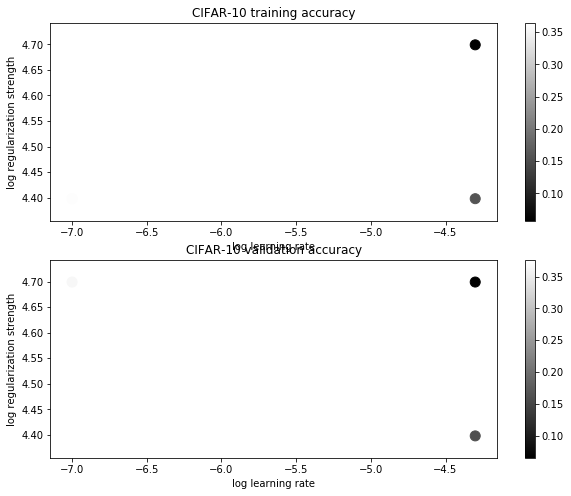

In [42]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [40]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.349000


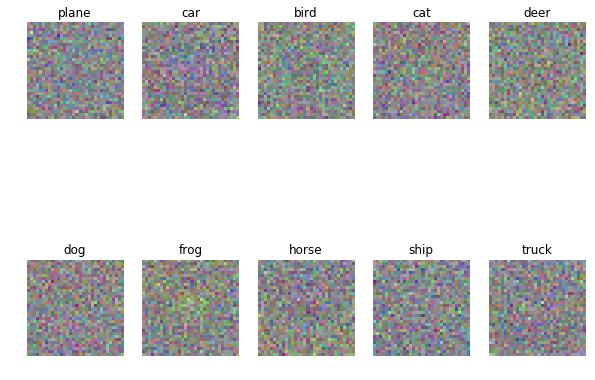

In [41]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** *fill this in*

Answer:my out image looks like color random noise matrix.
If my output data isn't wrong fully,maybe just locally feature in the small scale should be likes above image.